In [1]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import shap
from sklearn.model_selection import train_test_split
# from Parameters import Parameters

# t = Parameters('ranf').training_reg_params

%load_ext autoreload
%autoreload 2

In [2]:
model = Model('ranf')

In [3]:
X,Y = model.preprocessing.load_data('./Agg_data_from_frame_251.xlsx',labels=False,sheet_name="Sheet1")
Y_most_likely = model.preprocessing.load_Y('./Agg_most_likely.xlsx',video_name=False,column_name="same")
Y_old = model.preprocessing.load_Y('../Updated_targets_300519.xlsx',video_name=False,column_name="diff")
Y_new = model.preprocessing.load_Y('../../Frame_Analysis/new_targets_21062019.xlsx',video_name=False,column_name="diff")
Y_unaided = model.preprocessing.load_Y('./Agg_Unaided.xlsx',video_name=False,column_name="same")

In [4]:
X = X.set_index(X['Video Name'])
# X = X.drop('Unnamed: 0',1)
Y_old['Video Name'] = Y_old.index.values
Y_new['Video Name'] = Y_new.index.values

Y_new = Y_new[Y_new['Video Name']!= 'Surface Laptop_UK_30_Courtney v2 US VO_TV']
Y_new = Y_new[Y_new['Video Name']!='284 Surface Laptop_UK_30_Courtney v2 US VO_TV' ]
Y_new = Y_new.drop('Video Name',1)
Y = pd.concat((Y_old,Y_new),axis=1)
Y = pd.concat((Y,Y_most_likely),axis=1)
X = X.loc[X['Campaign']=='Software']
Y = Y.loc[X.index.values,:]
Y['Unaided_Branding'] = Y_unaided.loc[Y.index,['Unaided Branding']]

In [5]:
Y.dropna(how='all')
X,Y= model.preprocessing.clean_data(X,Y)

In [6]:
# surface_pro_frames = [col for col in X.columns if "Surface Pro".lower() in col.lower()]
# for suf in ['_dur','_first_ocr','_last_ocr','_total_ocr']:
#     cols = [col+suf for col in surface_pro_frames[:10]]
#     X = model.preprocessing.addNewFeature(X,cols,_type="sum",new_column_name="Surface"+suf)
# X = X.drop(surface_pro_frames,axis=1)

In [7]:
frame_count_columns = [col for col in X.columns.values if '_dur' in col]
columns_removed =[]
for x in X.columns.values:
    if '_frame_count' in x:
        columns_removed.append(x)
cols = [col[:-12] for col in columns_removed]
for x in frame_count_columns:
#     if x+'_dur' in X.columns.values or '_frame_count' in x:
    if x[:-4] not in cols:
        columns_removed.append(x[:-4])
columns_removed.remove('Intel')
# columns_removed.remove('Surface')

In [8]:
X = X.drop(columns=columns_removed,axis=1)
columns_removed

['African_frame_count',
 'Caucasian_frame_count',
 'Eastasian_frame_count',
 'Latino_frame_count',
 'Angry_frame_count',
 'Disgust_frame_count',
 'Fear_frame_count',
 'Happiness_frame_count',
 'Neutral_frame_count',
 'Sadness_frame_count',
 'Surprise_frame_count',
 'Age: 0-15_frame_count',
 'Age: 15-24_frame_count',
 'Age: 25-34_frame_count',
 'Age: 35-44_frame_count',
 'Age: 45-60_frame_count',
 'Female_frame_count',
 'Male_frame_count',
 'microsoft',
 'ASUS T102',
 'Dell_sub_brand_group',
 'HP_group',
 'Lenovo_group',
 'Macbook_group',
 'Surface_group',
 'Windows',
 'Yoga',
 'Asus_text',
 'Currys PCs world_text',
 'Dell_text',
 'Hp_text',
 'Lenovo_text',
 'Apple',
 'Asus',
 'Dell',
 'Hp',
 'Microsoft_text',
 'Laptop',
 'Tablet',
 'Mobile',
 'PC']

In [9]:
# new_features =[["Happiness_dur",'Female_dur'],["Surprise_dur","Male_dur"],["Neutral_dur","Male_dur"],["Happiness_dur","Age: 0-15_dur"],["Disgust_dur","Age: 45-60_dur"],["Surprise_dur","Age: 0-15_dur"],["Neutral_dur","Age: 25-34_dur"],["Happiness_dur","Eastasian_dur"],["Surprise_dur","Eastasian_dur"]]
# age_cols = ['Age: 0-15_dur', 'Age: 15-24_dur','Age: 25-34_dur', 'Age: 35-44_dur', 'Age: 45-60_dur']
# ethinicity_cols = ['African_dur', 'Caucasian_dur', 'Eastasian_dur','Latino_dur']
# gender_cols = ["Female_dur","Male_dur"]
emotion_cols = ["Happiness_dur","Surprise_dur","Neutral_dur","Sadness_dur"]
# age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
# new_features.extend(age_ethinicity_col)
# X = model.preprocessing.addNewFeature(X,new_features,_type='per')
# X['Happiness_length_of_ad_impact'] = X['Happiness_dur'] * (1-X['length_of_ad_15'])

In [10]:
# X = X.drop(age_cols,1)
# X = X.drop(ethinicity_cols,1)
# X = X.drop(gender_cols,1)
# X = X.drop(emotion_cols,1)

In [11]:
model.preprocessing.checkNull(X).head()
X= model.preprocessing.removeNULLColumns(X,percentage=0.8)
model.preprocessing.checkNull(X).head()

Tablet_first_ocr    79.545455
Tablet_last_ocr     79.545455
Tablet_dur          79.545455
Tablet_total_ocr    79.545455
Age: 35-44_dur      77.272727
dtype: float64

In [12]:
ocr_columns = [col for col in X.columns if "ocr" in col]

X[ocr_columns] = model.preprocessing.imputeConstant(X,columns=ocr_columns,constant=-1)
X = model.preprocessing.replace(X,np.inf,np.nan)

In [13]:
X = model.preprocessing.imputeConstant(X,constant=0)
X = X.fillna(0)

In [14]:
Y = model.preprocessing.imputeMedian(Y,model.preprocessing.targets)
Y.isna().sum()

Unaided_Branding                          0
Brand_Cues__Mean                          0
Aided_Branding__Mean                      0
Active_Involvement__Mean                  0
New_Information__Mean                     0
Enjoyment__Mean                           0
Brand_Appeal__Mean                        0
Understanding__Mean                       0
Relevance_of_Information__Mean            0
Credibility_of_Information__Mean          0
Brand_Difference__Mean                    0
Video Name                                0
Interest_peak                             0
Interest_mean_score                       0
Purchase_intent                           0
Persuasion_mean                           0
Persuasion_very_likely                    0
Interest_peak_frames                      0
Enjoyment_vey_much                        0
Aided_Branding_almost_anything            0
Brand_Cues_very_easily                    0
Brand_Appeal_more_appealing               0
Understanding_very_easily       

In [15]:
X.shape

(44, 138)

In [16]:
(X.columns.values,len(Y.columns))

(array(['Video Name', 'African_dur', 'Eastasian_dur', 'Happiness_dur',
        'Neutral_dur', 'Sadness_dur', 'length_of_ad_15', 'Female_dur',
        'Male_dur', 'Age: 15-24_dur', 'Age: 25-34_dur', 'Age: 35-44_dur',
        'microsoft_dur', 'microsoft_first_ocr', 'microsoft_last_ocr',
        'microsoft_total_ocr', 'ASUS T102_dur', 'Dell_sub_brand_group_dur',
        'HP_group_dur', 'Lenovo_group_dur', 'Macbook_group_dur',
        'Surface_group_dur', 'Windows_dur', 'Yoga_dur',
        'Windows_first_ocr', 'Windows_last_ocr', 'Windows_total_ocr',
        'Asus_text_dur', 'Currys PCs world_text_dur', 'Dell_text_dur',
        'Hp_text_dur', 'Lenovo_text_dur', 'Hp_text_first_ocr',
        'Hp_text_last_ocr', 'Hp_text_total_ocr', 'Apple_dur', 'Asus_dur',
        'Dell_dur', 'Hp_dur', 'Hp_first_ocr', 'Hp_last_ocr',
        'Hp_total_ocr', 'Laptop_dur', 'Laptop_first_ocr',
        'Laptop_last_ocr', 'Laptop_total_ocr', 'Tablet_dur',
        'Tablet_first_ocr', 'Tablet_last_ocr', 'Tablet_tota

In [17]:
# Y_14 = Y.loc[:,Y.isna().sum()==0]
# Y_4 = Y.loc[:,Y.isna().sum()!=0]
# X_4 = X[Y_4['Unaided_Branding'].isna()==False]
# Y_4 = Y_4[Y_4['Unaided_Branding'].isna()==False]

In [33]:
X.shape

(44, 138)

In [18]:
(X.dtypes[30:40] == object)

Hp_text_dur          False
Lenovo_text_dur      False
Hp_text_first_ocr    False
Hp_text_last_ocr     False
Hp_text_total_ocr    False
Apple_dur            False
Asus_dur             False
Dell_dur             False
Hp_dur               False
Hp_first_ocr         False
dtype: bool

In [19]:
X_res_27,Y_res_27 = model.preprocessing.overSampling(X,Y.drop('Video Name',1),each_Col=False,size=800,random_state=12)
X_train_27,X_test_27,y_train_27,y_test_27 = train_test_split(X_res_27,Y_res_27,random_state = 123,test_size=0.3)

# X_res_4,Y_res_4 = model.preprocessing.overSampling(X_4,Y_4,each_Col=False,size=1000,random_state=12)
# X_train_4,X_test_4,y_train_4,y_test_4 = train_test_split(X_res_4,Y_res_4,random_state = 123,test_size=0.3)

In [20]:
# print("------------------------ 14 Models Training ----------------------------\n")
# models_14 = model.train(X_train_14,y_train_14,X_test_14,y_test_14,metrics='r2',plot_error=False,set_params=True,params=t)
print("------------------------ 17 Models Training ----------------------------\n")
models_27,acc_df = model.train(X_train_27,y_train_27,X_test_27,y_test_27,metrics='r2',plot_error=False)

------------------------ 17 Models Training ----------------------------

Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.983978
For test set
r2_score: 0.975063


Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.967269
For test set
r2_score: 0.984189


Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.976596
For test set
r2_score: 0.984985


Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.970105
For test set
r2_score: 0.972494


New_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.981323
For test set
r2_score: 0.988435


Enjoyment__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.970324
For test set
r2_score: 0.976838


Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.984397
For test set
r2_score: 0.986321


Understanding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.976136
For test set
r2_score: 0.981165


Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.965380
For test set
r2_score: 0.970623


Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.970079
For test set
r2_score: 0.980145


Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.975473
For test set
r2_score: 0.977975


Interest_peak


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.957558
For test set
r2_score: 0.965007


Interest_mean_score


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.975377
For test set
r2_score: 0.979735


Purchase_intent


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.956716
For test set
r2_score: 0.976614


Persuasion_mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.909807
For test set
r2_score: 0.928979


Persuasion_very_likely


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.911356
For test set
r2_score: 0.901034


Interest_peak_frames


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.958080
For test set
r2_score: 0.961148


Enjoyment_vey_much


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.986454
For test set
r2_score: 0.985059


Aided_Branding_almost_anything


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.955208
For test set
r2_score: 0.962926


Brand_Cues_very_easily


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.970213
For test set
r2_score: 0.977618


Brand_Appeal_more_appealing


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.981880
For test set
r2_score: 0.984347


Understanding_very_easily


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.974591
For test set
r2_score: 0.976251


Relevance_Information_very_relevant


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.967544
For test set
r2_score: 0.974161


Credibility_Information_agree_strongly


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.962746
For test set
r2_score: 0.970123


New_Information_alot


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.981366
For test set
r2_score: 0.985707


Brand_Difference_strongly


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For training set
r2_score: 0.971024
For test set
r2_score: 0.976803




[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


In [21]:
acc_df

Unaided_Branding Brand_Cues__Mean Aided_Branding__Mean  \
0          0.983978         0.967269             0.976596   
1          0.975063         0.984189             0.984985   
2               NaN              NaN                  NaN   
3               NaN              NaN                  NaN   
4               NaN              NaN                  NaN   
5               NaN              NaN                  NaN   
6               NaN              NaN                  NaN   
7               NaN              NaN                  NaN   
8               NaN              NaN                  NaN   
9               NaN              NaN                  NaN   
10              NaN              NaN                  NaN   
11              NaN              NaN                  NaN   

   Active_Involvement__Mean New_Information__Mean Enjoyment__Mean  \
0                  0.970105              0.981323        0.970324   
1                  0.972494              0.988435        0.976838   
2                       NaN                   NaN             NaN   
3                       NaN                   NaN             NaN   
4                       NaN                   NaN             NaN   
5                       NaN                   NaN             NaN   
6                       NaN                   NaN             NaN   
7                       NaN                   NaN             NaN   
8                       NaN                   NaN             NaN   
9                       NaN                   NaN             NaN   
10                      NaN                   NaN             NaN   
11                      NaN                   NaN             NaN   

   Brand_Appeal__Mean Understanding__Mean Relevance_of_Information__Mean  \
0            0.984397            0.976136                        0.96538   
1            0.986321            0.981165                       0.970623   
2                 NaN                 NaN                            NaN   
3                 NaN                 NaN                            NaN   
4                 NaN                 NaN                            NaN   
5                 NaN                 NaN                            NaN   
6                 NaN                 NaN                            NaN   
7                 NaN                 NaN                            NaN   
8                 NaN                 NaN                            NaN   
9                 NaN                 NaN                            NaN   
10                NaN                 NaN                            NaN   
11                NaN                 NaN                            NaN   

   Credibility_of_Information__Mean  ... Interest_peak_frames  \
0                          0.970079  ...              0.95808   
1                          0.980145  ...             0.961148   
2                               NaN  ...                  NaN   
3                               NaN  ...                  NaN   
4                               NaN  ...                  NaN   
5                               NaN  ...                  NaN   
6                               NaN  ...                  NaN   
7                               NaN  ...                  NaN   
8                               NaN  ...                  NaN   
9                               NaN  ...                  NaN   
10                              NaN  ...                  NaN   
11                              NaN  ...                  NaN   

   Enjoyment_vey_much Aided_Branding_almost_anything Brand_Cues_very_easily  \
0            0.986454                       0.955208               0.970213   
1            0.985059                       0.962926               0.977618   
2                 NaN                            NaN                    NaN   
3                 NaN                            NaN                    NaN   
4                 NaN                            NaN                    NaN   
5 

In [22]:
model_dt = Model('DT')
models_27_dt = model_dt.train(X_train_27,y_train_27,X_test_27,y_test_27,metrics='r2',plot_error=False)

Unaided_Branding
For training set
r2_score: 0.870251
For test set
r2_score: 0.918029


Brand_Cues__Mean
For training set
r2_score: 0.753626
For test set
r2_score: 0.872173


Aided_Branding__Mean
For training set
r2_score: 0.764740
For test set
r2_score: 0.872953


Active_Involvement__Mean
For training set
r2_score: 0.667483
For test set
r2_score: 0.707475


New_Information__Mean
For training set
r2_score: 0.798318
For test set
r2_score: 0.897564


Enjoyment__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

For training set
r2_score: 0.795887
For test set
r2_score: 0.819179


Brand_Appeal__Mean
For training set
r2_score: 0.811603
For test set
r2_score: 0.831730


Understanding__Mean
For training set
r2_score: 0.780451
For test set
r2_score: 0.821222


Relevance_of_Information__Mean
For training set
r2_score: 0.787456
For test set
r2_score: 0.831781


Credibility_of_Information__Mean
For training set
r2_score: 0.700088
For test set
r2_score: 0.686261


Brand_Difference__Mean
For training set
r2_score: 0.782296
For test set
r2_score: 0.813575


Interest_peak


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

For training set
r2_score: 0.576599
For test set
r2_score: 0.457107


Interest_mean_score
For training set
r2_score: 0.769363
For test set
r2_score: 0.790907


Purchase_intent
For training set
r2_score: 0.582348
For test set
r2_score: 0.811304


Persuasion_mean
For training set
r2_score: -0.649567
For test set
r2_score: 0.500154


Persuasion_very_likely
For training set
r2_score: 0.065503
For test set
r2_score: 0.541350


Interest_peak_frames
For training set
r2_score: 0.576599
For test set
r2_score: 0.457107


Enjoyment_vey_much


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

For training set
r2_score: 0.869747
For test set
r2_score: 0.872909


Aided_Branding_almost_anything
For training set
r2_score: 0.638419
For test set
r2_score: 0.701627


Brand_Cues_very_easily
For training set
r2_score: 0.638722
For test set
r2_score: 0.727454


Brand_Appeal_more_appealing
For training set
r2_score: 0.826905
For test set
r2_score: 0.861206


Understanding_very_easily
For training set
r2_score: 0.666674
For test set
r2_score: 0.674474


Relevance_Information_very_relevant
For training set
r2_score: 0.720873
For test set
r2_score: 0.788466


Credibility_Information_agree_strongly
For training set
r2_score: 0.624691
For test set
r2_score: 0.675809


New_Information_alot
For training set
r2_score: 0.830344
For test set
r2_score: 0.887815


Brand_Difference_strongly
For training set
r2_score: 0.752304
For test set
r2_score: 0.785536




[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


### Change folder path

In [23]:
model_dt.plot_tree(savefig=True,folder="./Version_6/Software/Plots_dt/")

Unaided_Branding
Feature ranking:
glass
clouds
soothing
Lenovo_text_dur
sunny
cluttered space
Windows_total_ocr
Male_dur
Windows_last_ocr
Lenovo_group_dur
Laptop_first_ocr
using tools
Yoga_dur
Laptop_dur
Laptop_last_ocr
exercise
Windows_first_ocr
Happiness_dur
Age: 15-24_dur
eating
sterile
microsoft_first_ocr
Hp_text_total_ocr
Hp_text_last_ocr
matte
Windows_dur
Hp_text_first_ocr
Hp_text_dur
Female_dur
microsoft_last_ocr
Laptop_total_ocr
Age: 25-34_dur
sports
Hp_last_ocr
Asus_text_dur
Neutral_dur
Hp_dur
sand
Eastasian_dur
touring
driving
Hp_total_ocr
horizontal components
Sadness_dur
HP_group_dur
transporting
grass
research
flowers
asphalt
brick
conducting business
Dell_sub_brand_group_dur
studying
ASUS T102_dur
natural light
Hp_first_ocr
spectating
warm
socializing
African_dur
Age: 35-44_dur
metal
training
vegetation
microsoft_dur
playing
vertical components
paper
stressful
foliage
length_of_ad_15
Surface_group_dur
leaves
trees
camping
cold
microsoft_total_ocr
climbing
Tablet_dur
semi-

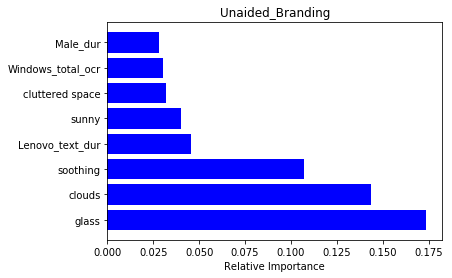

Brand_Cues__Mean
Feature ranking:
Male_dur
soothing
microsoft_first_ocr
Laptop_total_ocr
microsoft_last_ocr
Windows_last_ocr
socializing
microsoft_total_ocr
Age: 25-34_dur
Age: 15-24_dur
sunny
Laptop_last_ocr
glossy
Windows_first_ocr
metal
African_dur
Female_dur
Laptop_first_ocr
Happiness_dur
carpet
cluttered space
Neutral_dur
clouds
conducting business
glass
microsoft_dur
exercise
Laptop_dur
Hp_dur
Sadness_dur
Windows_dur
scary
Hp_last_ocr
warm
medical activity
far-away horizon
shopping
stressful
length_of_ad_15
transporting
rugged scene
natural
training
Eastasian_dur
Tablet_first_ocr
sand
ASUS T102_dur
Asus_dur
vertical components
ocean
Age: 35-44_dur
studying
Asus_text_dur
touring
Tablet_last_ocr
horizontal components
Hp_total_ocr
HP_group_dur
Hp_first_ocr
Tablet_dur
reading
aged
waiting in line
cold
Windows_total_ocr
Tablet_total_ocr
brick
Dell_text_dur
playing
research
sports
plastic
congregating
Dell_dur
spectating
swimming
railing
tiles
foliage
leaves
diving
eating
still water
H

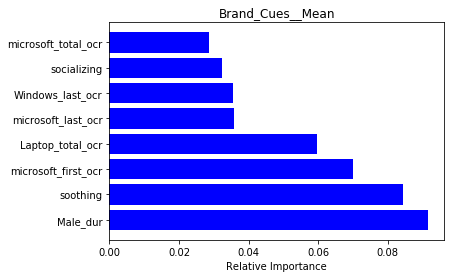

Aided_Branding__Mean
Feature ranking:
soothing
Windows_last_ocr
microsoft_last_ocr
horizontal components
shopping
Hp_text_dur
Windows_first_ocr
vertical components
Hp_text_total_ocr
Age: 25-34_dur
glossy
sunny
microsoft_dur
Windows_dur
Happiness_dur
glass
ASUS T102_dur
Male_dur
Laptop_dur
Age: 15-24_dur
socializing
dry
Sadness_dur
Windows_total_ocr
length_of_ad_15
Laptop_last_ocr
clouds
Neutral_dur
Hp_text_last_ocr
microsoft_first_ocr
stressful
Hp_text_first_ocr
metal
aged
research
Asus_text_dur
symmetrical
Laptop_total_ocr
Laptop_first_ocr
spectating
vegetation
African_dur
conducting business
rugged scene
Age: 35-44_dur
sports
congregating
Tablet_last_ocr
training
Eastasian_dur
touring
Hp_last_ocr
Tablet_total_ocr
Hp_total_ocr
playing
reading
Tablet_dur
brick
Hp_dur
asphalt
warm
plastic
Female_dur
Lenovo_text_dur
Surface_group_dur
paper
microsoft_total_ocr
Lenovo_group_dur
Yoga_dur
gaming
cluttered space
transporting
carpet
cold
waiting in line
fire
matte
studying
Hp_first_ocr
ocean
s

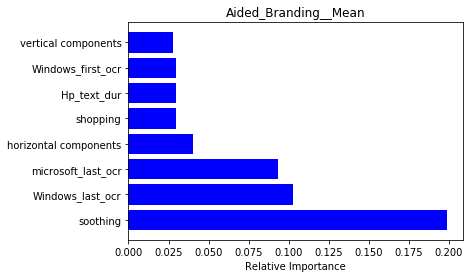

Active_Involvement__Mean
Feature ranking:
cluttered space
flowers
natural light
African_dur
sunny
Age: 25-34_dur
carpet
metal
Laptop_last_ocr
Laptop_total_ocr
Hp_first_ocr
microsoft_dur
playing
Laptop_dur
training
Windows_last_ocr
microsoft_first_ocr
touring
aged
clouds
exercise
congregating
microsoft_last_ocr
Age: 35-44_dur
vertical components
medical activity
Windows_dur
Sadness_dur
Lenovo_text_dur
Neutral_dur
horizontal components
spectating
Dell_text_dur
Windows_first_ocr
Tablet_last_ocr
shopping
Laptop_first_ocr
Hp_last_ocr
Female_dur
Male_dur
Tablet_total_ocr
Tablet_dur
Hp_text_first_ocr
cold
Hp_dur
Hp_text_last_ocr
microsoft_total_ocr
glass
studying
Happiness_dur
Tablet_first_ocr
socializing
Eastasian_dur
research
asphalt
Hp_total_ocr
Age: 15-24_dur
sports
sterile
soothing
Lenovo_group_dur
matte
Hp_text_dur
using tools
reading
Dell_sub_brand_group_dur
plastic
paper
driving
Hp_text_total_ocr
warm
conducting business
gaming
ocean
scary
trees
Windows_total_ocr
brick
transporting
dr

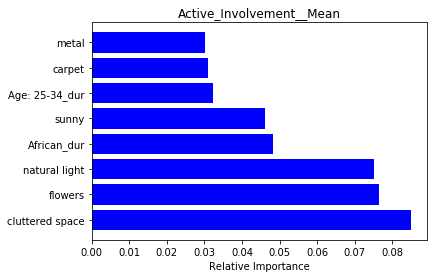

New_Information__Mean
Feature ranking:
microsoft_last_ocr
Laptop_last_ocr
Lenovo_text_dur
Laptop_first_ocr
metal
Laptop_total_ocr
soothing
sunny
microsoft_first_ocr
exercise
Laptop_dur
Yoga_dur
training
clouds
transporting
medical activity
asphalt
Neutral_dur
Windows_last_ocr
warm
congregating
Eastasian_dur
carpet
Lenovo_group_dur
Happiness_dur
socializing
microsoft_total_ocr
sports
microsoft_dur
driving
shopping
brick
Hp_total_ocr
Female_dur
Age: 25-34_dur
studying
reading
trees
Hp_last_ocr
African_dur
Windows_first_ocr
Age: 35-44_dur
Hp_dur
aged
Tablet_dur
fire
Tablet_total_ocr
Sadness_dur
Windows_dur
swimming
Hp_text_last_ocr
snow
horizontal components
Windows_total_ocr
foliage
Male_dur
Hp_first_ocr
sand
Hp_text_first_ocr
waiting in line
Age: 15-24_dur
natural light
Tablet_last_ocr
flowers
touring
research
biking
plastic
paper
Surface_group_dur
glossy
pavement
ocean
cold
Dell_dur
spectating
vegetation
glass
grass
shrubbery
boating
matte
sterile
conducting business
Hp_text_dur
Tablet

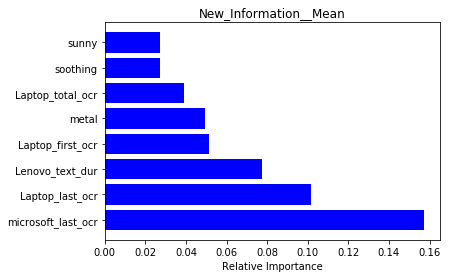

Enjoyment__Mean
Feature ranking:
Windows_last_ocr
microsoft_last_ocr
length_of_ad_15
Windows_first_ocr
Laptop_last_ocr
Happiness_dur
Laptop_first_ocr
Laptop_dur
microsoft_first_ocr
using tools
sterile
Laptop_total_ocr
Male_dur
Lenovo_text_dur
training
microsoft_dur
Age: 15-24_dur
Neutral_dur
microsoft_total_ocr
Hp_last_ocr
Age: 35-44_dur
Yoga_dur
metal
scary
matte
warm
semi-enclosed area
Lenovo_group_dur
Sadness_dur
Age: 25-34_dur
African_dur
exercise
Hp_text_total_ocr
Eastasian_dur
Windows_dur
socializing
carpet
reading
transporting
Hp_first_ocr
Female_dur
Surface_group_dur
sunny
soothing
symmetrical
Hp_text_last_ocr
ocean
studying
Windows_total_ocr
glass
vertical components
Hp_total_ocr
Tablet_total_ocr
Hp_dur
touring
boating
sports
playing
clouds
Hp_text_dur
cold
still water
brick
leaves
plastic
spectating
Tablet_dur
Dell_sub_brand_group_dur
paper
diving
aged
stressful
HP_group_dur
conducting business
Tablet_last_ocr
congregating
horizontal components
Tablet_first_ocr
dry
shopping
m

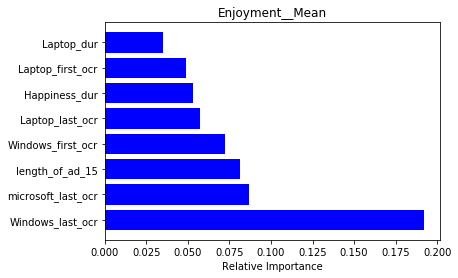

Brand_Appeal__Mean
Feature ranking:
Windows_last_ocr
microsoft_first_ocr
Laptop_last_ocr
training
Windows_first_ocr
microsoft_last_ocr
metal
warm
socializing
carpet
Laptop_total_ocr
Yoga_dur
Lenovo_text_dur
Male_dur
soothing
Laptop_first_ocr
length_of_ad_15
Age: 35-44_dur
transporting
Windows_dur
Lenovo_group_dur
Female_dur
reading
Hp_dur
microsoft_dur
Happiness_dur
Neutral_dur
congregating
exercise
Eastasian_dur
Sadness_dur
spectating
Age: 25-34_dur
sports
Hp_total_ocr
fire
sand
conducting business
paper
Hp_text_last_ocr
using tools
touring
ocean
Age: 15-24_dur
asphalt
medical activity
driving
waiting in line
Laptop_dur
studying
brick
still water
sterile
sunny
eating
Hp_text_first_ocr
Windows_total_ocr
Hp_last_ocr
Surface_group_dur
trees
microsoft_total_ocr
Hp_text_dur
Hp_first_ocr
vegetation
African_dur
plastic
aged
research
dry
horizontal components
flowers
stressful
Hp_text_total_ocr
cold
scary
natural light
Tablet_dur
swimming
semi-enclosed area
Tablet_first_ocr
foliage
Asus_text_

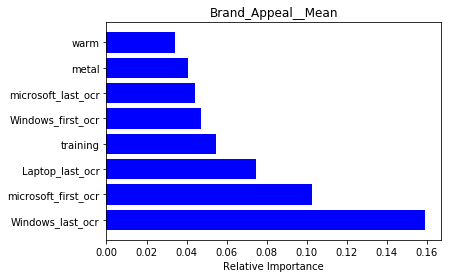

Understanding__Mean
Feature ranking:
soothing
waiting in line
vertical components
microsoft_dur
Female_dur
microsoft_last_ocr
Male_dur
metal
congregating
microsoft_first_ocr
studying
Windows_last_ocr
sunny
Windows_dur
Neutral_dur
Hp_text_dur
carpet
Sadness_dur
Happiness_dur
conducting business
Age: 25-34_dur
Laptop_first_ocr
Age: 15-24_dur
medical activity
Laptop_dur
transporting
Laptop_total_ocr
Hp_first_ocr
socializing
training
Hp_dur
Windows_first_ocr
clouds
glass
Hp_total_ocr
African_dur
Hp_last_ocr
microsoft_total_ocr
Hp_text_last_ocr
Laptop_last_ocr
stressful
shopping
horizontal components
trees
Hp_text_total_ocr
Hp_text_first_ocr
Eastasian_dur
warm
spectating
foliage
flowers
natural light
matte
grass
sand
Age: 35-44_dur
exercise
dry
ASUS T102_dur
cluttered space
aged
research
playing
sports
brick
ocean
Tablet_dur
Asus_text_dur
glossy
reading
touring
vegetation
Windows_total_ocr
rugged scene
plastic
Lenovo_text_dur
paper
length_of_ad_15
semi-enclosed area
sterile
Surface_group_du

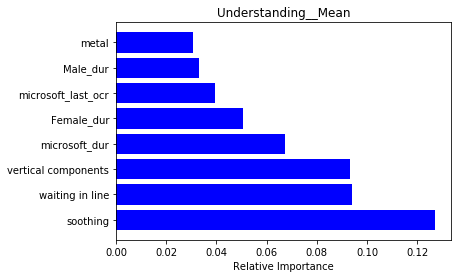

Relevance_of_Information__Mean
Feature ranking:
microsoft_last_ocr
Windows_last_ocr
microsoft_first_ocr
medical activity
Windows_first_ocr
Laptop_first_ocr
length_of_ad_15
Laptop_total_ocr
Happiness_dur
Laptop_last_ocr
Age: 25-34_dur
Neutral_dur
metal
Age: 15-24_dur
Male_dur
ASUS T102_dur
studying
Eastasian_dur
Laptop_dur
Asus_dur
exercise
microsoft_dur
aged
Age: 35-44_dur
Asus_text_dur
Windows_dur
dry
transporting
Hp_text_total_ocr
carpet
playing
warm
congregating
Hp_text_dur
soothing
cold
training
matte
African_dur
Hp_last_ocr
gaming
shopping
Female_dur
Hp_first_ocr
horizontal components
clouds
conducting business
paper
spectating
socializing
glossy
semi-enclosed area
Sadness_dur
Windows_total_ocr
research
Hp_text_last_ocr
brick
Hp_dur
asphalt
sunny
eating
sterile
Hp_text_first_ocr
plastic
Hp_total_ocr
reading
scary
microsoft_total_ocr
Lenovo_group_dur
natural light
cluttered space
boating
Surface_group_dur
Tablet_first_ocr
Tablet_dur
wood
waiting in line
Tablet_last_ocr
driving
Tabl

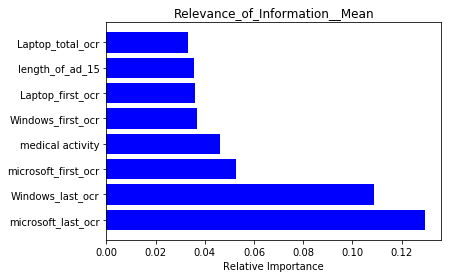

Credibility_of_Information__Mean
Feature ranking:
Laptop_last_ocr
Laptop_first_ocr
Laptop_total_ocr
microsoft_last_ocr
transporting
training
waiting in line
Neutral_dur
microsoft_dur
dry
warm
exercise
touring
reading
metal
microsoft_first_ocr
Windows_dur
soothing
Windows_first_ocr
conducting business
microsoft_total_ocr
Age: 25-34_dur
trees
vegetation
horizontal components
sunny
Windows_last_ocr
socializing
Happiness_dur
Laptop_dur
Male_dur
foliage
clouds
Hp_text_dur
Windows_total_ocr
Female_dur
ocean
scary
congregating
studying
Eastasian_dur
Age: 15-24_dur
Hp_dur
Sadness_dur
Hp_text_first_ocr
sports
playing
Hp_first_ocr
Hp_total_ocr
Hp_last_ocr
Tablet_dur
Tablet_first_ocr
Dell_dur
carpet
brick
medical activity
Tablet_total_ocr
Dell_sub_brand_group_dur
aged
using tools
Dell_text_dur
sterile
still water
Hp_text_total_ocr
eating
shopping
glass
spectating
Hp_text_last_ocr
Tablet_last_ocr
asphalt
African_dur
vertical components
paper
Surface_group_dur
length_of_ad_15
Age: 35-44_dur
Lenovo_

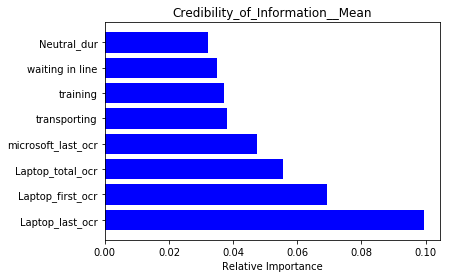

Brand_Difference__Mean
Feature ranking:
microsoft_last_ocr
Laptop_last_ocr
Windows_last_ocr
metal
training
microsoft_first_ocr
Windows_first_ocr
Laptop_first_ocr
Dell_text_dur
Neutral_dur
exercise
length_of_ad_15
Laptop_dur
carpet
warm
touring
Laptop_total_ocr
soothing
sunny
Age: 15-24_dur
Happiness_dur
glossy
Age: 25-34_dur
Tablet_total_ocr
congregating
waiting in line
Age: 35-44_dur
Tablet_dur
conducting business
Tablet_last_ocr
reading
natural light
clouds
aged
African_dur
flowers
rugged scene
Eastasian_dur
sports
paper
vertical components
microsoft_dur
Sadness_dur
Windows_dur
socializing
studying
Hp_total_ocr
using tools
asphalt
HP_group_dur
medical activity
Male_dur
ocean
Dell_dur
Hp_text_dur
sterile
playing
Tablet_first_ocr
Hp_text_first_ocr
shopping
microsoft_total_ocr
cold
Hp_last_ocr
Hp_dur
Hp_text_total_ocr
transporting
research
spectating
horizontal components
Hp_text_last_ocr
Female_dur
Lenovo_text_dur
Hp_first_ocr
stressful
Windows_total_ocr
Lenovo_group_dur
glass
brick
AS

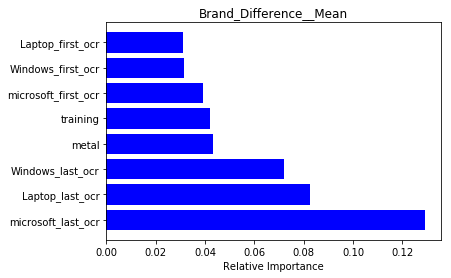

Interest_peak
Feature ranking:
Dell_text_dur
touring
microsoft_first_ocr
Laptop_first_ocr
Windows_first_ocr
Laptop_total_ocr
Windows_last_ocr
semi-enclosed area
Neutral_dur
microsoft_last_ocr
shopping
Happiness_dur
Age: 15-24_dur
training
Windows_dur
microsoft_dur
Male_dur
Eastasian_dur
Laptop_dur
African_dur
Laptop_last_ocr
Female_dur
Age: 25-34_dur
Sadness_dur
playing
conducting business
sand
sunny
metal
Hp_total_ocr
paper
transporting
length_of_ad_15
sports
socializing
Hp_last_ocr
railing
soothing
Age: 35-44_dur
microsoft_total_ocr
Dell_dur
sterile
studying
Tablet_total_ocr
spectating
using tools
Windows_total_ocr
horizontal components
exercise
plastic
research
ocean
Tablet_dur
Hp_dur
Hp_first_ocr
eating
brick
scary
swimming
HP_group_dur
Tablet_last_ocr
Tablet_first_ocr
stressful
Lenovo_group_dur
Surface_group_dur
glass
warm
cold
matte
Hp_text_first_ocr
clouds
vegetation
asphalt
aged
carpet
Hp_text_dur
Asus_text_dur
reading
tiles
medical activity
Hp_text_total_ocr
gaming
ASUS T102_d

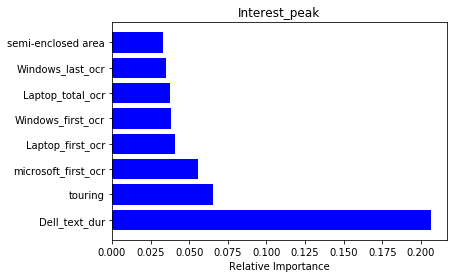

Interest_mean_score
Feature ranking:
Windows_last_ocr
Windows_first_ocr
microsoft_last_ocr
waiting in line
Windows_dur
microsoft_first_ocr
microsoft_dur
length_of_ad_15
Laptop_total_ocr
Laptop_last_ocr
warm
Hp_text_dur
congregating
Hp_dur
carpet
sunny
Laptop_first_ocr
Laptop_dur
exercise
Dell_text_dur
Female_dur
studying
Hp_total_ocr
brick
Eastasian_dur
sterile
Hp_text_last_ocr
Age: 25-34_dur
Hp_text_total_ocr
using tools
cold
Neutral_dur
Happiness_dur
Age: 35-44_dur
Hp_text_first_ocr
spectating
shopping
training
semi-enclosed area
gaming
Male_dur
stressful
socializing
far-away horizon
African_dur
vertical components
asphalt
Hp_last_ocr
Hp_first_ocr
scary
Tablet_last_ocr
natural
wood
paper
symmetrical
ocean
vegetation
metal
aged
research
glossy
plastic
microsoft_total_ocr
sand
Tablet_dur
foliage
glass
matte
reading
driving
trees
playing
sports
soothing
Tablet_first_ocr
Yoga_dur
eating
Sadness_dur
Lenovo_group_dur
boating
touring
grass
Dell_dur
Dell_sub_brand_group_dur
horizontal compon

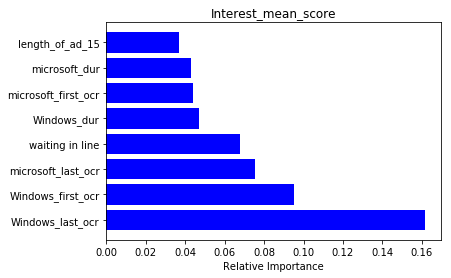

Purchase_intent
Feature ranking:
Dell_sub_brand_group_dur
Dell_text_dur
gaming
microsoft_last_ocr
microsoft_dur
touring
Laptop_last_ocr
Dell_dur
using tools
microsoft_total_ocr
Windows_last_ocr
sterile
sunny
socializing
Hp_last_ocr
Laptop_total_ocr
Windows_first_ocr
Laptop_first_ocr
microsoft_first_ocr
Hp_first_ocr
studying
congregating
Happiness_dur
aged
metal
training
conducting business
Hp_text_first_ocr
Hp_text_last_ocr
Laptop_dur
Windows_dur
eating
Neutral_dur
Tablet_dur
Age: 25-34_dur
brick
shopping
exercise
Sadness_dur
Female_dur
clouds
cold
vertical components
Eastasian_dur
Windows_total_ocr
African_dur
transporting
sports
matte
ocean
Age: 15-24_dur
Hp_dur
scary
Male_dur
playing
glass
Hp_total_ocr
spectating
waiting in line
trees
vegetation
medical activity
research
carpet
sand
paper
Age: 35-44_dur
Tablet_total_ocr
horizontal components
moist
Tablet_last_ocr
asphalt
soothing
foliage
stressful
Tablet_first_ocr
tiles
symmetrical
still water
Hp_text_dur
dry
Hp_text_total_ocr
Lenov

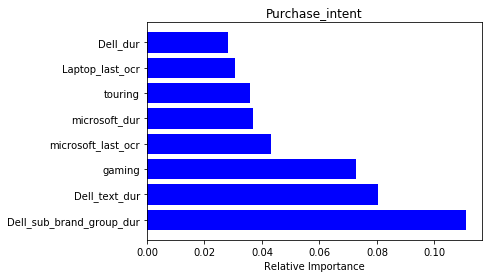

Persuasion_mean
Feature ranking:
touring
shopping
Dell_text_dur
conducting business
sports
Dell_dur
Laptop_last_ocr
training
Happiness_dur
sunny
Age: 25-34_dur
microsoft_first_ocr
Windows_last_ocr
Hp_last_ocr
microsoft_dur
Laptop_total_ocr
cold
socializing
exercise
Laptop_dur
Lenovo_group_dur
Neutral_dur
spectating
metal
transporting
Windows_first_ocr
Eastasian_dur
moist
soothing
vegetation
microsoft_total_ocr
Laptop_first_ocr
Hp_first_ocr
grass
tiles
hiking
Hp_total_ocr
Female_dur
research
warm
dirt
ice
foliage
Sadness_dur
climbing
Male_dur
studying
trees
Windows_dur
Age: 35-44_dur
reading
microsoft_last_ocr
carpet
ocean
horizontal components
Age: 15-24_dur
medical activity
snow
African_dur
scary
aged
paper
leaves
length_of_ad_15
glass
Hp_dur
camping
HP_group_dur
cluttered space
congregating
glossy
fire
brick
driving
Hp_text_last_ocr
sand
swimming
sterile
rugged scene
wood
using tools
Yoga_dur
Tablet_last_ocr
Tablet_total_ocr
symmetrical
asphalt
Hp_text_first_ocr
Asus_text_dur
dry
pla

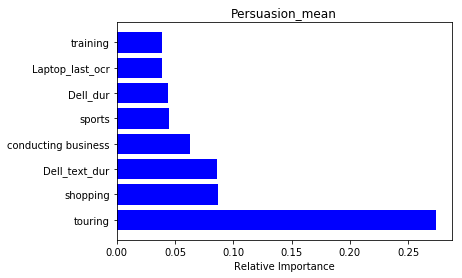

Persuasion_very_likely
Feature ranking:
touring
Dell_text_dur
Laptop_last_ocr
conducting business
shopping
Dell_dur
reading
Age: 35-44_dur
Age: 25-34_dur
microsoft_first_ocr
Neutral_dur
training
Happiness_dur
Female_dur
Laptop_dur
Male_dur
sports
sunny
Windows_dur
microsoft_dur
Windows_last_ocr
Dell_sub_brand_group_dur
Windows_first_ocr
cold
using tools
sterile
playing
spectating
microsoft_last_ocr
Laptop_first_ocr
Laptop_total_ocr
Sadness_dur
metal
African_dur
glass
horizontal components
Age: 15-24_dur
microsoft_total_ocr
warm
Lenovo_group_dur
eating
socializing
congregating
exercise
Hp_total_ocr
Eastasian_dur
research
Hp_first_ocr
Tablet_dur
Tablet_last_ocr
brick
soothing
Tablet_total_ocr
Tablet_first_ocr
Hp_dur
Hp_last_ocr
waiting in line
Hp_text_total_ocr
cluttered space
grass
stressful
foliage
studying
Windows_total_ocr
Hp_text_last_ocr
Hp_text_first_ocr
medical activity
still water
dirt
dry
carpet
aged
ice
plastic
paper
clouds
vegetation
HP_group_dur
diving
Lenovo_text_dur
campin

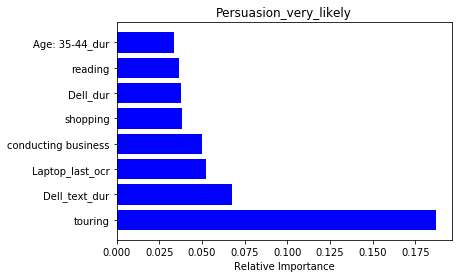

Interest_peak_frames
Feature ranking:
Dell_text_dur
touring
microsoft_first_ocr
Laptop_total_ocr
Windows_first_ocr
Windows_last_ocr
Laptop_first_ocr
semi-enclosed area
microsoft_last_ocr
Neutral_dur
Happiness_dur
Age: 15-24_dur
shopping
Male_dur
training
Laptop_last_ocr
Laptop_dur
microsoft_dur
Windows_dur
Eastasian_dur
Age: 25-34_dur
African_dur
Female_dur
Sadness_dur
length_of_ad_15
metal
playing
conducting business
sports
Hp_total_ocr
paper
socializing
sand
sunny
transporting
microsoft_total_ocr
Dell_dur
railing
sterile
soothing
studying
Hp_last_ocr
Age: 35-44_dur
using tools
horizontal components
plastic
spectating
research
Tablet_total_ocr
Hp_dur
brick
Windows_total_ocr
exercise
Lenovo_group_dur
Hp_first_ocr
eating
HP_group_dur
Tablet_dur
ocean
cold
swimming
matte
Tablet_last_ocr
Hp_text_dur
scary
aged
vegetation
warm
glass
gaming
Hp_text_first_ocr
carpet
asphalt
clouds
reading
stressful
Surface_group_dur
cluttered space
Hp_text_total_ocr
tiles
Asus_text_dur
Tablet_first_ocr
Lenov

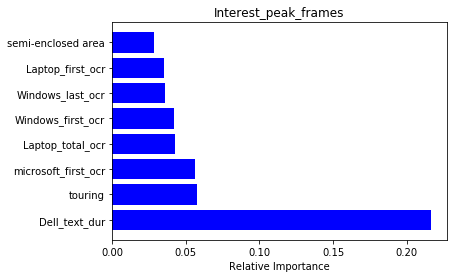

Enjoyment_vey_much
Feature ranking:
Windows_last_ocr
microsoft_last_ocr
Windows_first_ocr
length_of_ad_15
training
microsoft_first_ocr
Laptop_last_ocr
Laptop_dur
Laptop_total_ocr
Happiness_dur
medical activity
sunny
reading
microsoft_total_ocr
Male_dur
Neutral_dur
carpet
natural light
warm
exercise
microsoft_dur
flowers
cluttered space
Age: 25-34_dur
Lenovo_text_dur
Age: 35-44_dur
Sadness_dur
Hp_last_ocr
Eastasian_dur
soothing
Laptop_first_ocr
scary
Windows_dur
cold
Yoga_dur
Lenovo_group_dur
shopping
matte
Tablet_dur
dry
sports
ocean
plastic
swimming
railing
horizontal components
African_dur
Tablet_total_ocr
Age: 15-24_dur
eating
Female_dur
metal
transporting
semi-enclosed area
Hp_first_ocr
Hp_text_last_ocr
aged
Hp_text_first_ocr
Hp_total_ocr
clouds
studying
Windows_total_ocr
Dell_text_dur
paper
Tablet_first_ocr
Hp_dur
sterile
rugged scene
congregating
Hp_text_dur
gaming
grass
spectating
vertical components
sand
brick
tiles
using tools
research
foliage
moist
socializing
symmetrical
HP_

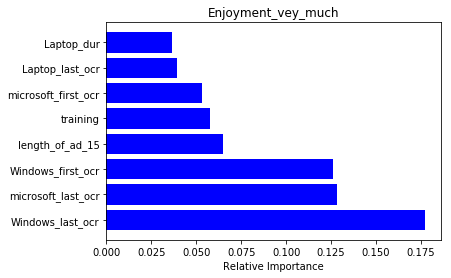

Aided_Branding_almost_anything
Feature ranking:
horizontal components
Age: 25-34_dur
microsoft_dur
Neutral_dur
trees
Male_dur
Laptop_first_ocr
Happiness_dur
Laptop_total_ocr
microsoft_last_ocr
glass
medical activity
metal
Windows_first_ocr
Laptop_dur
leaves
wood
snow
Sadness_dur
Windows_dur
eating
Age: 15-24_dur
carpet
Eastasian_dur
natural light
exercise
matte
sunny
Hp_text_dur
soothing
Windows_last_ocr
research
gaming
microsoft_first_ocr
flowers
vegetation
dry
Hp_text_total_ocr
Age: 35-44_dur
socializing
warm
congregating
Laptop_last_ocr
spectating
microsoft_total_ocr
foliage
stressful
Windows_total_ocr
African_dur
Female_dur
ocean
Hp_dur
reading
scary
Hp_text_first_ocr
clouds
Tablet_last_ocr
Surface_group_dur
Hp_last_ocr
conducting business
brick
sports
Hp_total_ocr
swimming
plastic
paper
Hp_text_last_ocr
Tablet_dur
far-away horizon
natural
symmetrical
studying
Tablet_first_ocr
training
Lenovo_group_dur
aged
ASUS T102_dur
Tablet_total_ocr
vertical components
Hp_first_ocr
playing
wai

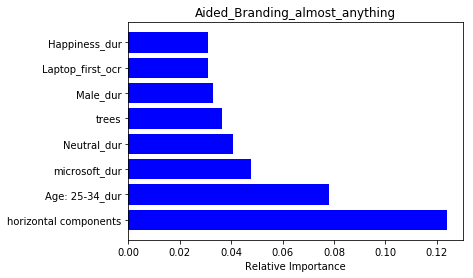

Brand_Cues_very_easily
Feature ranking:
soothing
Windows_last_ocr
microsoft_last_ocr
training
shopping
Laptop_total_ocr
Laptop_last_ocr
Age: 25-34_dur
Laptop_first_ocr
African_dur
carpet
Windows_first_ocr
metal
warm
microsoft_first_ocr
sports
Male_dur
Happiness_dur
vegetation
Neutral_dur
sunny
glass
glossy
Dell_text_dur
reading
rugged scene
microsoft_dur
Laptop_dur
exercise
conducting business
Female_dur
Windows_dur
touring
Age: 15-24_dur
Sadness_dur
flowers
socializing
Hp_last_ocr
clouds
Hp_text_first_ocr
natural light
length_of_ad_15
Hp_first_ocr
studying
brick
scary
medical activity
Hp_dur
ocean
Hp_total_ocr
Eastasian_dur
plastic
Dell_dur
asphalt
horizontal components
Age: 35-44_dur
Hp_text_total_ocr
Lenovo_group_dur
Hp_text_dur
Yoga_dur
playing
aged
microsoft_total_ocr
sterile
Lenovo_text_dur
using tools
vertical components
transporting
fire
spectating
Hp_text_last_ocr
research
sand
congregating
HP_group_dur
cold
stressful
Dell_sub_brand_group_dur
Tablet_first_ocr
Tablet_total_ocr


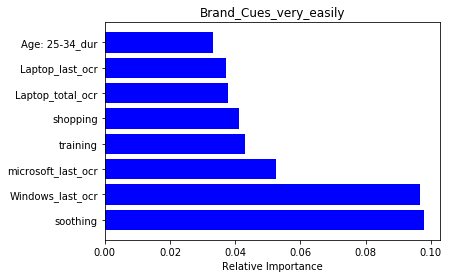

Brand_Appeal_more_appealing
Feature ranking:
Windows_last_ocr
microsoft_first_ocr
microsoft_last_ocr
training
metal
Windows_first_ocr
length_of_ad_15
Laptop_last_ocr
Lenovo_text_dur
Yoga_dur
warm
Laptop_total_ocr
Male_dur
Age: 35-44_dur
Lenovo_group_dur
Happiness_dur
Neutral_dur
aged
medical activity
soothing
Windows_total_ocr
still water
transporting
microsoft_dur
Hp_dur
cold
Hp_total_ocr
exercise
sand
Hp_last_ocr
carpet
reading
Windows_dur
sports
socializing
Laptop_dur
Female_dur
fire
sunny
Age: 25-34_dur
Sadness_dur
conducting business
Eastasian_dur
touring
African_dur
Hp_text_first_ocr
Tablet_first_ocr
Age: 15-24_dur
microsoft_total_ocr
Laptop_first_ocr
dry
studying
Hp_text_last_ocr
research
Tablet_dur
brick
Asus_text_dur
spectating
sterile
stressful
Asus_dur
Dell_dur
moist
Hp_first_ocr
horizontal components
leaves
eating
ocean
flowers
congregating
using tools
Tablet_total_ocr
natural light
paper
ASUS T102_dur
wood
clouds
cluttered space
swimming
glass
waiting in line
railing
playi

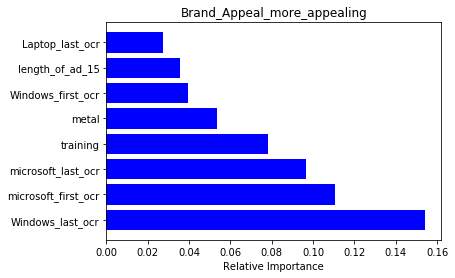

Understanding_very_easily
Feature ranking:
soothing
Male_dur
microsoft_last_ocr
metal
Windows_last_ocr
Female_dur
microsoft_first_ocr
microsoft_dur
sunny
Neutral_dur
Windows_first_ocr
congregating
microsoft_total_ocr
conducting business
transporting
Happiness_dur
studying
Hp_dur
Age: 25-34_dur
Laptop_total_ocr
Sadness_dur
Hp_last_ocr
Hp_first_ocr
stressful
Age: 15-24_dur
clouds
horizontal components
socializing
Laptop_dur
Hp_total_ocr
glass
exercise
Laptop_first_ocr
shopping
spectating
grass
Laptop_last_ocr
Windows_dur
vertical components
touring
African_dur
waiting in line
Hp_text_dur
sand
Eastasian_dur
matte
dry
length_of_ad_15
scary
Dell_text_dur
Windows_total_ocr
playing
training
sports
Age: 35-44_dur
aged
ocean
trees
sterile
brick
Hp_text_last_ocr
Hp_text_first_ocr
Asus_dur
Tablet_first_ocr
medical activity
research
reading
semi-enclosed area
cluttered space
Hp_text_total_ocr
foliage
using tools
vegetation
Surface_group_dur
carpet
warm
HP_group_dur
Lenovo_text_dur
paper
Tablet_las

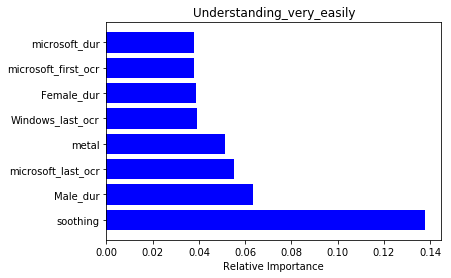

Relevance_Information_very_relevant
Feature ranking:
microsoft_last_ocr
Windows_last_ocr
microsoft_first_ocr
metal
Happiness_dur
medical activity
training
Windows_first_ocr
Age: 25-34_dur
Laptop_first_ocr
Neutral_dur
aged
Age: 35-44_dur
Laptop_total_ocr
exercise
Laptop_last_ocr
dry
length_of_ad_15
soothing
Laptop_dur
Male_dur
conducting business
studying
congregating
microsoft_dur
Windows_dur
Female_dur
stressful
Hp_text_total_ocr
ASUS T102_dur
African_dur
carpet
Eastasian_dur
Age: 15-24_dur
Lenovo_group_dur
Asus_text_dur
Windows_total_ocr
socializing
warm
glossy
clouds
playing
Hp_text_dur
sand
Hp_text_last_ocr
sunny
Asus_dur
horizontal components
spectating
research
microsoft_total_ocr
still water
Tablet_total_ocr
Hp_text_first_ocr
eating
Hp_last_ocr
Surface_group_dur
Hp_total_ocr
paper
matte
brick
Hp_dur
touring
flowers
boating
Sadness_dur
sports
driving
Hp_first_ocr
fire
Tablet_first_ocr
transporting
HP_group_dur
scary
reading
waiting in line
glass
Tablet_dur
gaming
Tablet_last_ocr


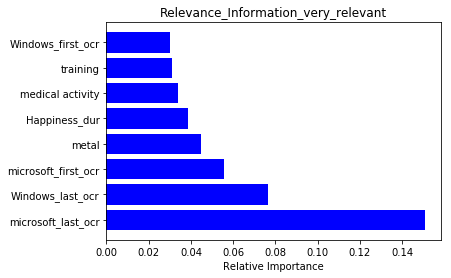

Credibility_Information_agree_strongly
Feature ranking:
microsoft_last_ocr
Laptop_last_ocr
microsoft_dur
training
Neutral_dur
Laptop_total_ocr
conducting business
warm
waiting in line
transporting
microsoft_first_ocr
Tablet_total_ocr
Windows_first_ocr
metal
Laptop_dur
sunny
touring
Happiness_dur
Windows_dur
Laptop_first_ocr
Tablet_dur
exercise
horizontal components
reading
Age: 15-24_dur
still water
soothing
Tablet_last_ocr
microsoft_total_ocr
Sadness_dur
Age: 25-34_dur
socializing
Female_dur
congregating
Lenovo_group_dur
clouds
studying
Hp_first_ocr
Hp_total_ocr
brick
Eastasian_dur
Tablet_first_ocr
Hp_last_ocr
African_dur
dry
Hp_dur
carpet
playing
medical activity
Windows_total_ocr
vegetation
Male_dur
ocean
Dell_sub_brand_group_dur
trees
Dell_text_dur
Windows_last_ocr
research
vertical components
foliage
eating
scary
sports
Hp_text_first_ocr
sterile
glass
Dell_dur
using tools
Age: 35-44_dur
stressful
Hp_text_total_ocr
Hp_text_dur
shopping
Hp_text_last_ocr
spectating
railing
paper
swim

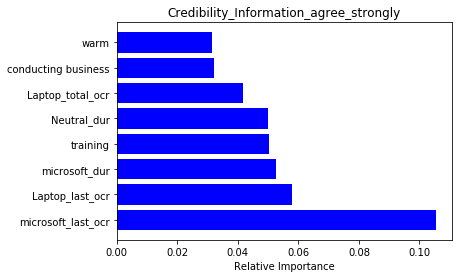

New_Information_alot
Feature ranking:
microsoft_last_ocr
Laptop_last_ocr
Windows_last_ocr
Laptop_total_ocr
Happiness_dur
soothing
microsoft_first_ocr
training
Windows_first_ocr
Age: 25-34_dur
metal
Lenovo_text_dur
Yoga_dur
length_of_ad_15
sand
Laptop_dur
carpet
reading
Tablet_total_ocr
exercise
sunny
shopping
Laptop_first_ocr
Hp_last_ocr
Eastasian_dur
Hp_total_ocr
Tablet_dur
Neutral_dur
microsoft_total_ocr
Lenovo_group_dur
aged
clouds
African_dur
Hp_dur
studying
Age: 15-24_dur
Age: 35-44_dur
fire
cold
Male_dur
Windows_dur
Female_dur
microsoft_dur
using tools
Tablet_last_ocr
horizontal components
transporting
asphalt
Sadness_dur
sterile
sports
brick
Surface_group_dur
conducting business
medical activity
stressful
Hp_text_last_ocr
driving
Dell_text_dur
Hp_first_ocr
Hp_text_dur
Hp_text_first_ocr
congregating
ocean
warm
dry
glass
cluttered space
spectating
Dell_sub_brand_group_dur
playing
Windows_total_ocr
plastic
natural light
matte
Hp_text_total_ocr
research
flowers
Tablet_first_ocr
rugg

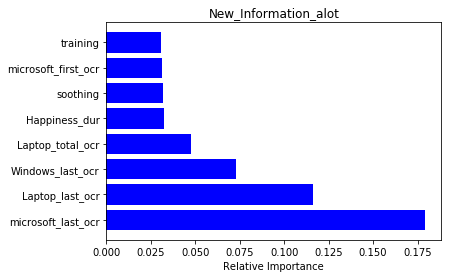

Brand_Difference_strongly
Feature ranking:
Laptop_last_ocr
microsoft_last_ocr
Age: 25-34_dur
microsoft_first_ocr
training
touring
Windows_last_ocr
metal
African_dur
Neutral_dur
Age: 15-24_dur
cold
Dell_text_dur
conducting business
Laptop_dur
Sadness_dur
Windows_first_ocr
Laptop_total_ocr
Happiness_dur
sports
glossy
Male_dur
Hp_text_dur
exercise
cluttered space
aged
reading
carpet
Eastasian_dur
sunny
Laptop_first_ocr
Hp_last_ocr
soothing
brick
microsoft_dur
paper
horizontal components
Hp_total_ocr
Tablet_total_ocr
Hp_first_ocr
microsoft_total_ocr
Tablet_dur
spectating
Dell_dur
Tablet_last_ocr
Surface_group_dur
shopping
rugged scene
asphalt
dry
HP_group_dur
Female_dur
vegetation
socializing
Age: 35-44_dur
waiting in line
vertical components
Windows_dur
Hp_dur
length_of_ad_15
Hp_text_first_ocr
warm
Windows_total_ocr
Yoga_dur
scary
playing
ocean
Hp_text_last_ocr
sterile
dirty
studying
glass
symmetrical
transporting
clouds
research
Tablet_first_ocr
Lenovo_group_dur
using tools
Lenovo_text_d

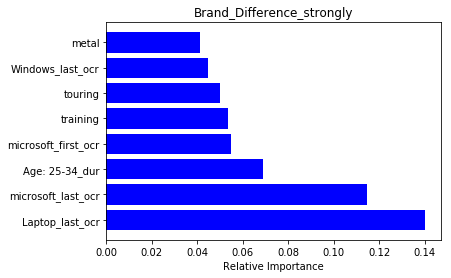

In [25]:
imp_features_rf = model.plot_feature_importance(models_27,10,y_train_27.columns,X_train_27.columns,savefig=False)

In [26]:
for i in range(len(y_test_27.columns)):
    acc_df.iloc[2:,i]= imp_features_rf[i,:10]

In [27]:
acc_df.to_excel('acc_df_software.xlsx')

In [33]:
len(y_train_27.columns)

26

In [28]:
from tqdm import tqdm 
shap.initjs()

In [29]:
explainer=[]
shap_values=[]
for i in tqdm(range(26)):
    explainer.append(shap.TreeExplainer(models_27[i]))
    shap_values.append(explainer[-1].shap_values(X_train_27))
    print(i)

  4%|▍         | 1/26 [00:03<01:35,  3.83s/it]

0


  8%|▊         | 2/26 [00:17<02:42,  6.76s/it]

1


 15%|█▌        | 4/26 [00:39<03:29,  9.51s/it]

2
3


 19%|█▉        | 5/26 [00:48<03:17,  9.41s/it]

4


 27%|██▋       | 7/26 [01:15<03:35, 11.32s/it]

5
6


 31%|███       | 8/26 [01:23<03:09, 10.54s/it]

7


 35%|███▍      | 9/26 [01:30<02:39,  9.40s/it]

8


 38%|███▊      | 10/26 [01:34<02:03,  7.69s/it]

9


 46%|████▌     | 12/26 [02:03<02:29, 10.68s/it]

10
11


 50%|█████     | 13/26 [02:14<02:22, 10.98s/it]

12


 54%|█████▍    | 14/26 [02:40<03:04, 15.34s/it]

13


 58%|█████▊    | 15/26 [02:49<02:28, 13.49s/it]

14


 62%|██████▏   | 16/26 [03:19<03:05, 18.53s/it]

15


 65%|██████▌   | 17/26 [03:44<03:04, 20.48s/it]

16


 69%|██████▉   | 18/26 [04:06<02:46, 20.78s/it]

17


 73%|███████▎  | 19/26 [04:26<02:24, 20.59s/it]

18


 77%|███████▋  | 20/26 [04:48<02:05, 20.97s/it]

19


 81%|████████  | 21/26 [05:10<01:47, 21.46s/it]

20


 85%|████████▍ | 22/26 [05:33<01:26, 21.74s/it]

21


 88%|████████▊ | 23/26 [05:55<01:05, 21.73s/it]

22


 92%|█████████▏| 24/26 [06:18<00:44, 22.13s/it]

23


 96%|█████████▌| 25/26 [06:39<00:21, 21.97s/it]

24


100%|██████████| 26/26 [07:02<00:00, 22.31s/it]

25


In [30]:
import matplotlib.pyplot as plt

100%|██████████| 26/26 [00:14<00:00,  1.72it/s]


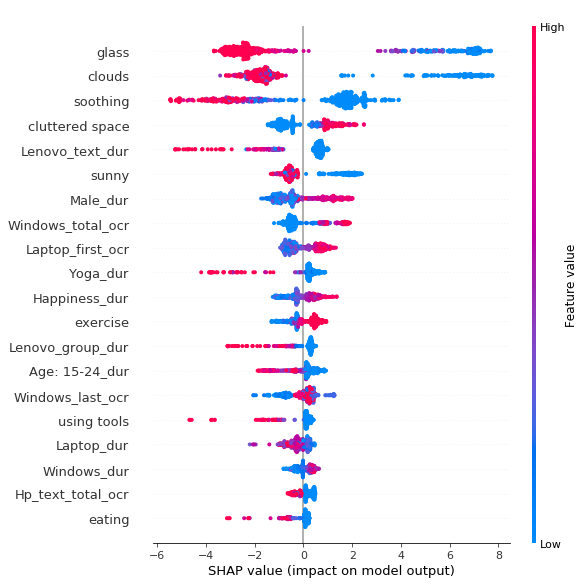

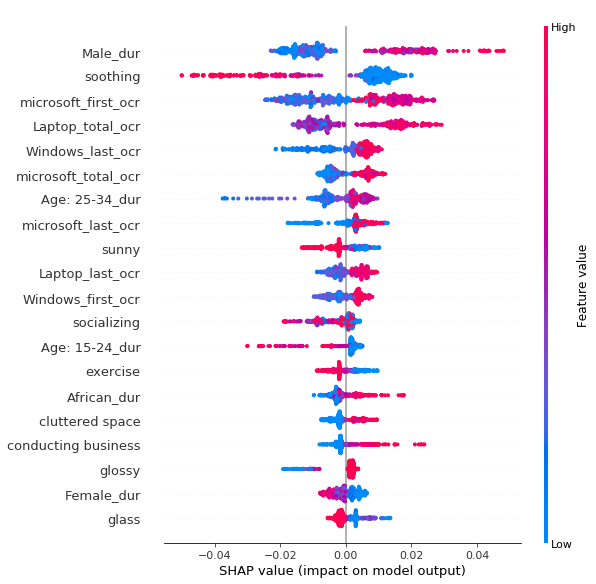

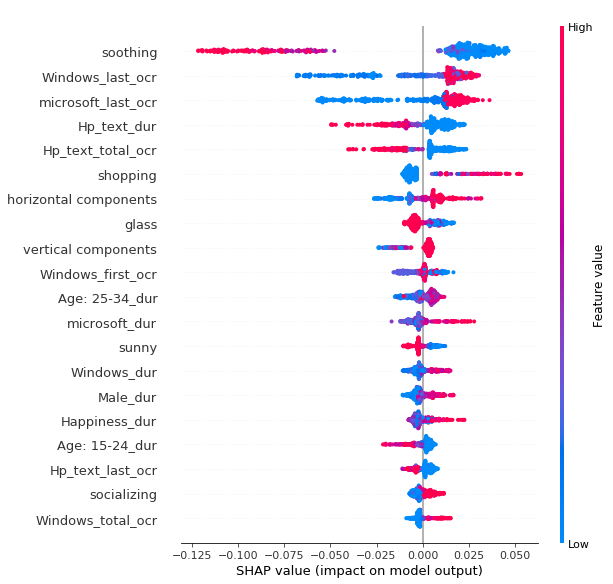

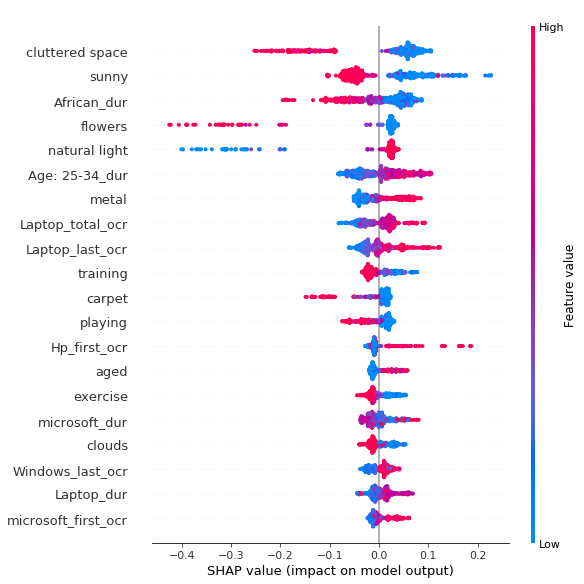

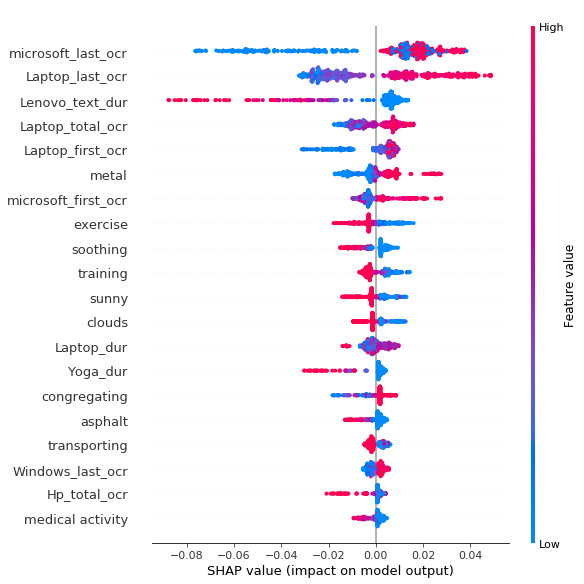

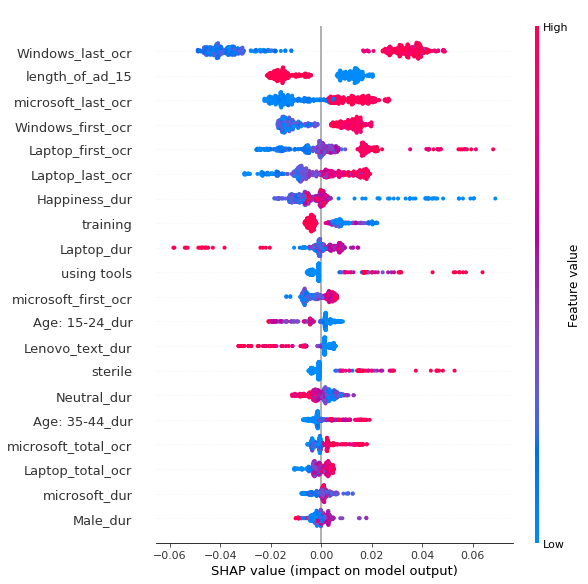

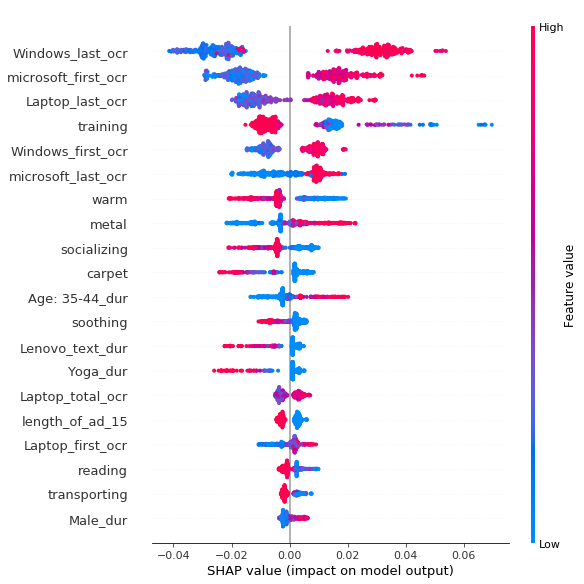

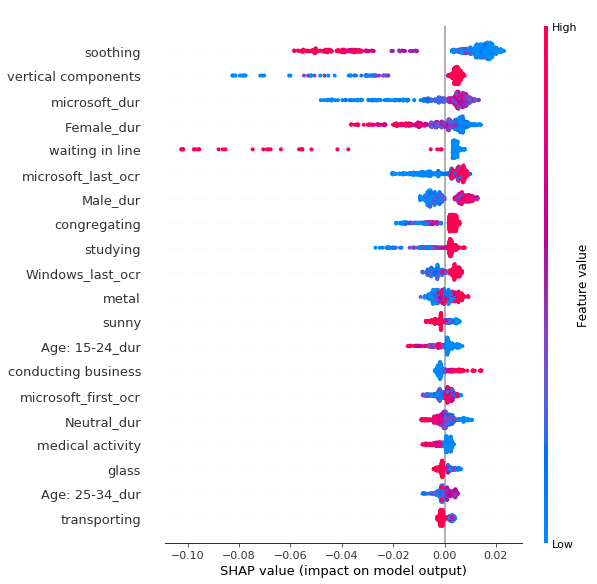

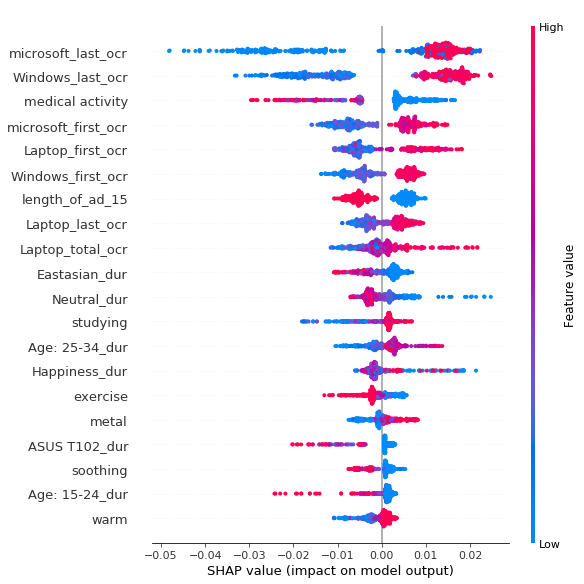

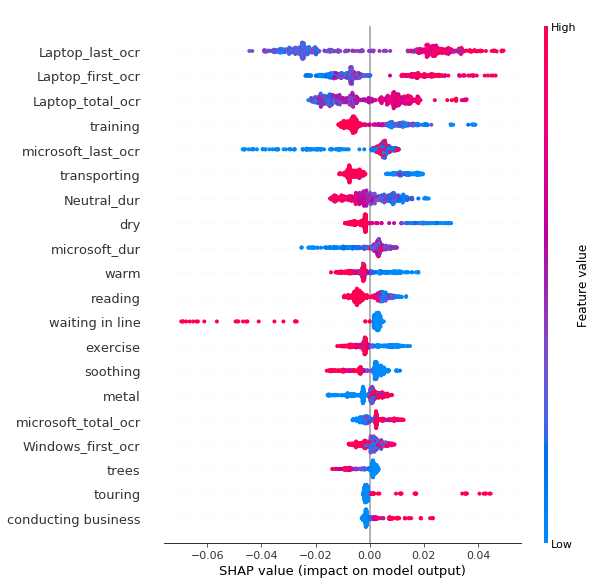

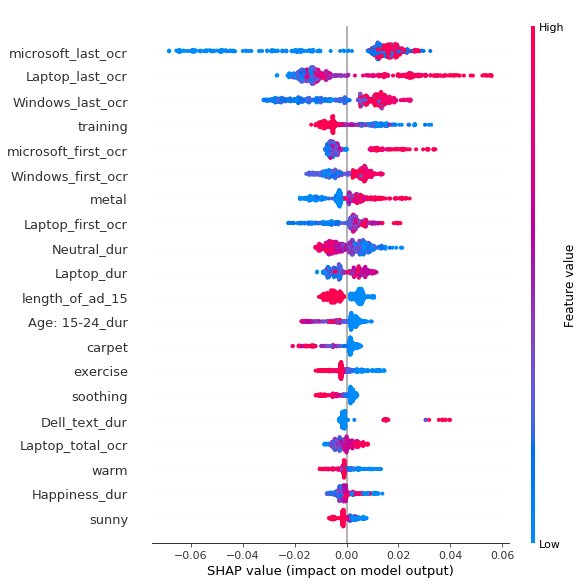

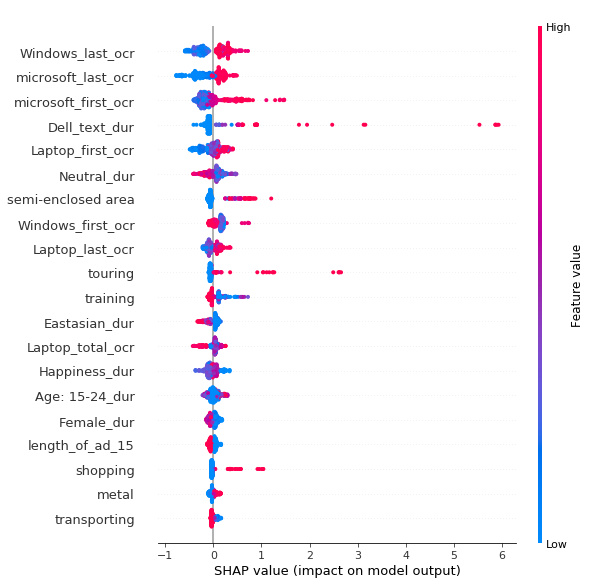

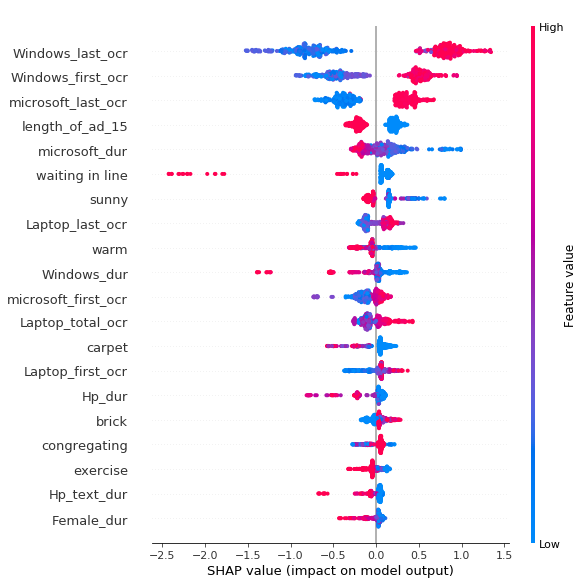

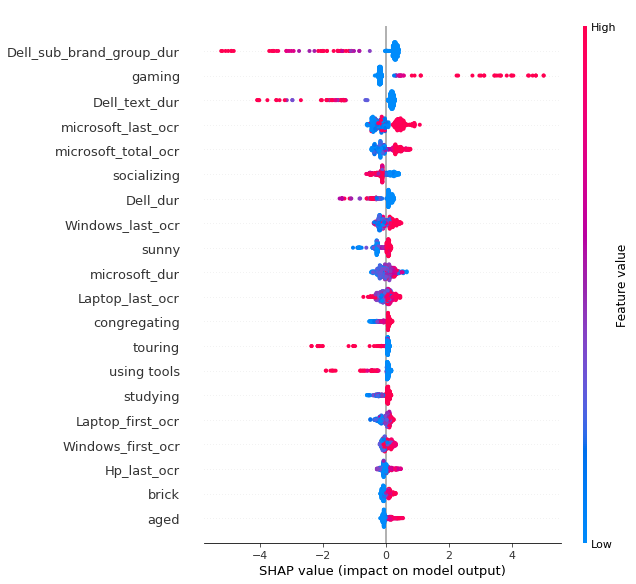

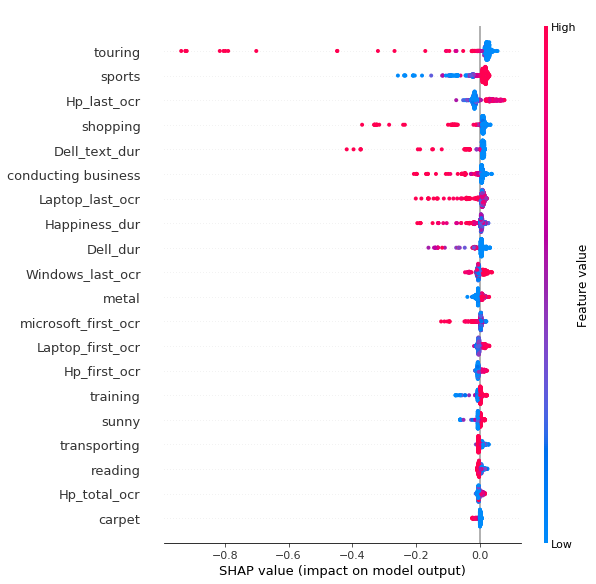

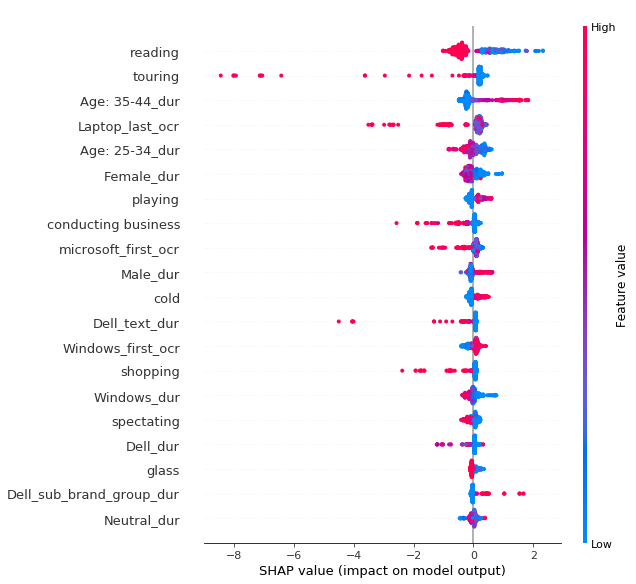

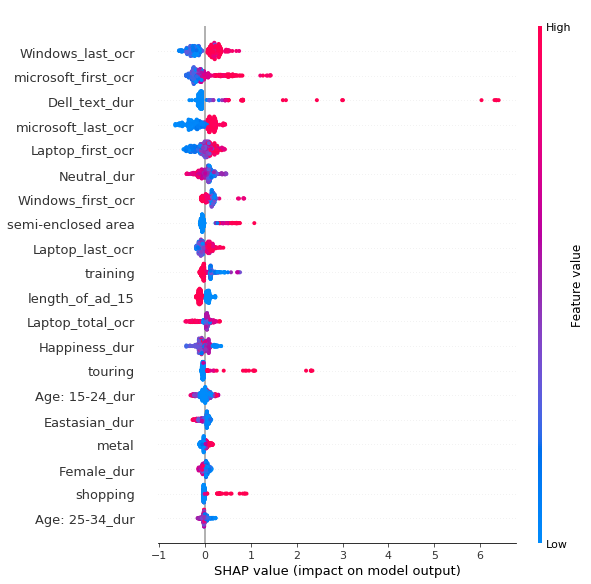

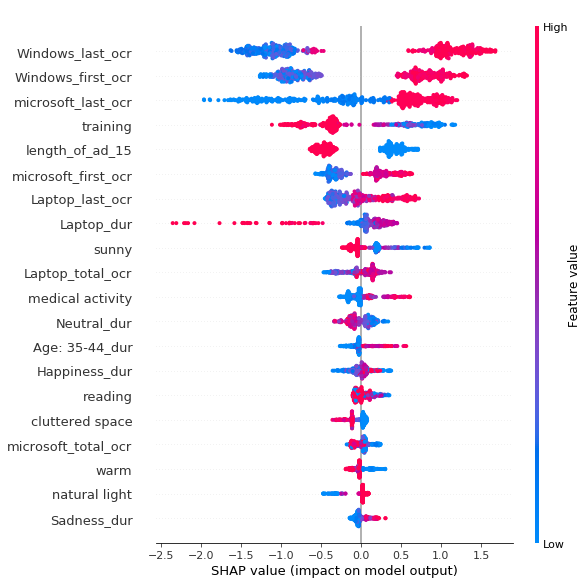

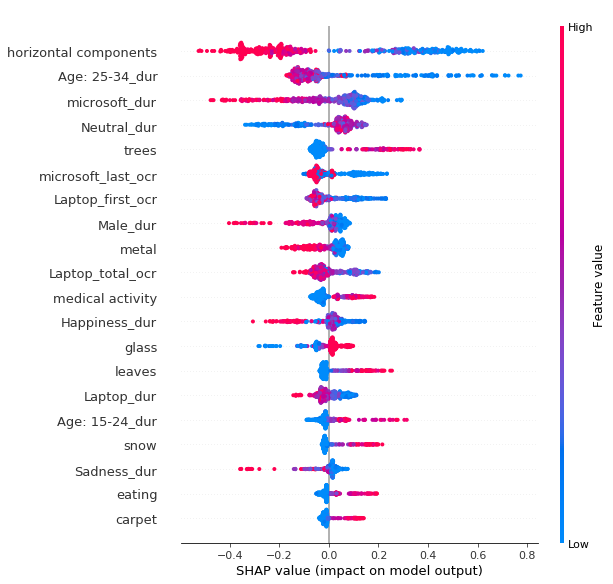

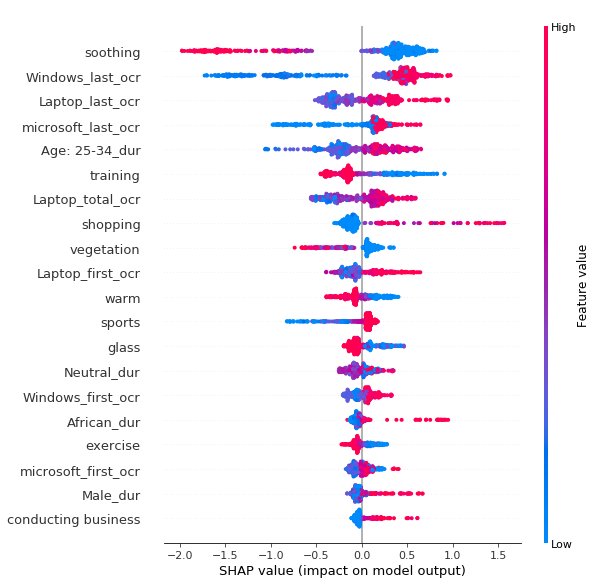

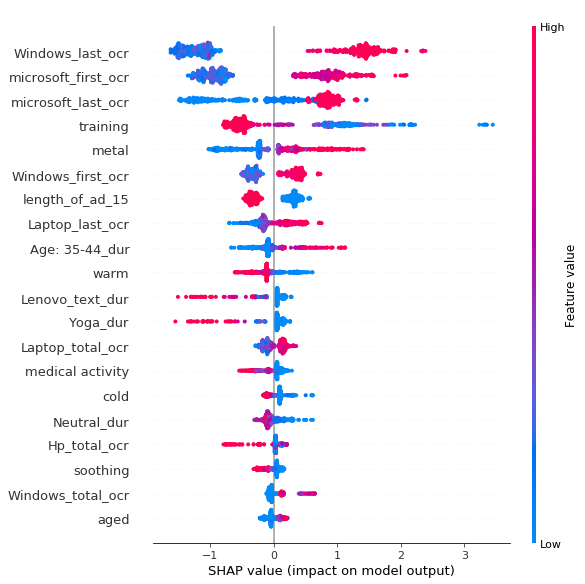

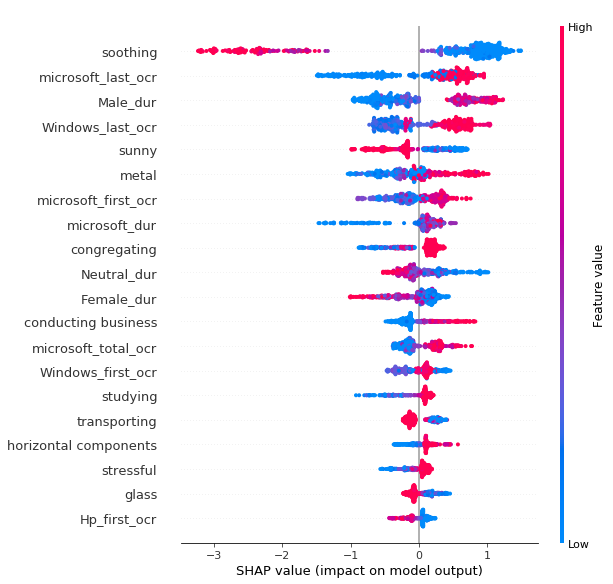

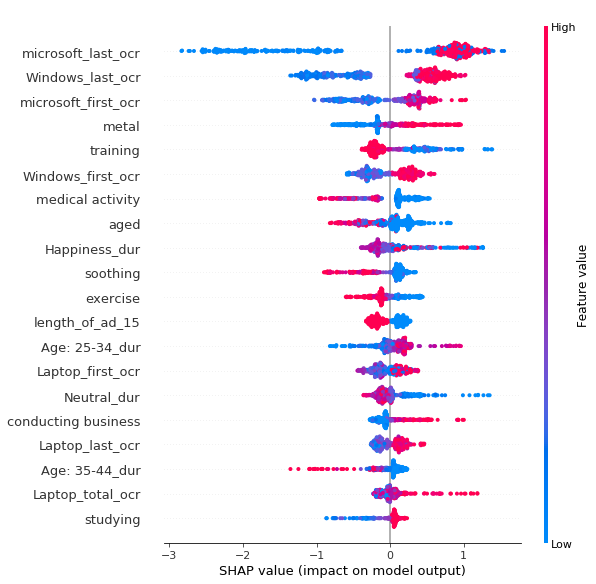

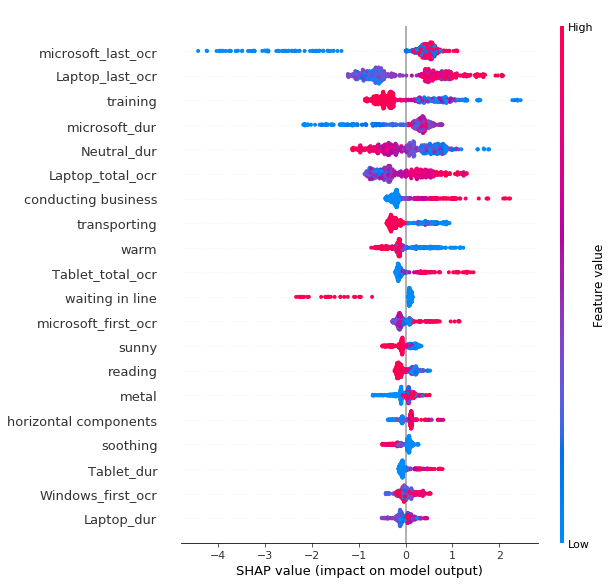

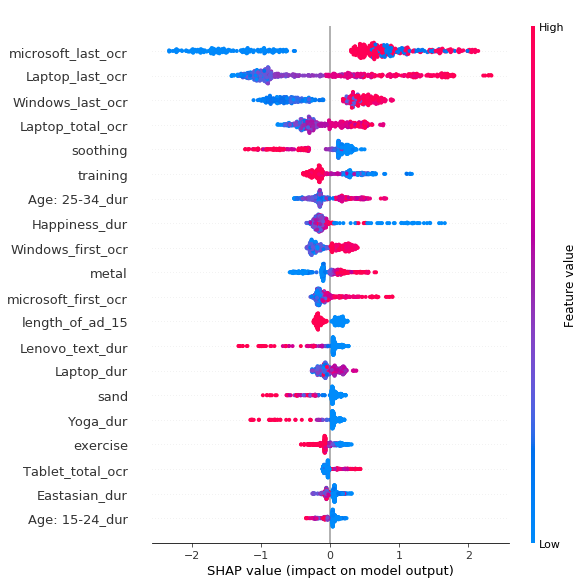

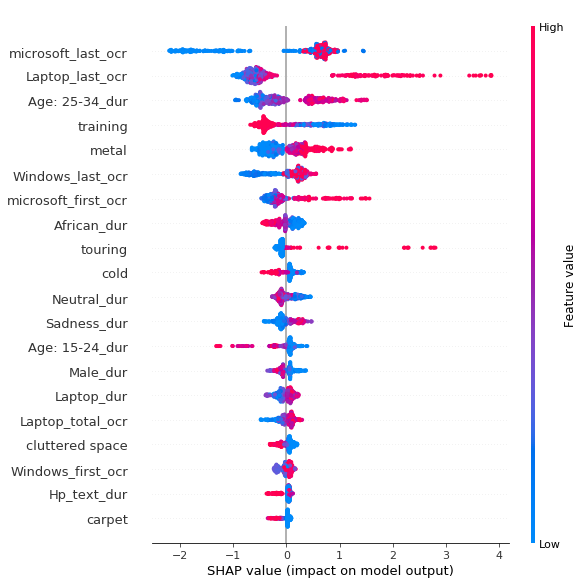

In [31]:
for i in tqdm(range(26)):
    plt.figure()
    shap.summary_plot(shap_values[i],X_train_27,show=False)
    plt.savefig('./Version_6/Software/shap_rf/'+y_train_27.columns[i]+'.png',bbox_inches='tight')

## XGB Model

In [32]:
model_xgb = Model('xgb')
print("------------------------ 17 XGB Models Training ----------------------------\n")
models_xgb_27,acc_df_xgb = model_xgb.train(X_train_27,y_train_27,X_test_27,y_test_27,metrics='r2',plot_error=False)

------------------------ 17 XGB Models Training ----------------------------

Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


For training set
r2_score: 0.986650
For test set
r2_score: 0.990775


Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


For training set
r2_score: 0.964540
For test set
r2_score: 0.985073


Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


For training set
r2_score: 0.976293
For test set
r2_score: 0.983869


Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


For training set
r2_score: 0.976539
For test set
r2_score: 0.978283


New_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


For training set
r2_score: 0.982621
For test set
r2_score: 0.987360


Enjoyment__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


For training set
r2_score: 0.968533
For test set
r2_score: 0.980255


Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.9s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


For training set
r2_score: 0.984307
For test set
r2_score: 0.989154


Understanding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.7s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


For training set
r2_score: 0.974451
For test set
r2_score: 0.984411


Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


For training set
r2_score: 0.964664
For test set
r2_score: 0.969821


Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


For training set
r2_score: 0.976350
For test set
r2_score: 0.985459


Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


For training set
r2_score: 0.976256
For test set
r2_score: 0.980141


Interest_peak


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


For training set
r2_score: 0.946241
For test set
r2_score: 0.920764


Interest_mean_score


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


For training set
r2_score: 0.980570
For test set
r2_score: 0.984176


Purchase_intent


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


For training set
r2_score: 0.959136
For test set
r2_score: 0.977816


Persuasion_mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


For training set
r2_score: 0.926512
For test set
r2_score: 0.948903


Persuasion_very_likely


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.9s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


For training set
r2_score: 0.935154
For test set
r2_score: 0.931935


Interest_peak_frames


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


For training set
r2_score: 0.956617
For test set
r2_score: 0.945781


Enjoyment_vey_much


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


For training set
r2_score: 0.987853
For test set
r2_score: 0.985602


Aided_Branding_almost_anything


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


For training set
r2_score: 0.962532
For test set
r2_score: 0.969735


Brand_Cues_very_easily


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


For training set
r2_score: 0.971417
For test set
r2_score: 0.983693


Brand_Appeal_more_appealing


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


For training set
r2_score: 0.986824
For test set
r2_score: 0.990163


Understanding_very_easily


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


For training set
r2_score: 0.970872
For test set
r2_score: 0.980956


Relevance_Information_very_relevant


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


For training set
r2_score: 0.968418
For test set
r2_score: 0.973656


Credibility_Information_agree_strongly


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


For training set
r2_score: 0.972150
For test set
r2_score: 0.977975


New_Information_alot


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


For training set
r2_score: 0.982352
For test set
r2_score: 0.988607


Brand_Difference_strongly


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


For training set
r2_score: 0.975912
For test set
r2_score: 0.980677




Unaided_Branding
clouds
glass
soothing
cluttered space
sunny
sterile
using tools
Yoga_dur
Hp_text_total_ocr
Hp_text_dur
transporting
Lenovo_text_dur
natural
length_of_ad_15
eating
camping
vertical components
Windows_total_ocr
touring
exercise
semi-enclosed area
far-away horizon
driving
Asus_text_dur
natural light
fire
Dell_sub_brand_group_dur
matte
ASUS T102_dur
hiking
Windows_last_ocr
Lenovo_group_dur
Laptop_first_ocr
Male_dur
climbing
Hp_text_first_ocr
Hp_last_ocr
Hp_text_last_ocr
sand
grass
Laptop_dur
studying
sports
Surface_group_dur
wood
stressful
Laptop_last_ocr
tiles
Windows_first_ocr
training
ice
Age: 15-24_dur
horizontal components
Tablet_dur
HP_group_dur
Tablet_last_ocr
Hp_dur
leaves
cold
warm
socializing
metal
spectating
Hp_total_ocr
Happiness_dur
Laptop_total_ocr
microsoft_last_ocr
paper
Windows_dur
microsoft_first_ocr
Tablet_total_ocr
Dell_dur
playing
Tablet_first_ocr
symmetrical
conducting business
Age: 35-44_dur
reading
microsoft_total_ocr
Asus_dur
Neutral_dur
foliage
re

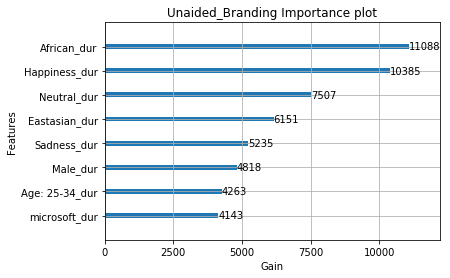

Brand_Cues__Mean
glossy
soothing
Asus_text_dur
rugged scene
sunny
medical activity
Laptop_total_ocr
microsoft_total_ocr
Male_dur
waiting in line
socializing
vertical components
natural
Windows_last_ocr
ASUS T102_dur
glass
microsoft_first_ocr
metal
shopping
Asus_dur
far-away horizon
Female_dur
microsoft_last_ocr
plastic
still water
scary
Age: 15-24_dur
swimming
length_of_ad_15
Laptop_first_ocr
moist
carpet
tiles
conducting business
exercise
sand
transporting
Laptop_last_ocr
touring
studying
congregating
Lenovo_text_dur
clouds
warm
training
reading
Yoga_dur
Tablet_total_ocr
foliage
pavement
Tablet_last_ocr
sports
sterile
cluttered space
diving
African_dur
Age: 25-34_dur
using tools
eating
microsoft_dur
HP_group_dur
stressful
Tablet_first_ocr
boating
Windows_first_ocr
Hp_last_ocr
leaves
natural light
Tablet_dur
research
Hp_dur
fire
Hp_first_ocr
Sadness_dur
Hp_text_total_ocr
Laptop_dur
vegetation
aged
Dell_sub_brand_group_dur
cold
Windows_total_ocr
ocean
snow
Hp_text_first_ocr
shrubbery
Ha

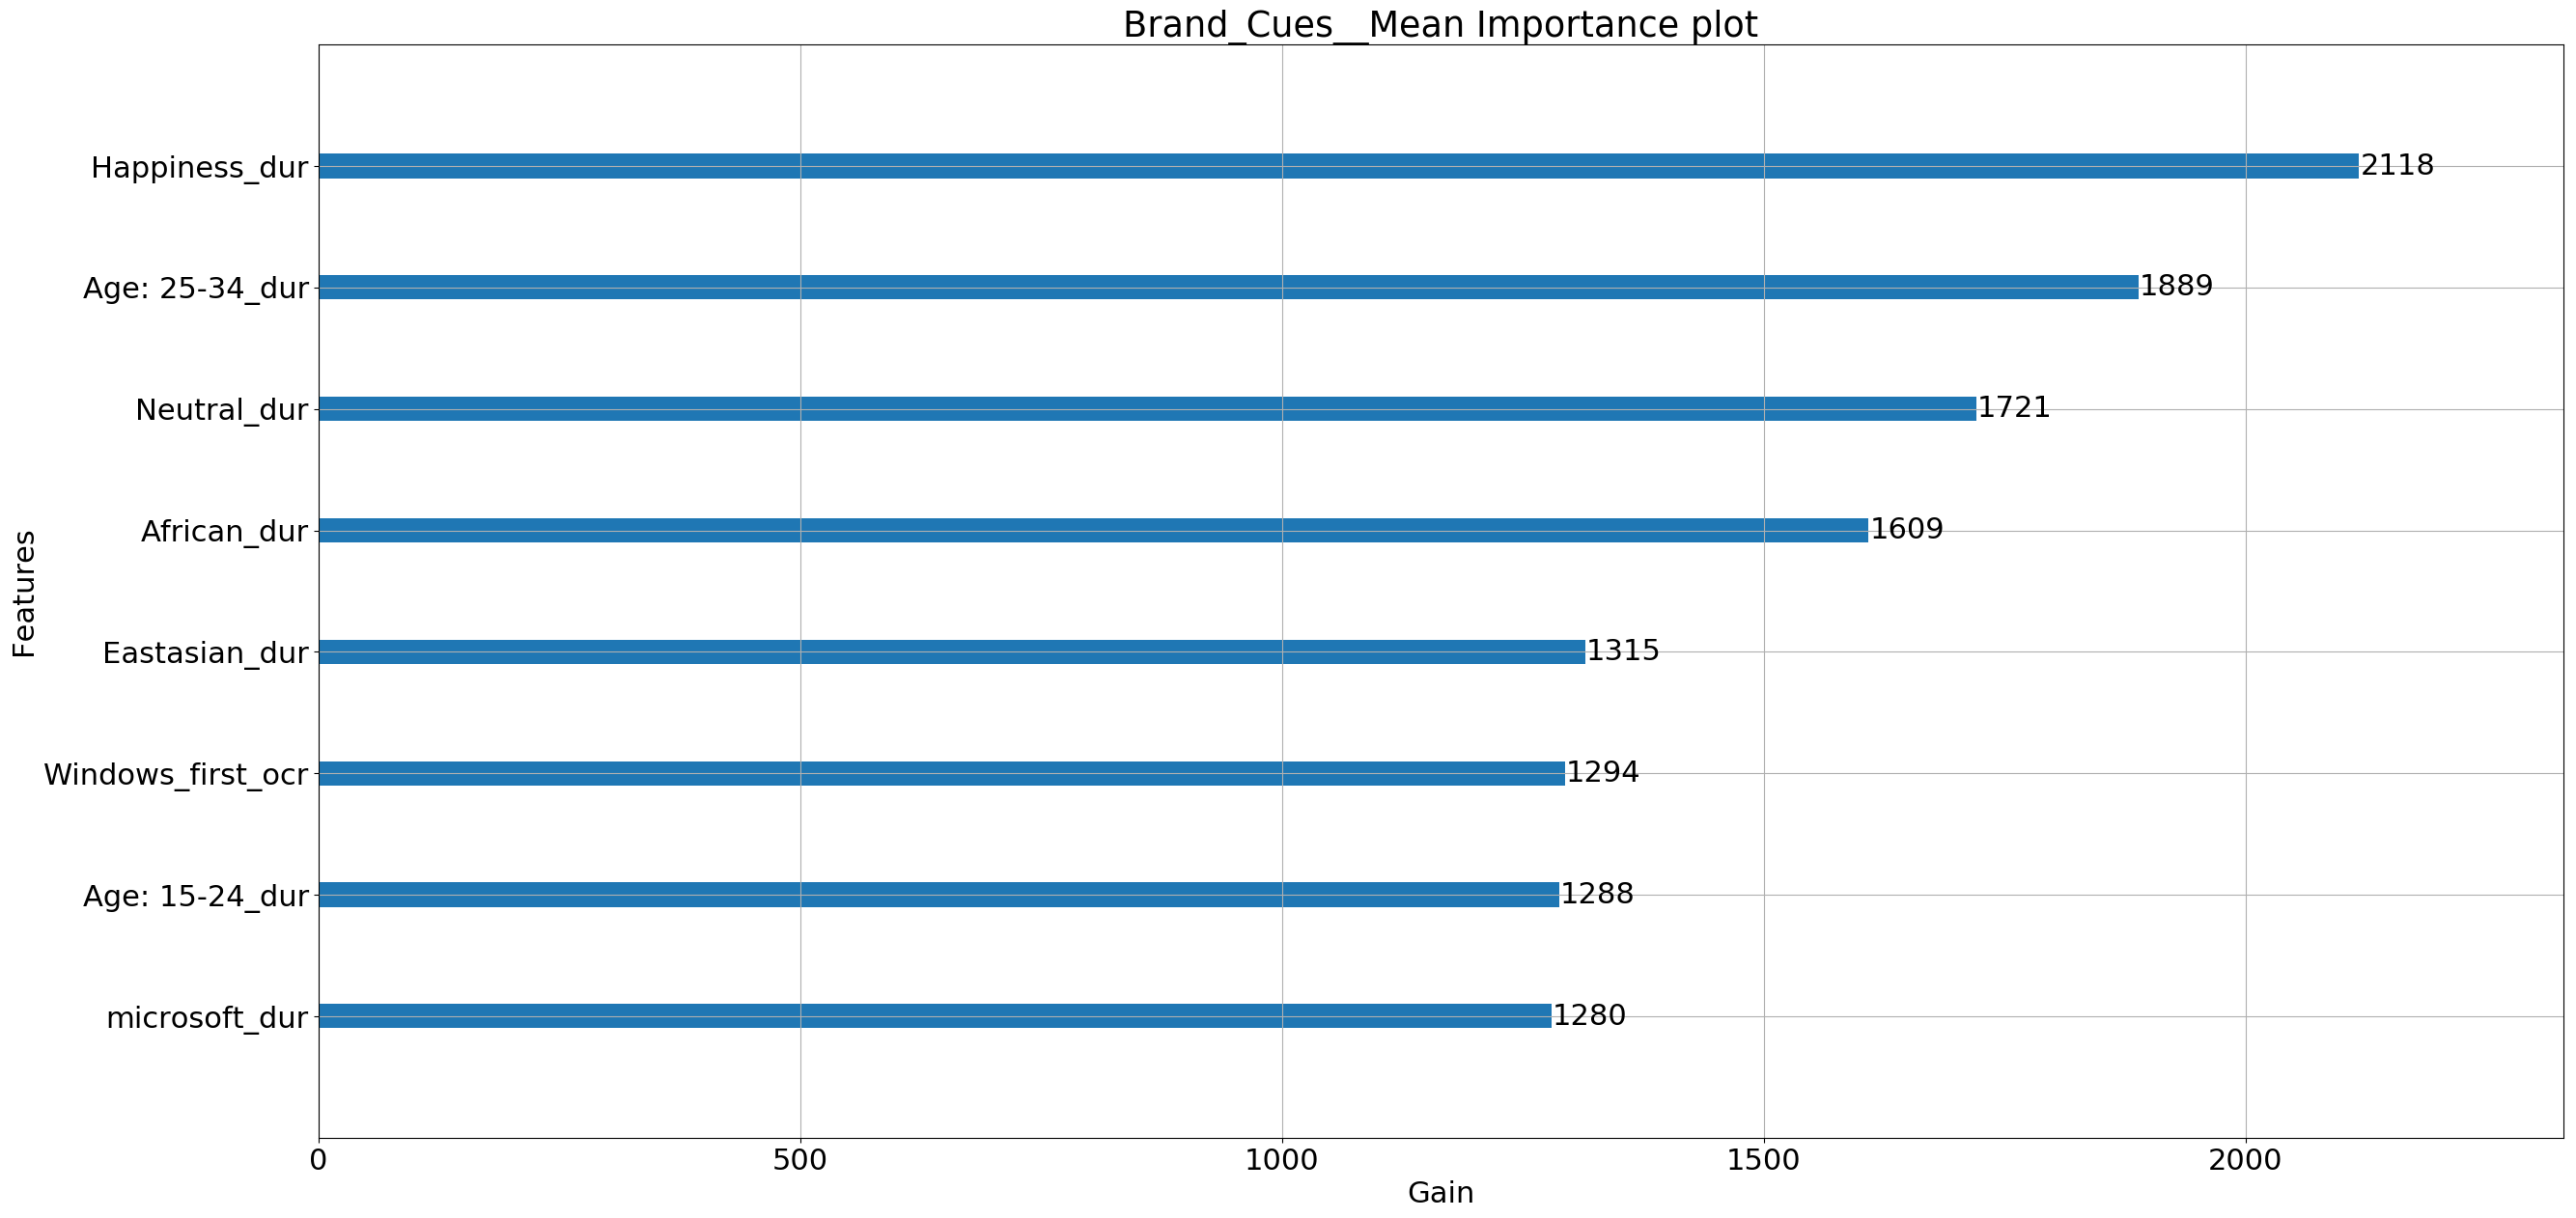

Aided_Branding__Mean
soothing
vertical components
rugged scene
glass
Windows_last_ocr
glossy
sunny
clouds
shopping
length_of_ad_15
microsoft_last_ocr
Hp_text_total_ocr
Asus_text_dur
horizontal components
Hp_text_dur
metal
stressful
Age: 15-24_dur
sports
ASUS T102_dur
Yoga_dur
Hp_text_last_ocr
Hp_text_first_ocr
dry
gaming
fire
aged
symmetrical
touring
Lenovo_text_dur
waiting in line
Windows_first_ocr
conducting business
Windows_total_ocr
vegetation
diving
Male_dur
microsoft_first_ocr
Age: 25-34_dur
boating
congregating
ocean
asphalt
plastic
matte
Age: 35-44_dur
carpet
spectating
socializing
Laptop_dur
tiles
leaves
Windows_dur
cold
sand
Tablet_total_ocr
driving
medical activity
Dell_text_dur
Lenovo_group_dur
Tablet_dur
brick
trees
Asus_dur
sterile
still water
microsoft_dur
Happiness_dur
Laptop_total_ocr
using tools
wood
Tablet_first_ocr
Laptop_last_ocr
training
Neutral_dur
Hp_last_ocr
dirt
Tablet_last_ocr
playing
research
Hp_first_ocr
scary
Sadness_dur
microsoft_total_ocr
Laptop_first_oc

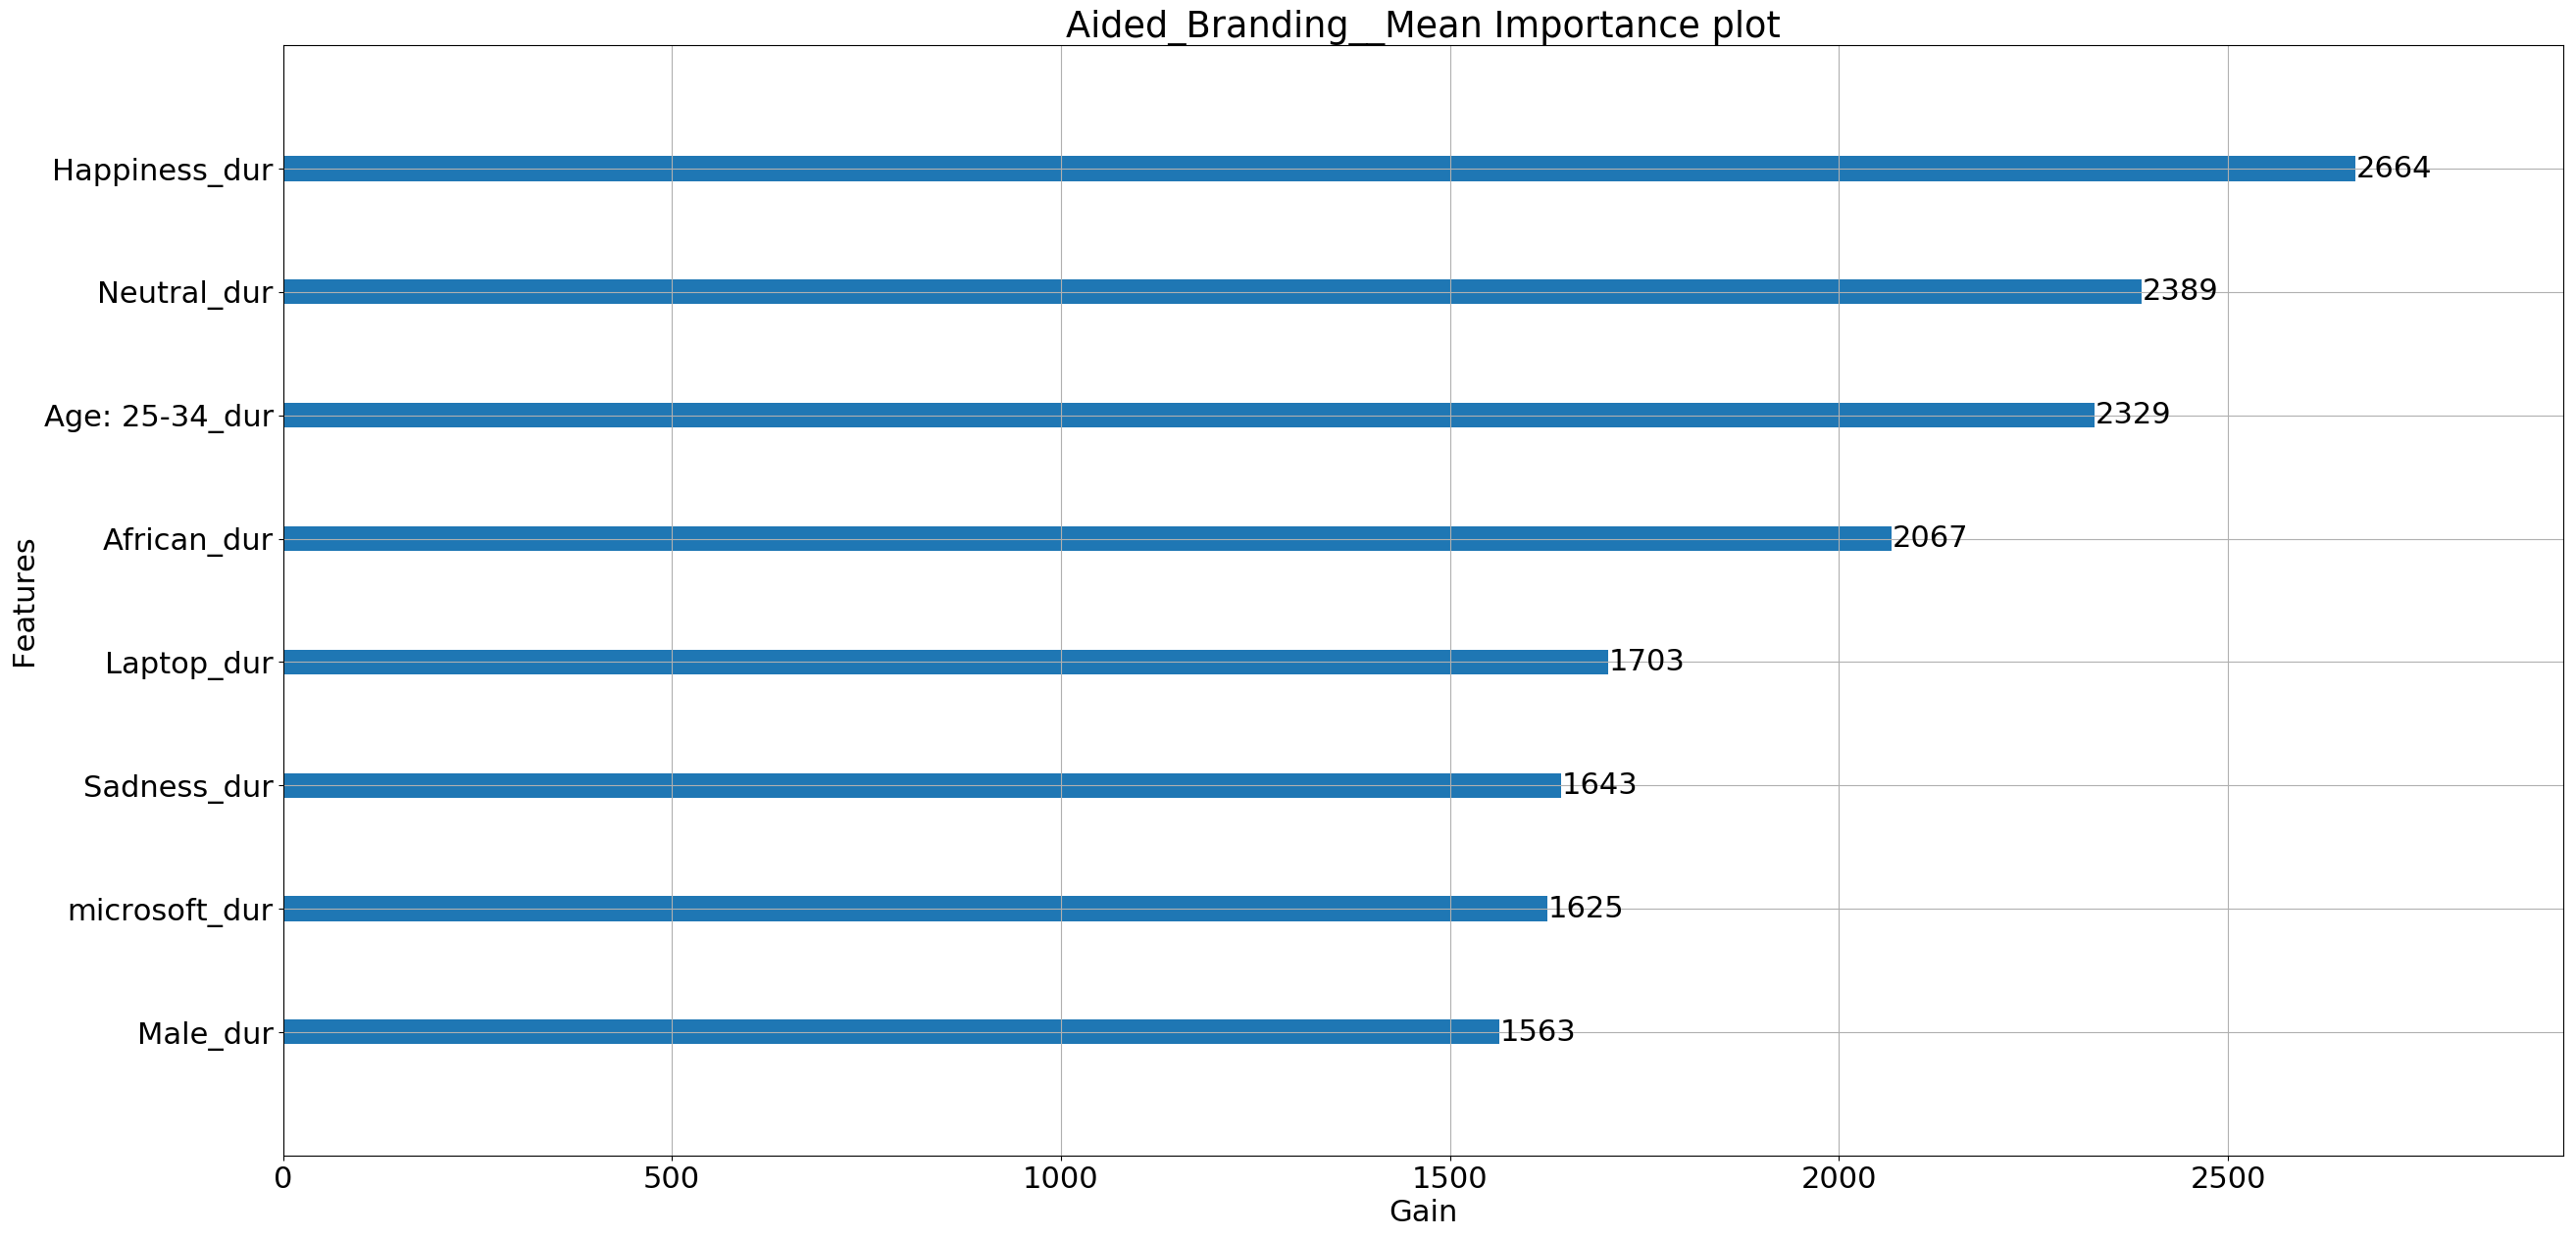

Active_Involvement__Mean
natural light
flowers
cluttered space
sunny
vertical components
metal
touring
clouds
carpet
Lenovo_text_dur
waiting in line
asphalt
Tablet_total_ocr
Laptop_last_ocr
medical activity
training
exercise
driving
Hp_text_total_ocr
Hp_first_ocr
shopping
congregating
Laptop_dur
Yoga_dur
Laptop_total_ocr
Hp_text_dur
Lenovo_group_dur
Tablet_last_ocr
aged
Age: 25-34_dur
Age: 35-44_dur
boating
soothing
glossy
rugged scene
microsoft_dur
semi-enclosed area
Tablet_dur
stressful
studying
playing
Dell_text_dur
Windows_last_ocr
microsoft_last_ocr
glass
African_dur
Windows_dur
dry
symmetrical
spectating
research
paper
ocean
Laptop_first_ocr
Hp_last_ocr
matte
Windows_first_ocr
sterile
microsoft_total_ocr
horizontal components
microsoft_first_ocr
Age: 15-24_dur
reading
Hp_total_ocr
Tablet_first_ocr
brick
Surface_group_dur
gaming
Dell_sub_brand_group_dur
Hp_text_last_ocr
transporting
swimming
Female_dur
scary
Male_dur
Sadness_dur
using tools
Neutral_dur
foliage
cold
Hp_dur
socializ

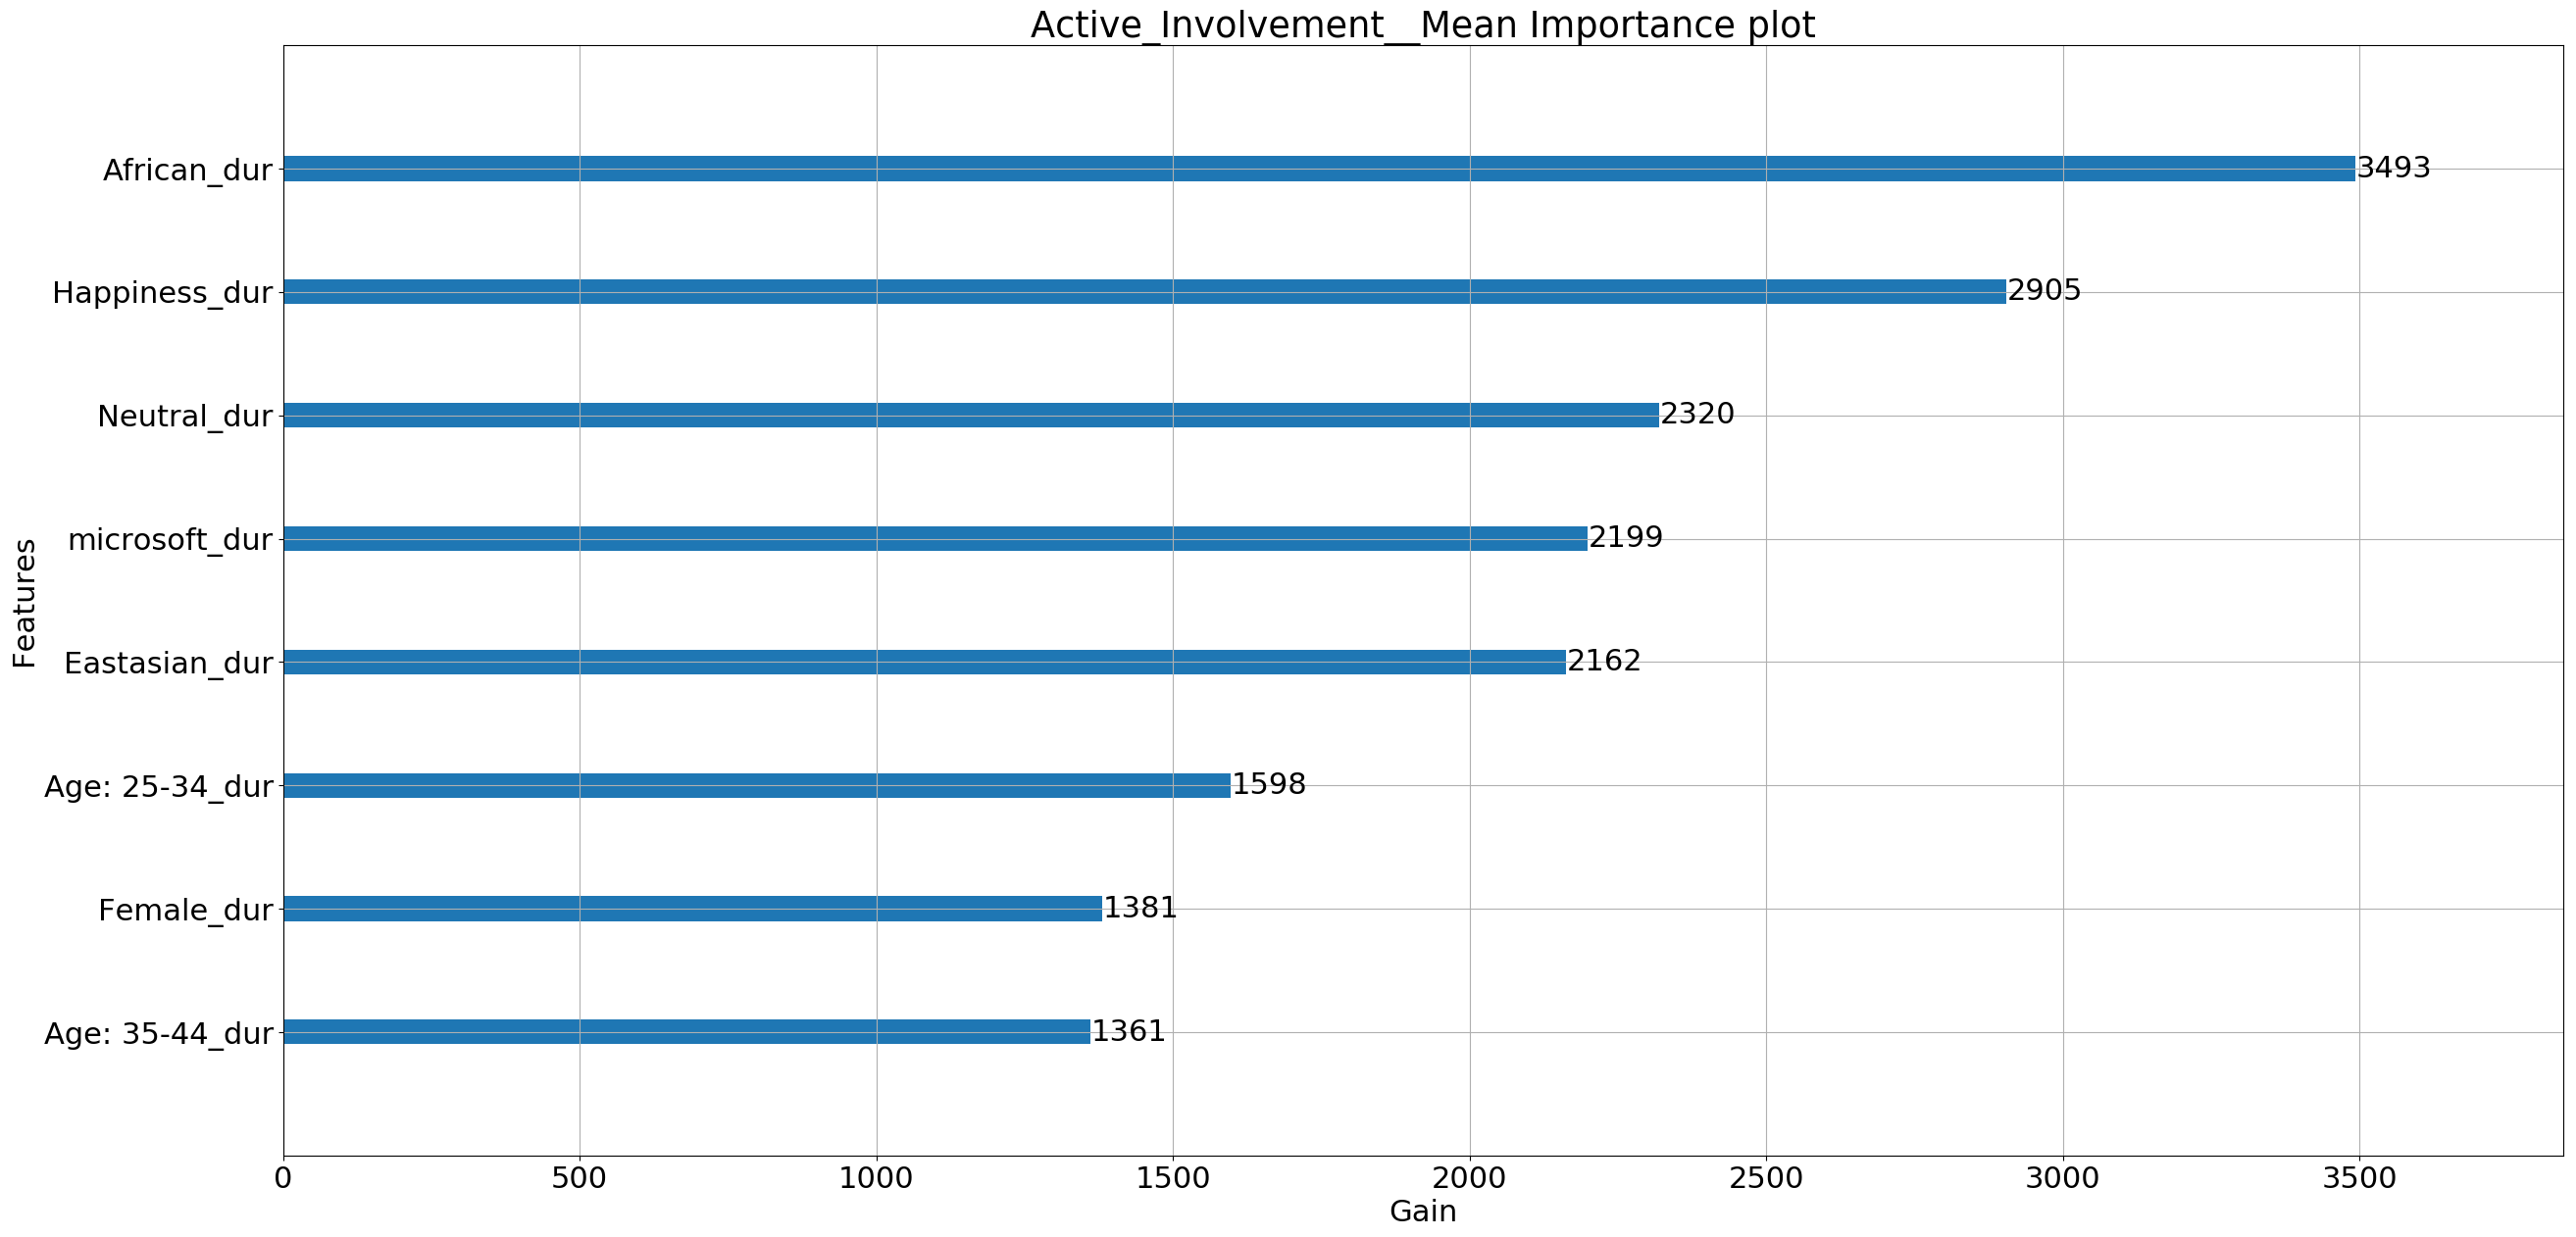

New_Information__Mean
pavement
waiting in line
Lenovo_text_dur
rugged scene
shrubbery
diving
biking
Laptop_last_ocr
soothing
microsoft_last_ocr
Yoga_dur
training
Laptop_total_ocr
swimming
Laptop_first_ocr
sunny
fire
transporting
congregating
driving
natural light
carpet
socializing
metal
flowers
leaves
medical activity
exercise
wood
glossy
Laptop_dur
trees
still water
Lenovo_group_dur
boating
touring
vertical components
shopping
studying
asphalt
microsoft_total_ocr
Dell_dur
clouds
matte
Neutral_dur
snow
microsoft_first_ocr
sterile
railing
Hp_text_dur
warm
Tablet_dur
Hp_total_ocr
sports
ASUS T102_dur
Tablet_total_ocr
cold
Windows_last_ocr
sand
Hp_dur
Age: 35-44_dur
Asus_text_dur
vegetation
brick
Happiness_dur
Hp_last_ocr
glass
eating
Tablet_first_ocr
reading
dry
aged
plastic
Windows_first_ocr
Male_dur
microsoft_dur
ocean
stressful
hiking
grass
Hp_first_ocr
Tablet_last_ocr
Hp_text_first_ocr
scary
horizontal components
Female_dur
conducting business
Age: 15-24_dur
length_of_ad_15
Sadness_

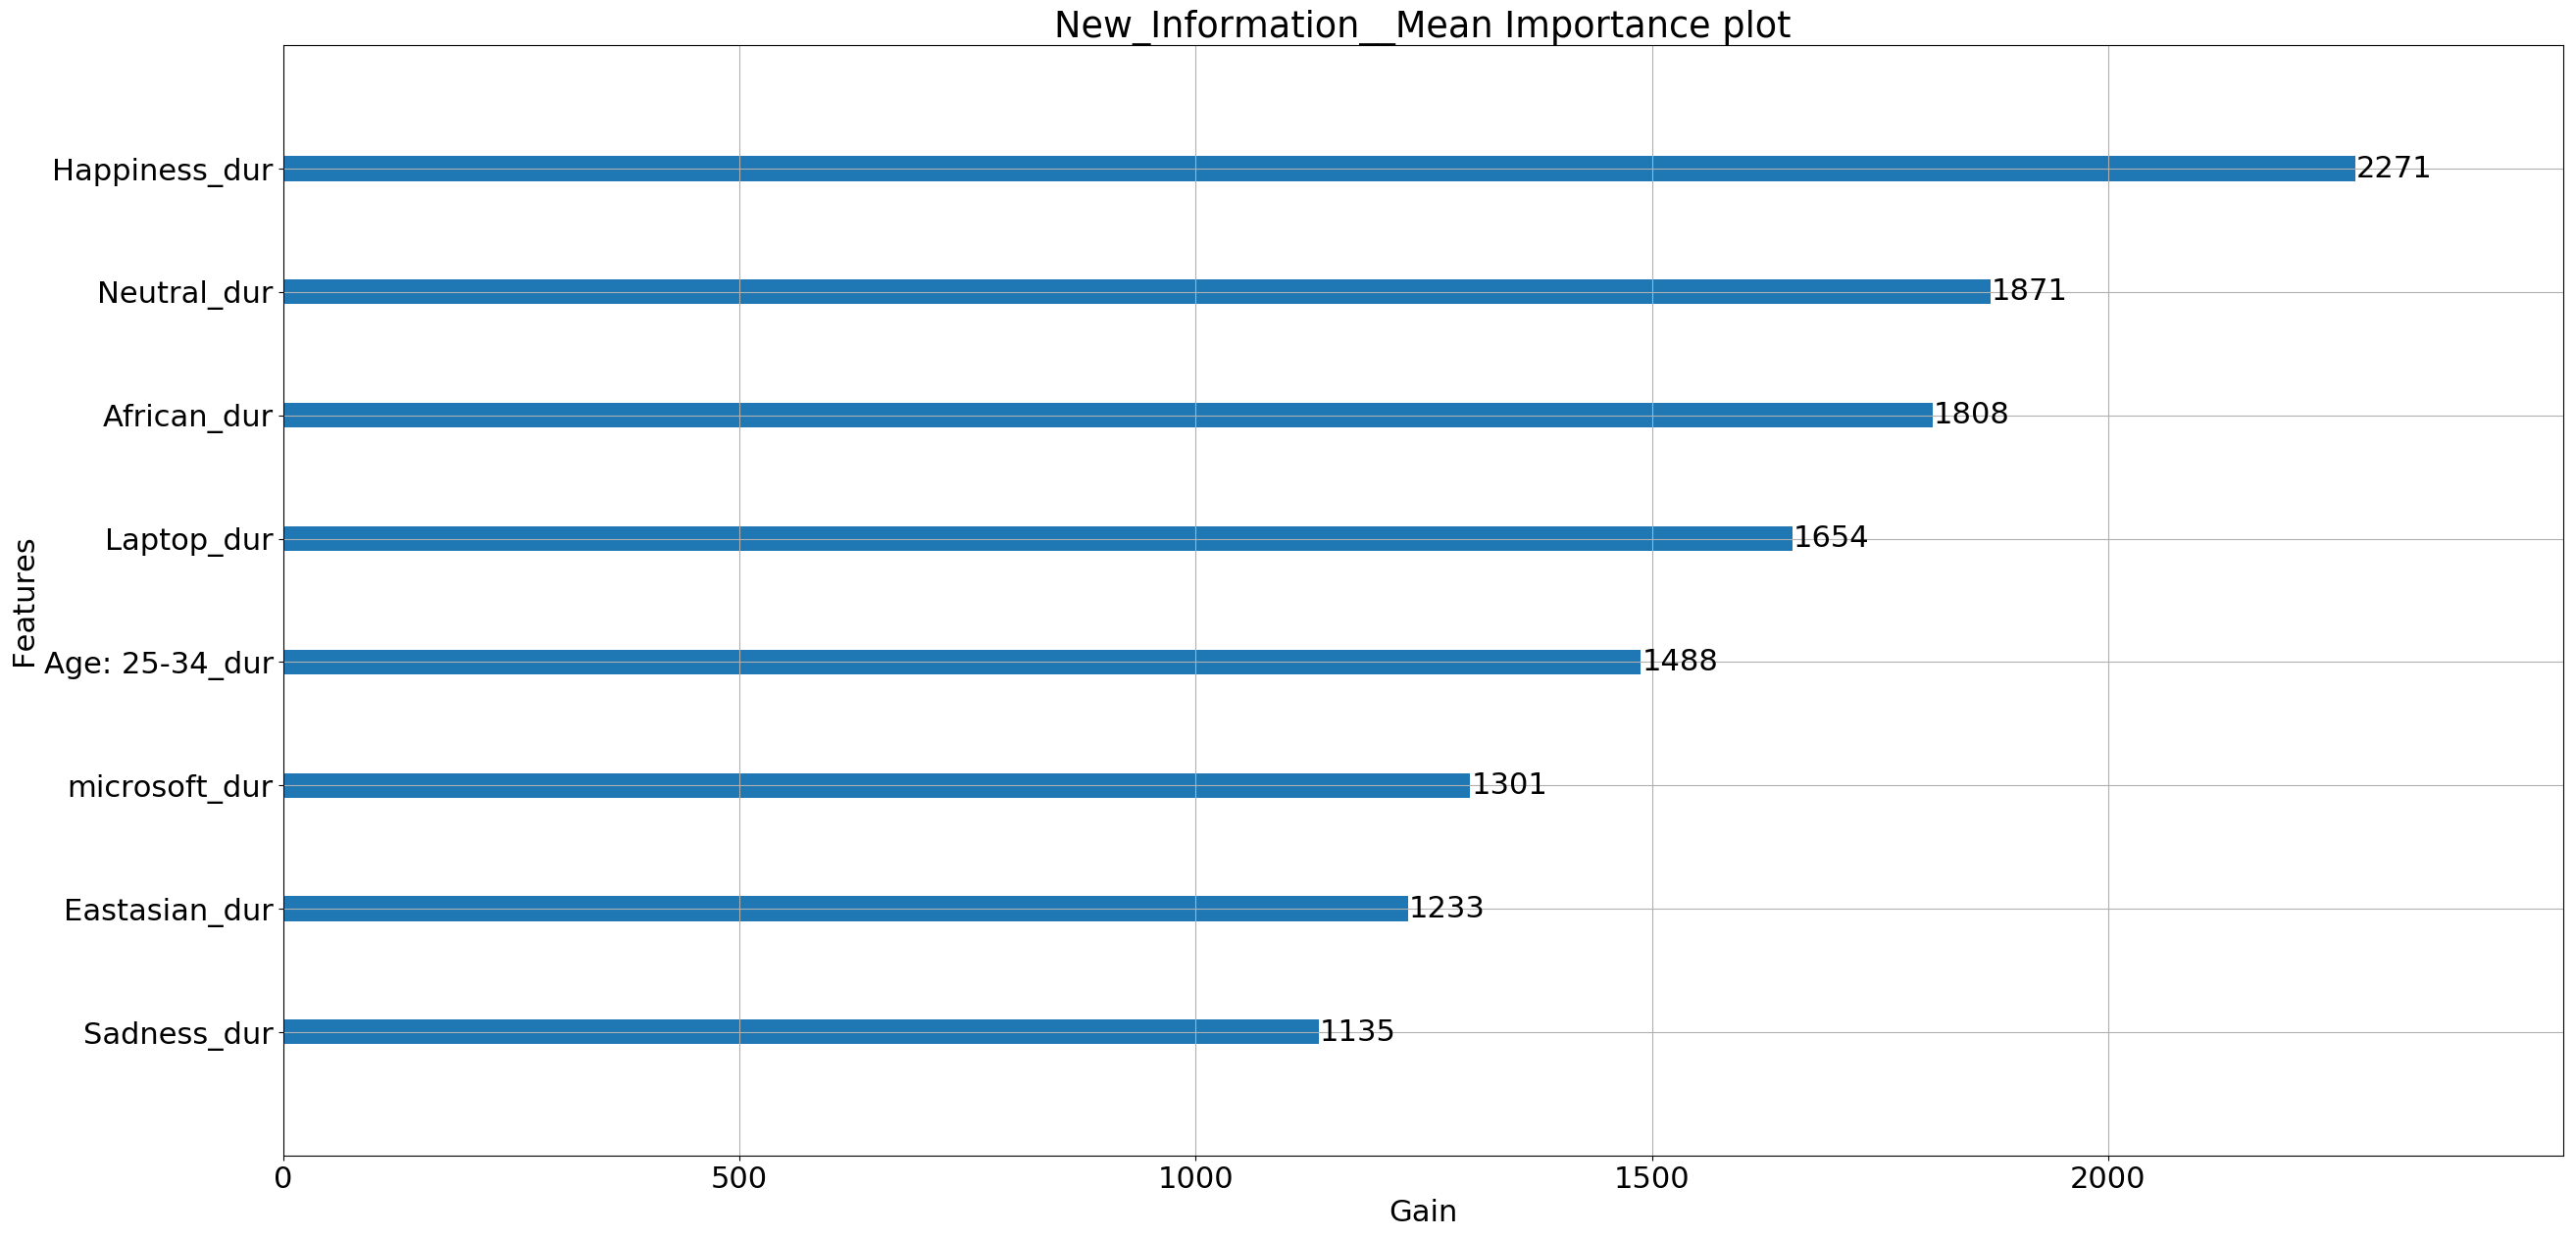

Enjoyment__Mean
Lenovo_text_dur
Windows_last_ocr
waiting in line
semi-enclosed area
Laptop_last_ocr
vertical components
sand
microsoft_last_ocr
Laptop_dur
Tablet_total_ocr
Hp_first_ocr
sunny
shopping
grass
microsoft_dur
sterile
length_of_ad_15
dirty
soothing
using tools
training
matte
sports
asphalt
socializing
studying
clouds
Lenovo_group_dur
Happiness_dur
medical activity
Laptop_first_ocr
warm
trees
Hp_text_dur
foliage
paper
Windows_first_ocr
metal
Tablet_first_ocr
Sadness_dur
Dell_text_dur
Age: 35-44_dur
leaves
carpet
microsoft_first_ocr
still water
eating
horizontal components
Neutral_dur
vegetation
microsoft_total_ocr
Dell_sub_brand_group_dur
Age: 15-24_dur
cluttered space
Tablet_dur
gaming
Asus_dur
stressful
conducting business
touring
exercise
Hp_dur
congregating
diving
snow
Hp_total_ocr
Hp_text_first_ocr
HP_group_dur
aged
boating
reading
Age: 25-34_dur
Yoga_dur
Hp_text_total_ocr
Dell_dur
Tablet_last_ocr
glass
Asus_text_dur
Hp_last_ocr
Windows_total_ocr
driving
Surface_group_dur

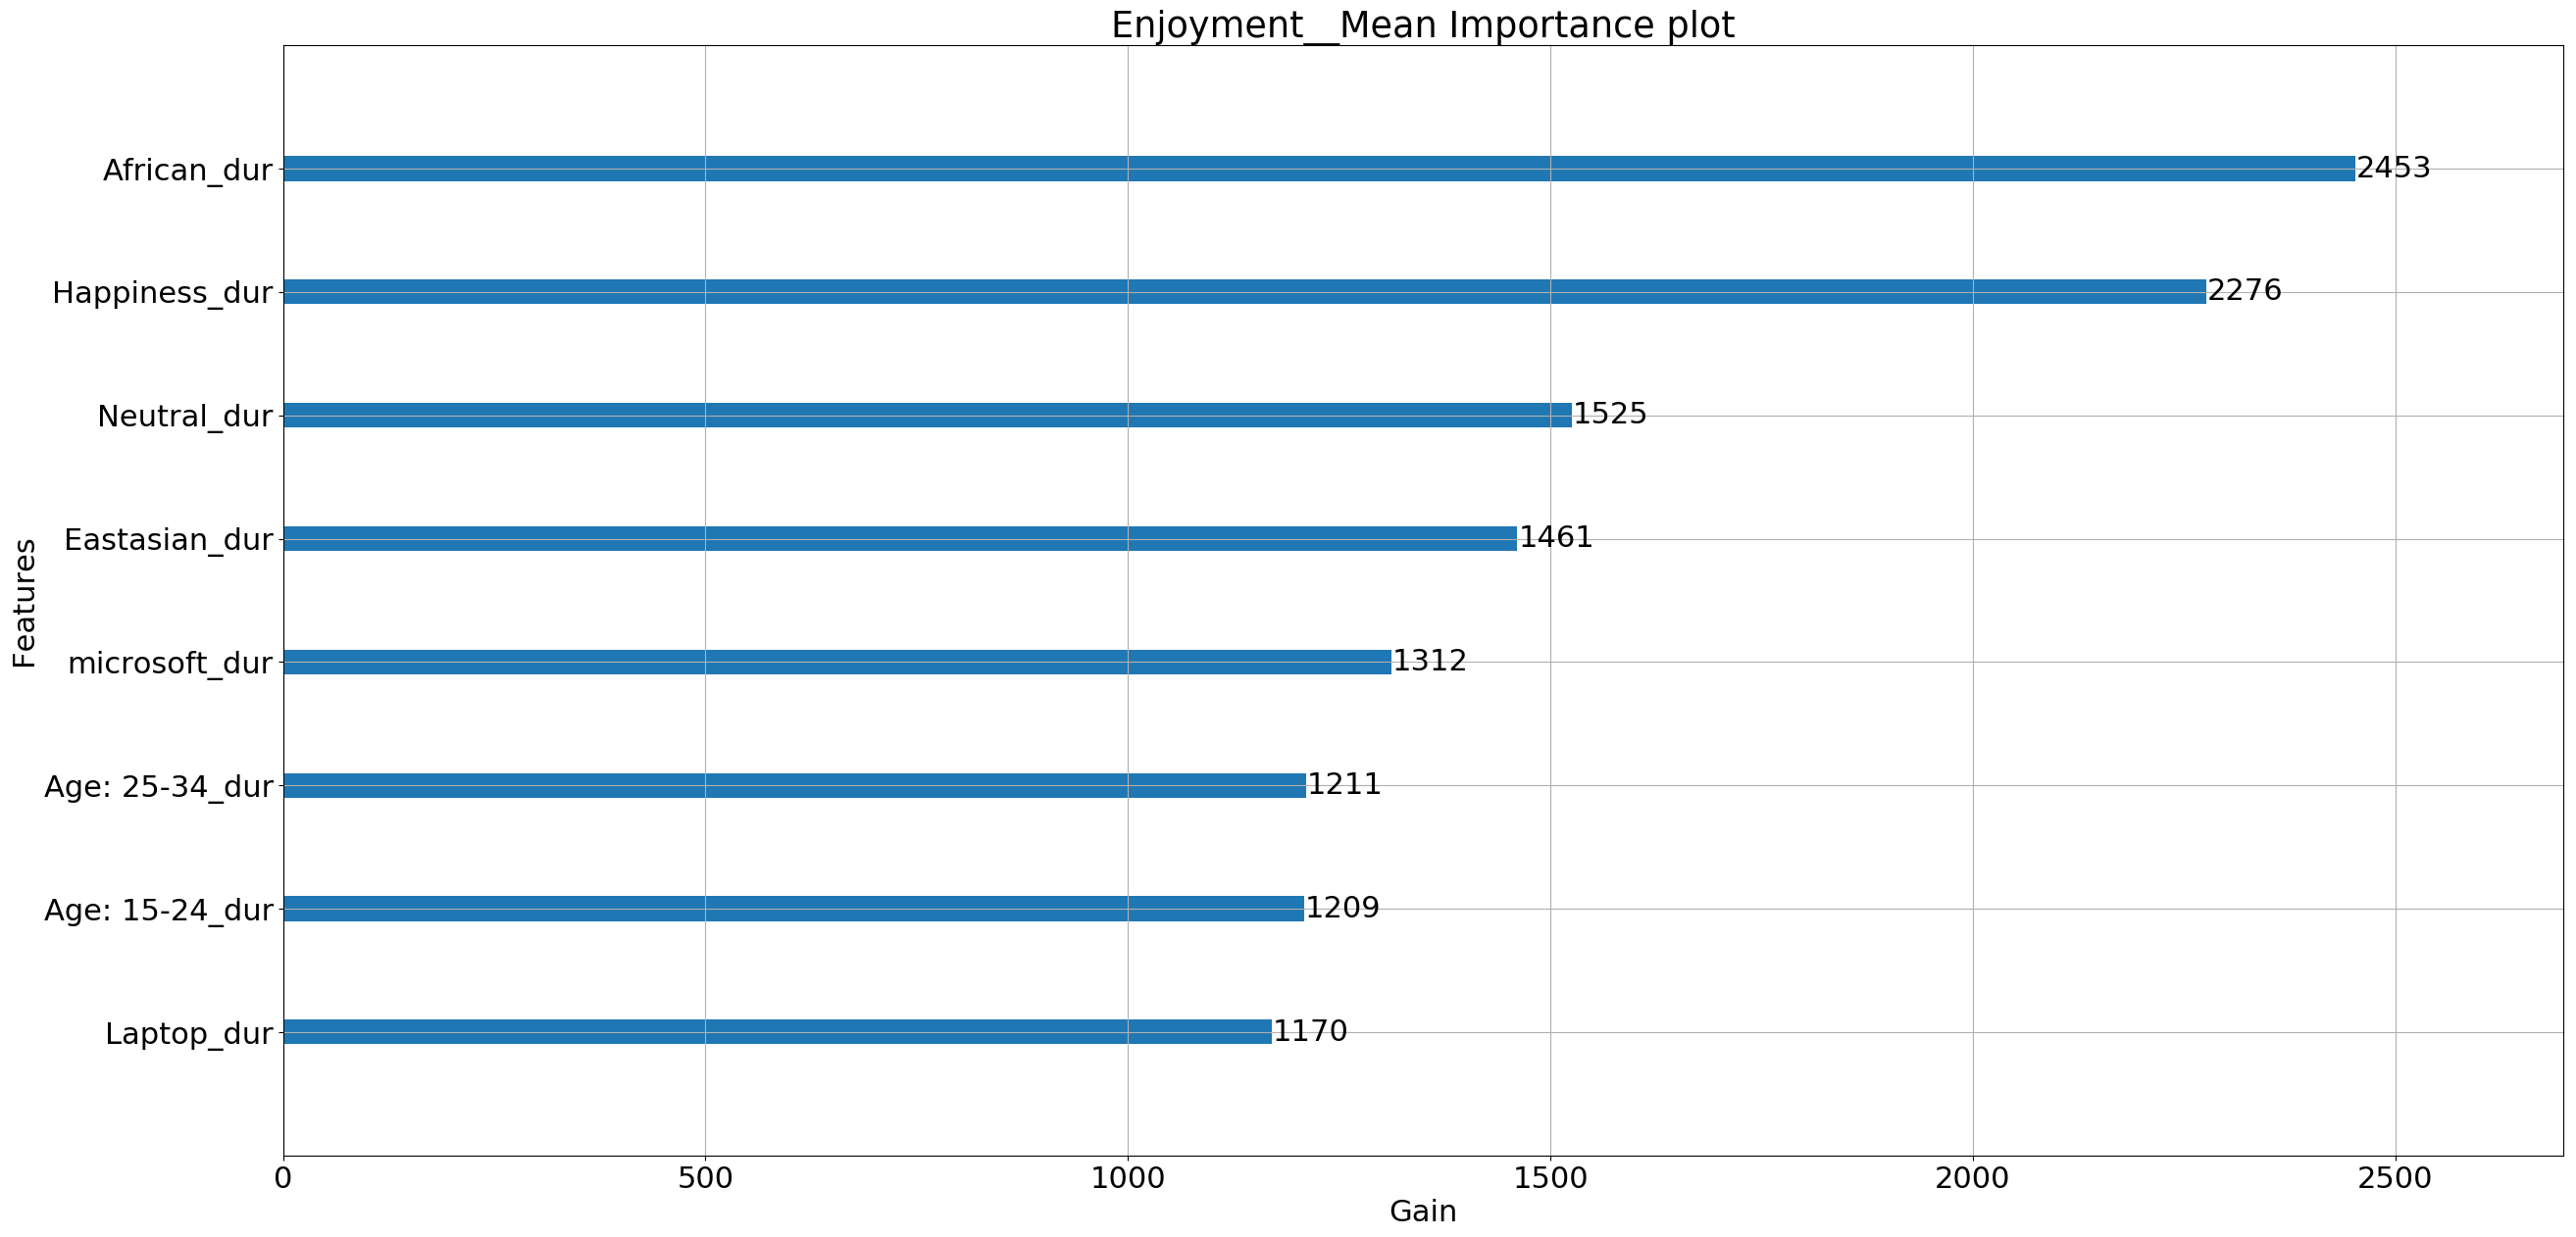

Brand_Appeal__Mean
soothing
natural light
waiting in line
Windows_last_ocr
flowers
Laptop_last_ocr
carpet
length_of_ad_15
training
plastic
metal
touring
transporting
Lenovo_text_dur
microsoft_last_ocr
warm
sand
socializing
Laptop_total_ocr
sunny
Female_dur
asphalt
Laptop_first_ocr
sports
Hp_text_dur
eating
dry
vertical components
ASUS T102_dur
Hp_dur
Hp_text_first_ocr
congregating
using tools
Hp_total_ocr
Age: 35-44_dur
Yoga_dur
studying
scary
Lenovo_group_dur
pavement
Age: 15-24_dur
Windows_dur
Windows_total_ocr
still water
sterile
Hp_text_last_ocr
medical activity
trees
Dell_sub_brand_group_dur
reading
microsoft_first_ocr
foliage
Happiness_dur
Sadness_dur
brick
Age: 25-34_dur
microsoft_total_ocr
exercise
Asus_dur
Hp_first_ocr
driving
research
leaves
biking
vegetation
Laptop_dur
symmetrical
aged
Asus_text_dur
shopping
Windows_first_ocr
microsoft_dur
Neutral_dur
boating
cold
Eastasian_dur
conducting business
clouds
swimming
Tablet_first_ocr
Hp_text_total_ocr
Hp_last_ocr
far-away horizo

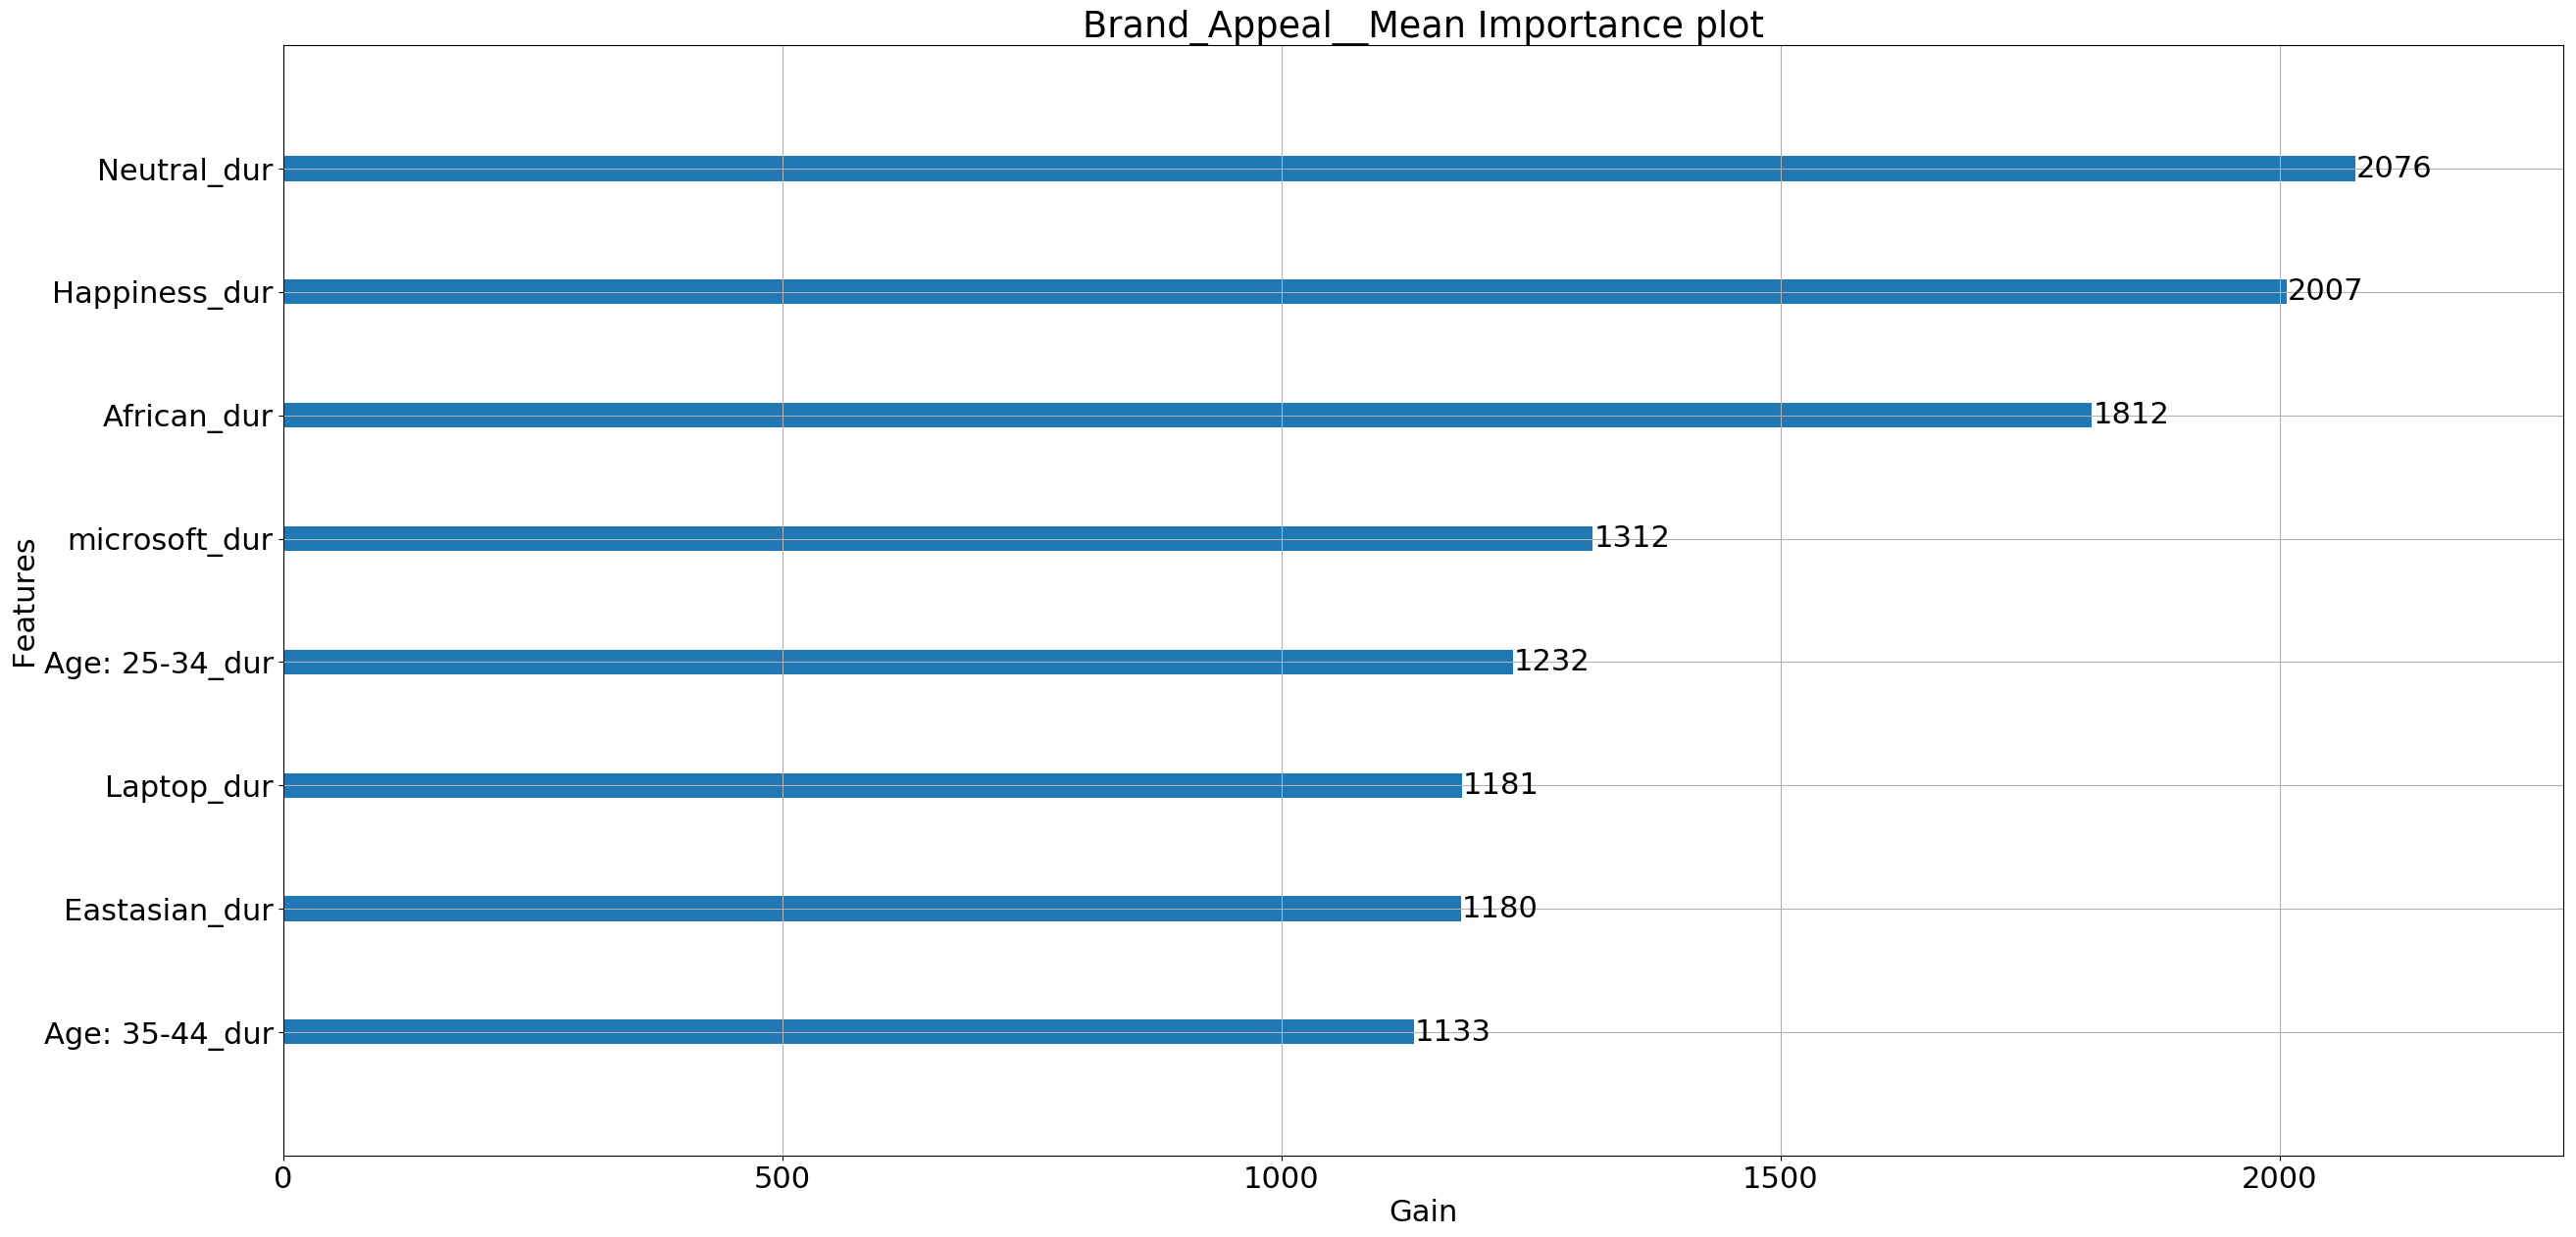

Understanding__Mean
waiting in line
soothing
vertical components
congregating
stressful
microsoft_dur
dry
clouds
studying
microsoft_last_ocr
shopping
Female_dur
Hp_text_total_ocr
glass
metal
sunny
conducting business
grass
Hp_first_ocr
Hp_text_dur
sand
Male_dur
horizontal components
medical activity
trees
Hp_last_ocr
flowers
matte
carpet
natural light
reading
Age: 15-24_dur
Neutral_dur
symmetrical
Hp_total_ocr
foliage
Hp_text_last_ocr
microsoft_first_ocr
sterile
Hp_dur
Lenovo_group_dur
length_of_ad_15
Laptop_dur
gaming
playing
microsoft_total_ocr
still water
Age: 25-34_dur
socializing
Lenovo_text_dur
exercise
boating
cluttered space
using tools
Sadness_dur
Asus_dur
Yoga_dur
Windows_first_ocr
glossy
transporting
plastic
diving
Laptop_last_ocr
Windows_last_ocr
Laptop_total_ocr
moist
Windows_dur
training
Laptop_first_ocr
Eastasian_dur
HP_group_dur
sports
Age: 35-44_dur
semi-enclosed area
paper
Windows_total_ocr
Hp_text_first_ocr
leaves
Happiness_dur
aged
cold
far-away horizon
spectating
T

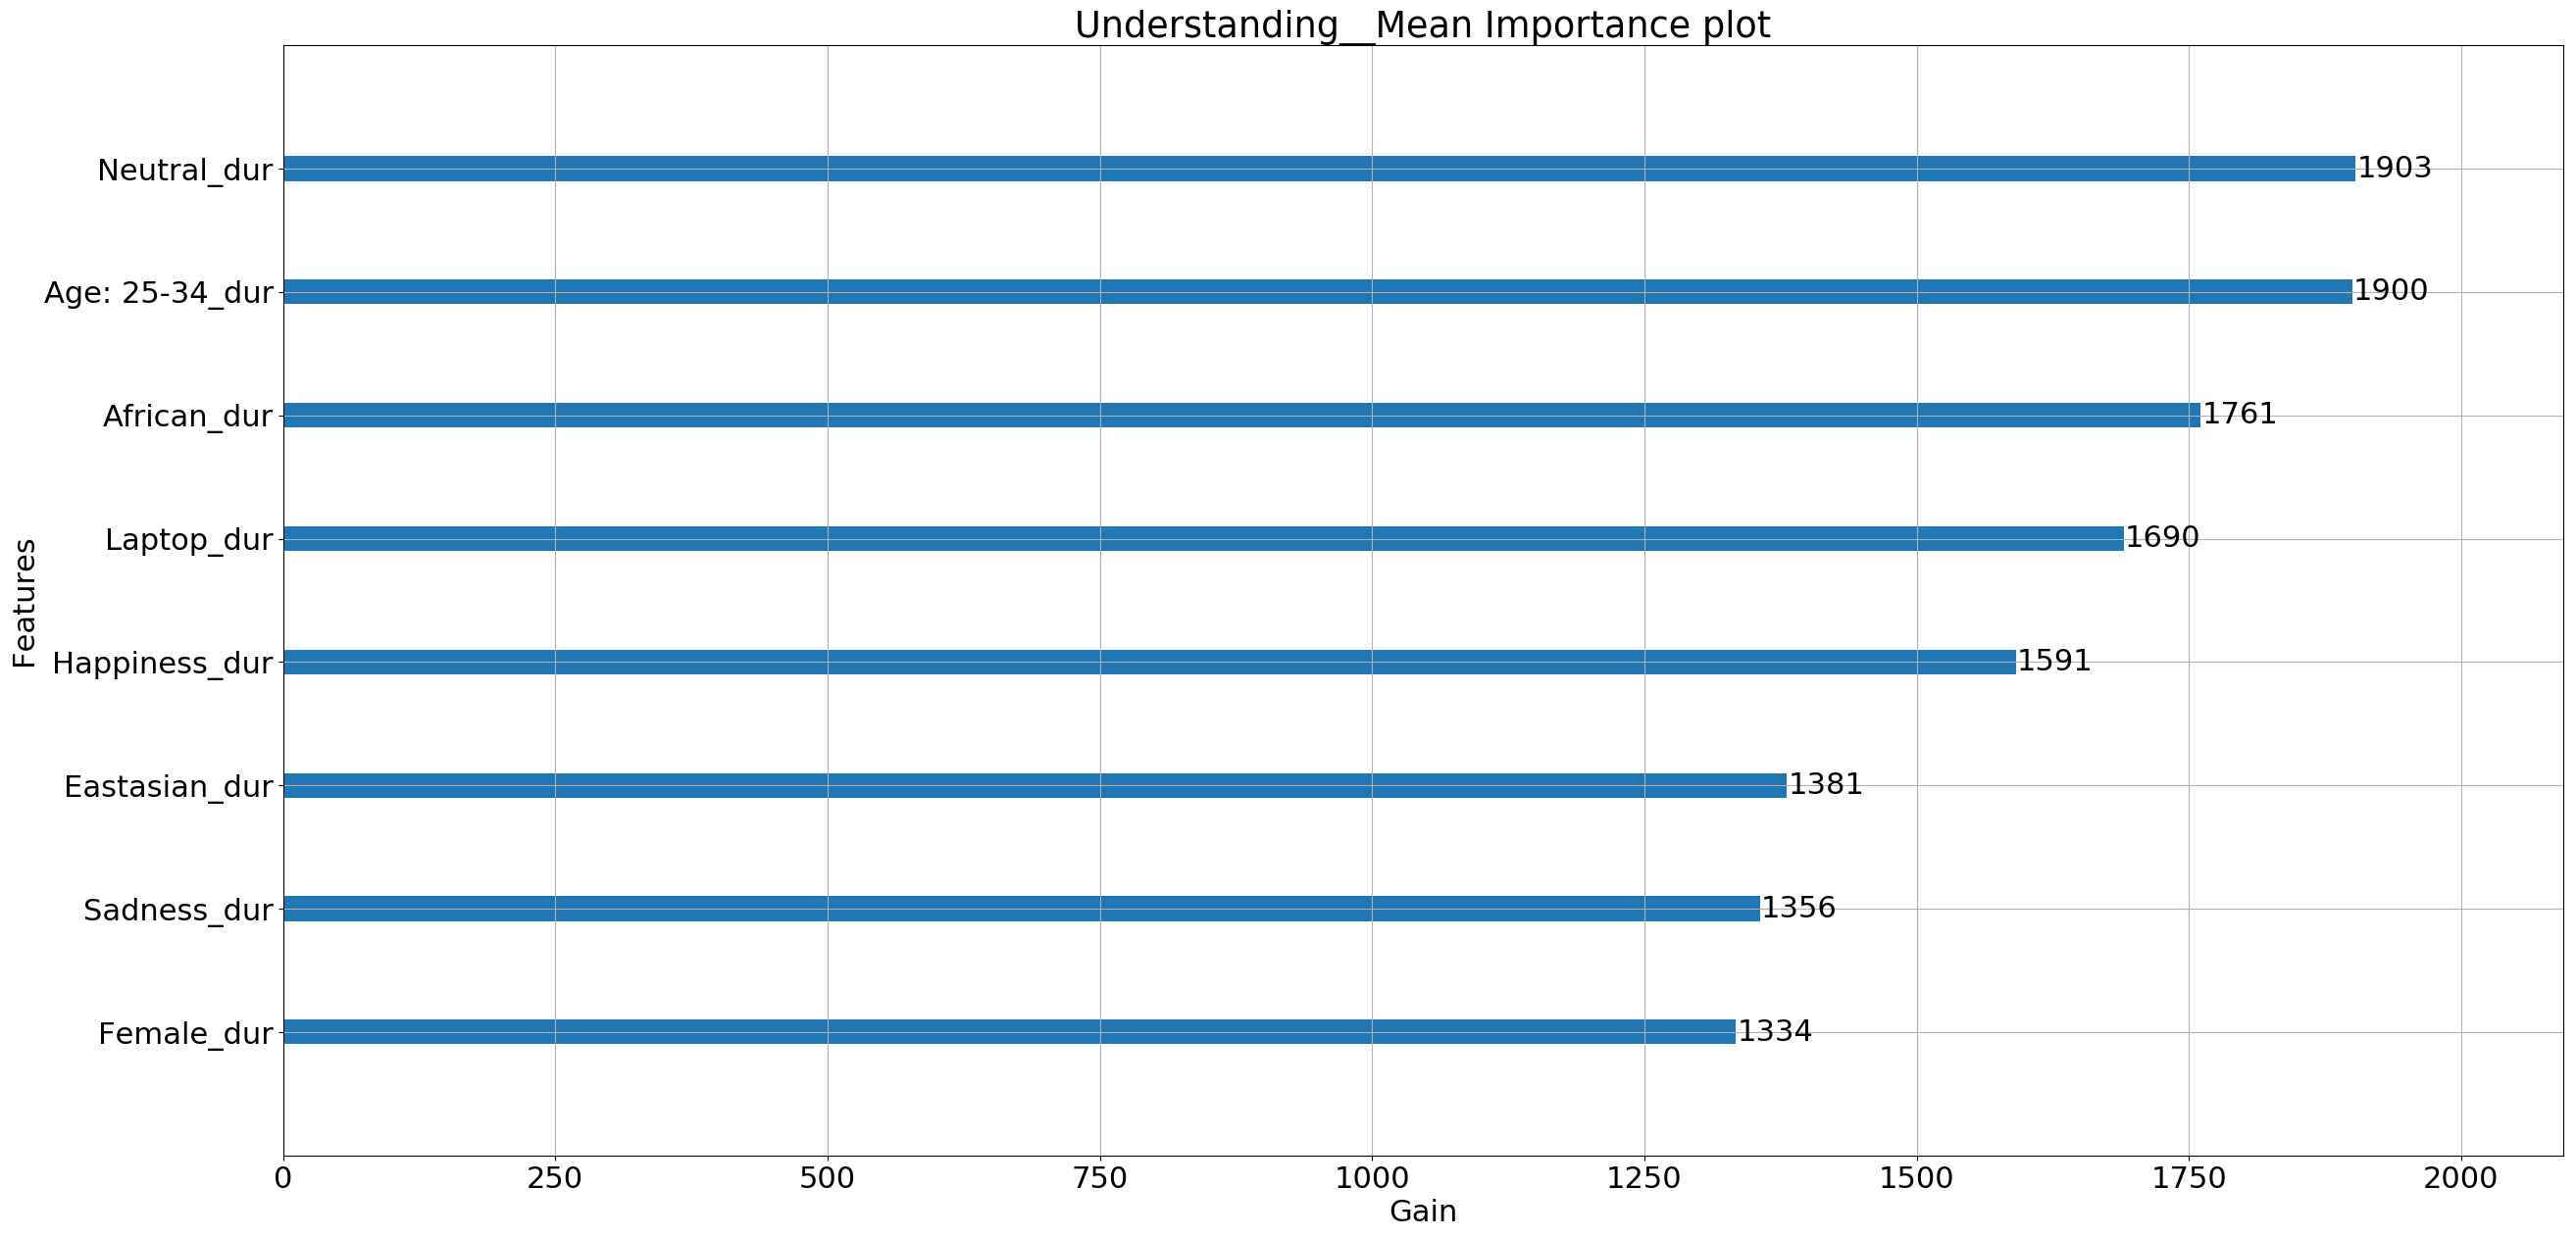

Relevance_of_Information__Mean
shrubbery
length_of_ad_15
natural light
microsoft_last_ocr
Windows_last_ocr
flowers
medical activity
matte
Asus_text_dur
waiting in line
Asus_dur
ASUS T102_dur
Laptop_first_ocr
gaming
Laptop_last_ocr
congregating
carpet
studying
using tools
microsoft_dur
Hp_text_total_ocr
soothing
metal
Age: 15-24_dur
Windows_first_ocr
clouds
microsoft_first_ocr
biking
transporting
eating
dry
sterile
asphalt
swimming
boating
Age: 35-44_dur
exercise
driving
conducting business
railing
diving
research
Surface_group_dur
shopping
scary
warm
aged
semi-enclosed area
natural
sunny
stressful
Lenovo_group_dur
playing
grass
Dell_sub_brand_group_dur
spectating
wood
training
Laptop_total_ocr
ocean
Windows_dur
cluttered space
Yoga_dur
glass
horizontal components
glossy
socializing
symmetrical
Laptop_dur
Tablet_dur
Hp_text_first_ocr
cold
Tablet_last_ocr
Hp_text_dur
Tablet_first_ocr
plastic
Happiness_dur
microsoft_total_ocr
far-away horizon
Dell_dur
paper
Tablet_total_ocr
Windows_total_

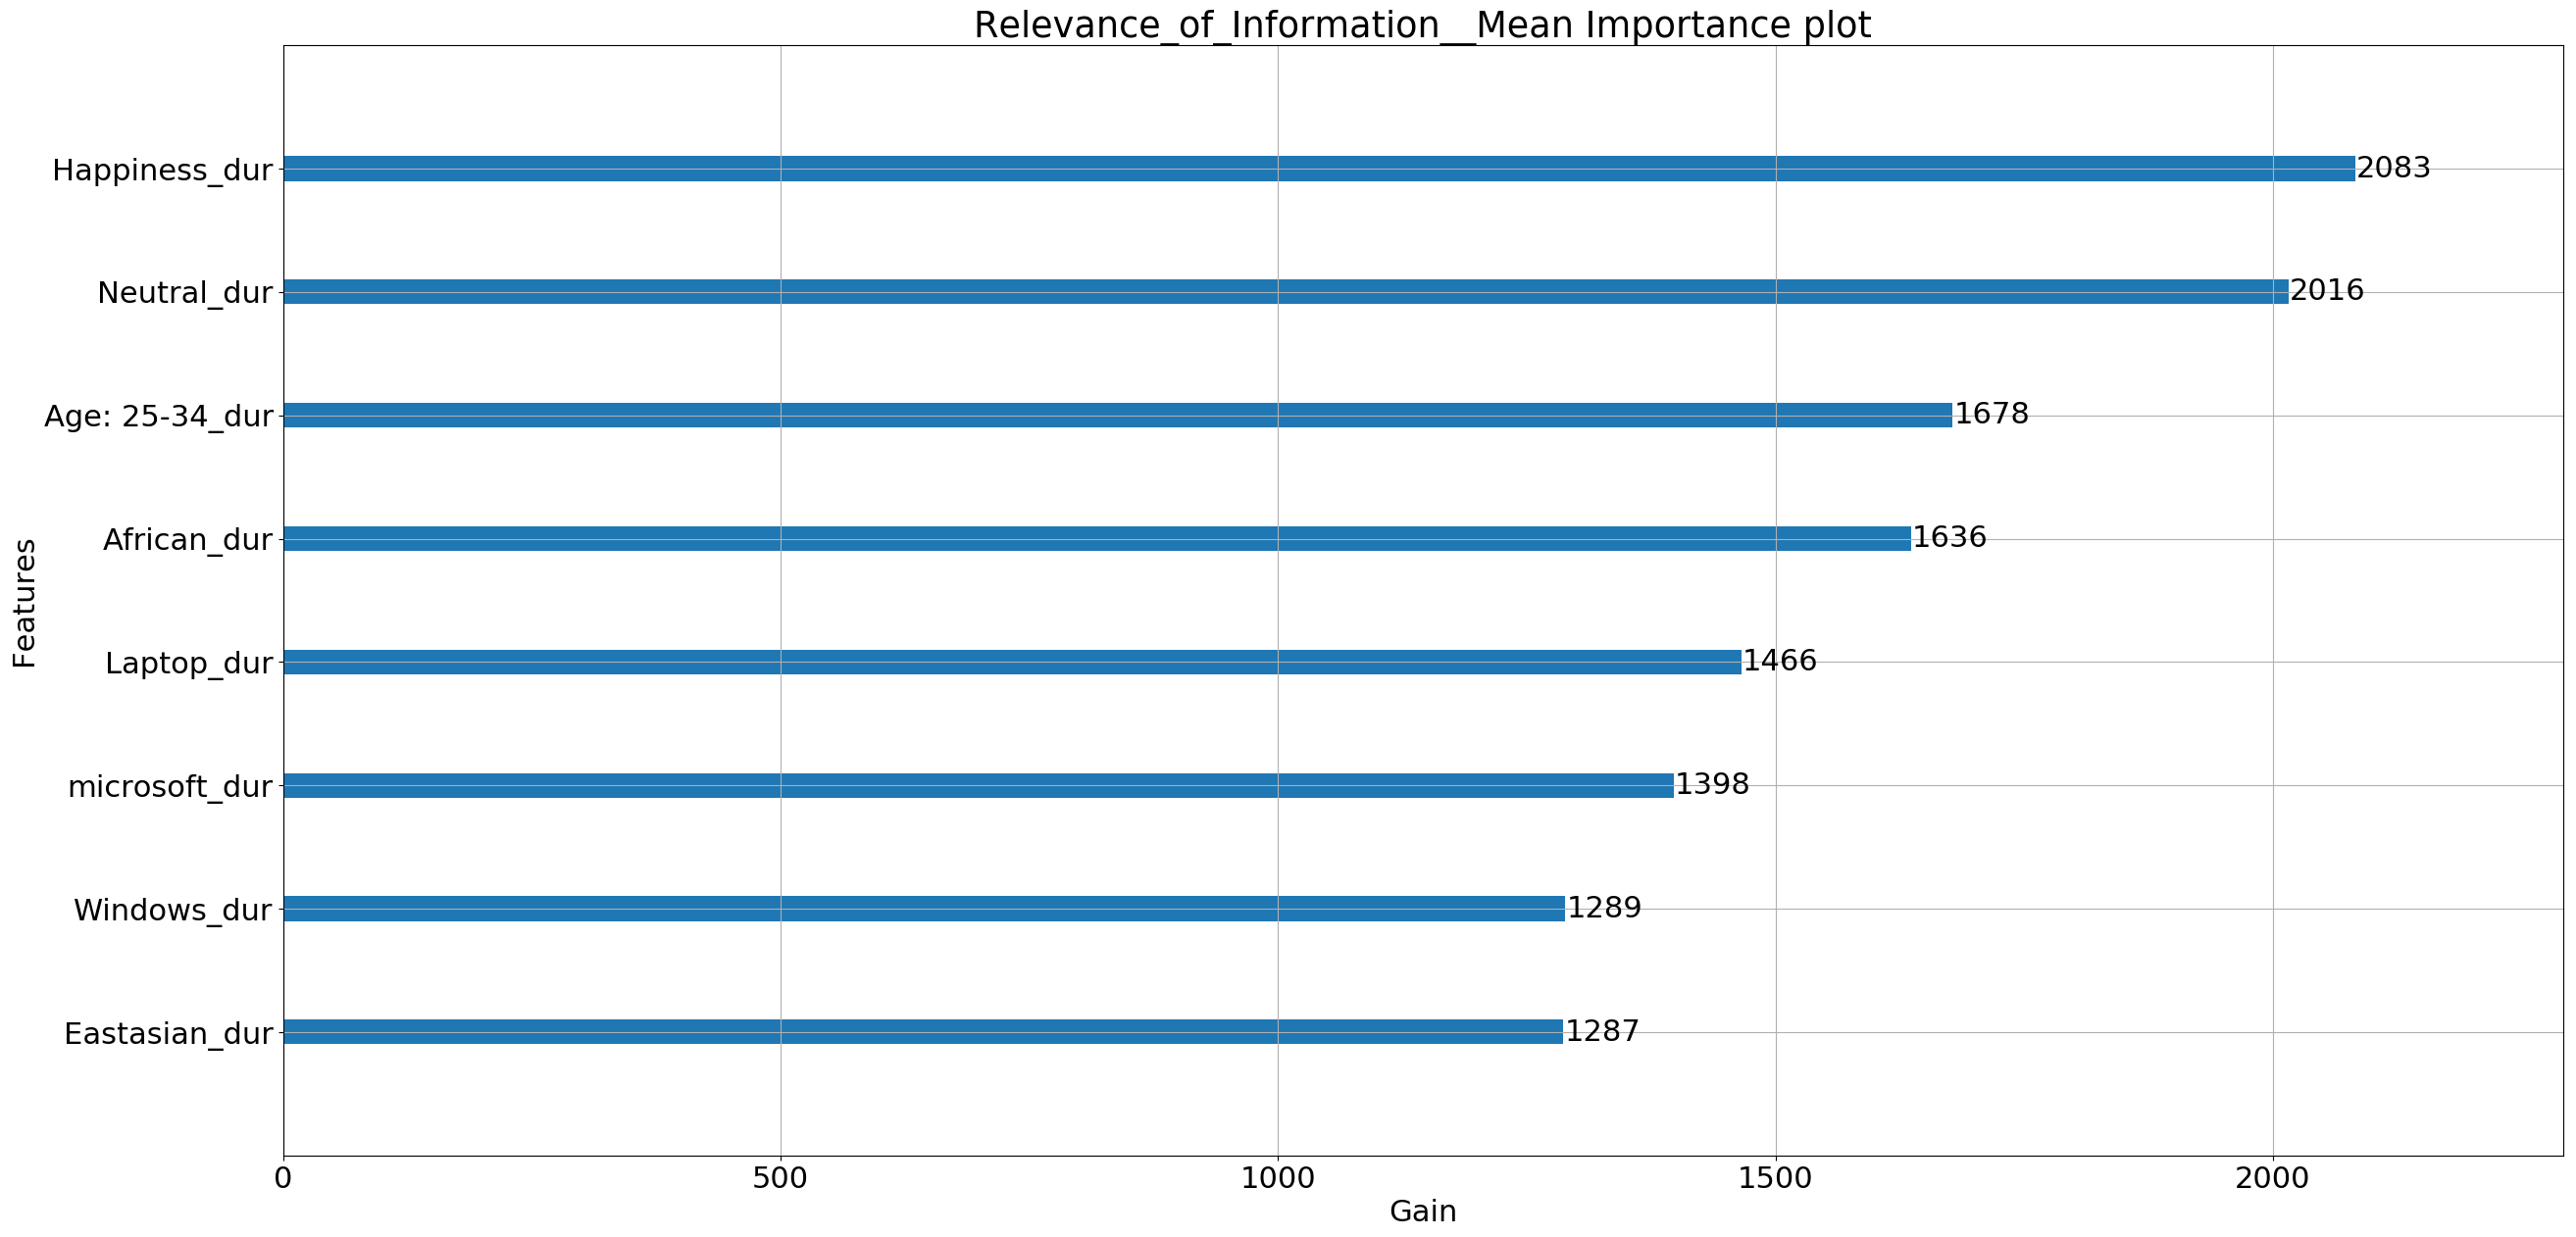

Credibility_of_Information__Mean
waiting in line
trees
Laptop_last_ocr
soothing
carpet
vegetation
touring
foliage
training
transporting
sunny
dry
warm
natural light
Yoga_dur
Laptop_first_ocr
reading
flowers
diving
socializing
microsoft_last_ocr
Laptop_total_ocr
metal
microsoft_dur
scary
exercise
Lenovo_text_dur
Dell_dur
sports
Tablet_total_ocr
microsoft_first_ocr
eating
clouds
shopping
leaves
ocean
conducting business
Windows_first_ocr
Hp_text_dur
sand
Tablet_first_ocr
Laptop_dur
vertical components
congregating
horizontal components
microsoft_total_ocr
rugged scene
using tools
Tablet_dur
playing
driving
brick
Lenovo_group_dur
Neutral_dur
cold
Tablet_last_ocr
matte
medical activity
Hp_total_ocr
ASUS T102_dur
camping
sterile
Hp_text_first_ocr
plastic
aged
still water
Windows_dur
Age: 15-24_dur
boating
glass
studying
Windows_total_ocr
Windows_last_ocr
swimming
Surface_group_dur
Hp_first_ocr
far-away horizon
asphalt
Age: 25-34_dur
Dell_sub_brand_group_dur
paper
dirt
Asus_text_dur
Hp_last_

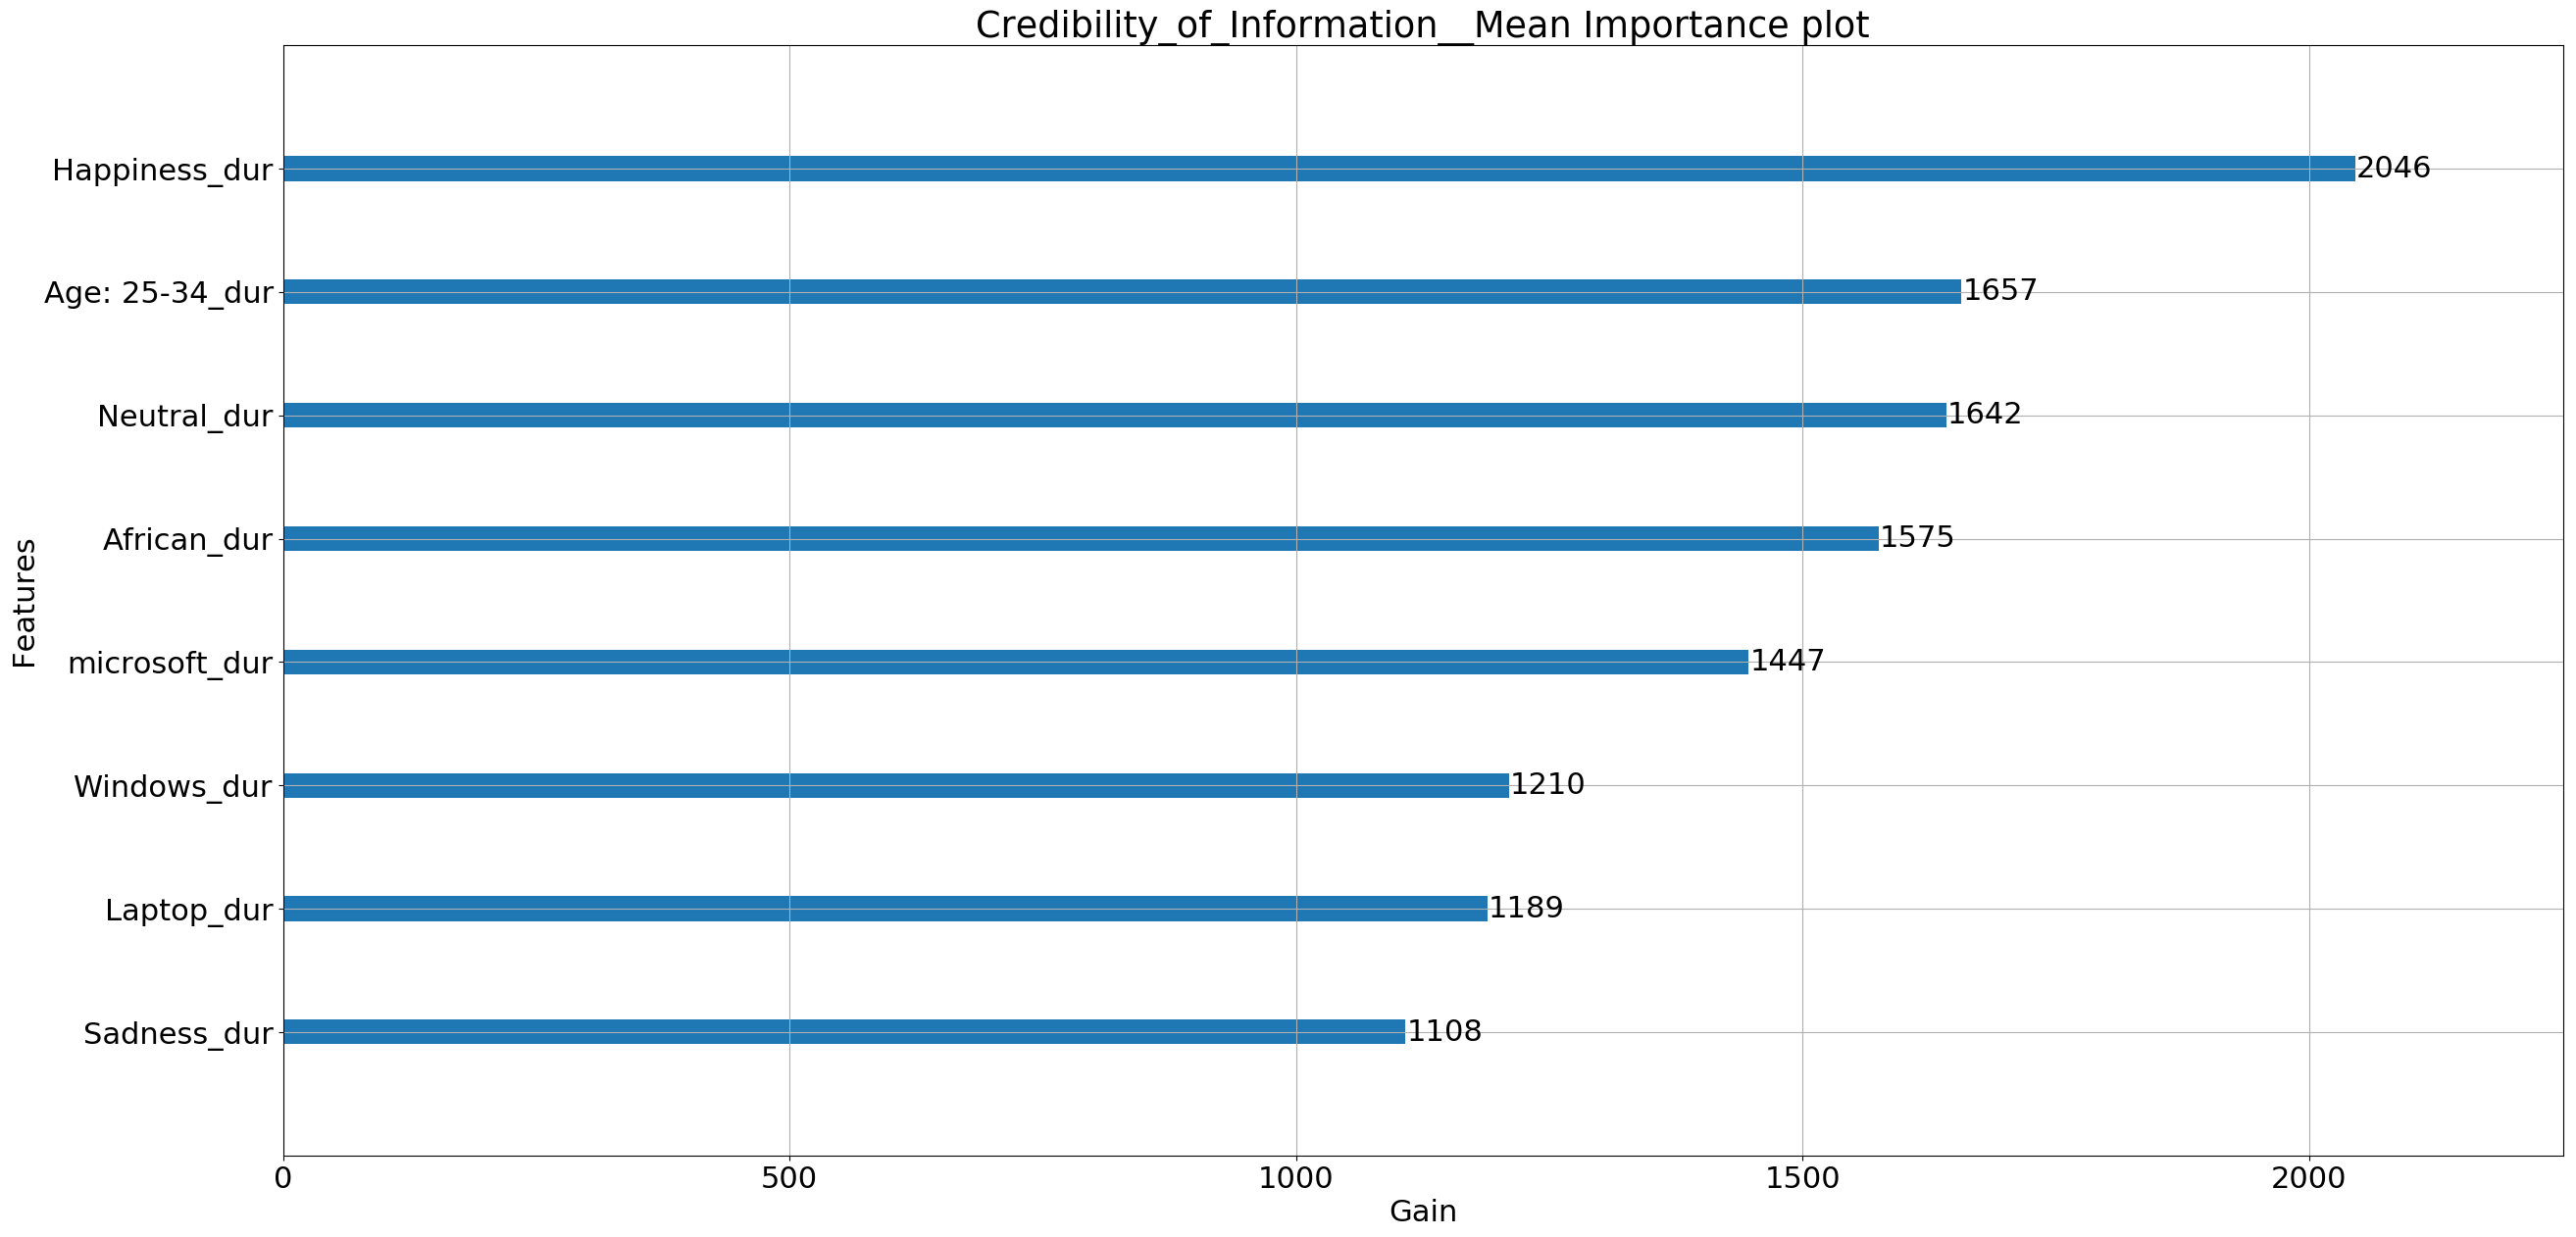

Brand_Difference__Mean
rugged scene
waiting in line
touring
microsoft_last_ocr
glossy
carpet
training
flowers
Laptop_last_ocr
metal
natural light
sunny
Windows_last_ocr
microsoft_first_ocr
climbing
Dell_text_dur
length_of_ad_15
soothing
camping
Laptop_first_ocr
congregating
vertical components
sterile
Tablet_total_ocr
Tablet_last_ocr
cluttered space
Tablet_first_ocr
Windows_first_ocr
Hp_text_dur
cold
exercise
shopping
hiking
Laptop_dur
medical activity
clouds
ASUS T102_dur
semi-enclosed area
asphalt
Lenovo_text_dur
conducting business
using tools
warm
sports
moist
Tablet_dur
Age: 15-24_dur
reading
far-away horizon
Asus_dur
boating
Laptop_total_ocr
Yoga_dur
socializing
Dell_dur
vegetation
playing
Neutral_dur
HP_group_dur
sand
foliage
glass
Lenovo_group_dur
matte
ocean
Asus_text_dur
paper
Happiness_dur
brick
gaming
transporting
studying
Age: 25-34_dur
still water
aged
research
Dell_sub_brand_group_dur
stressful
Hp_text_total_ocr
Sadness_dur
driving
microsoft_total_ocr
Age: 35-44_dur
symm

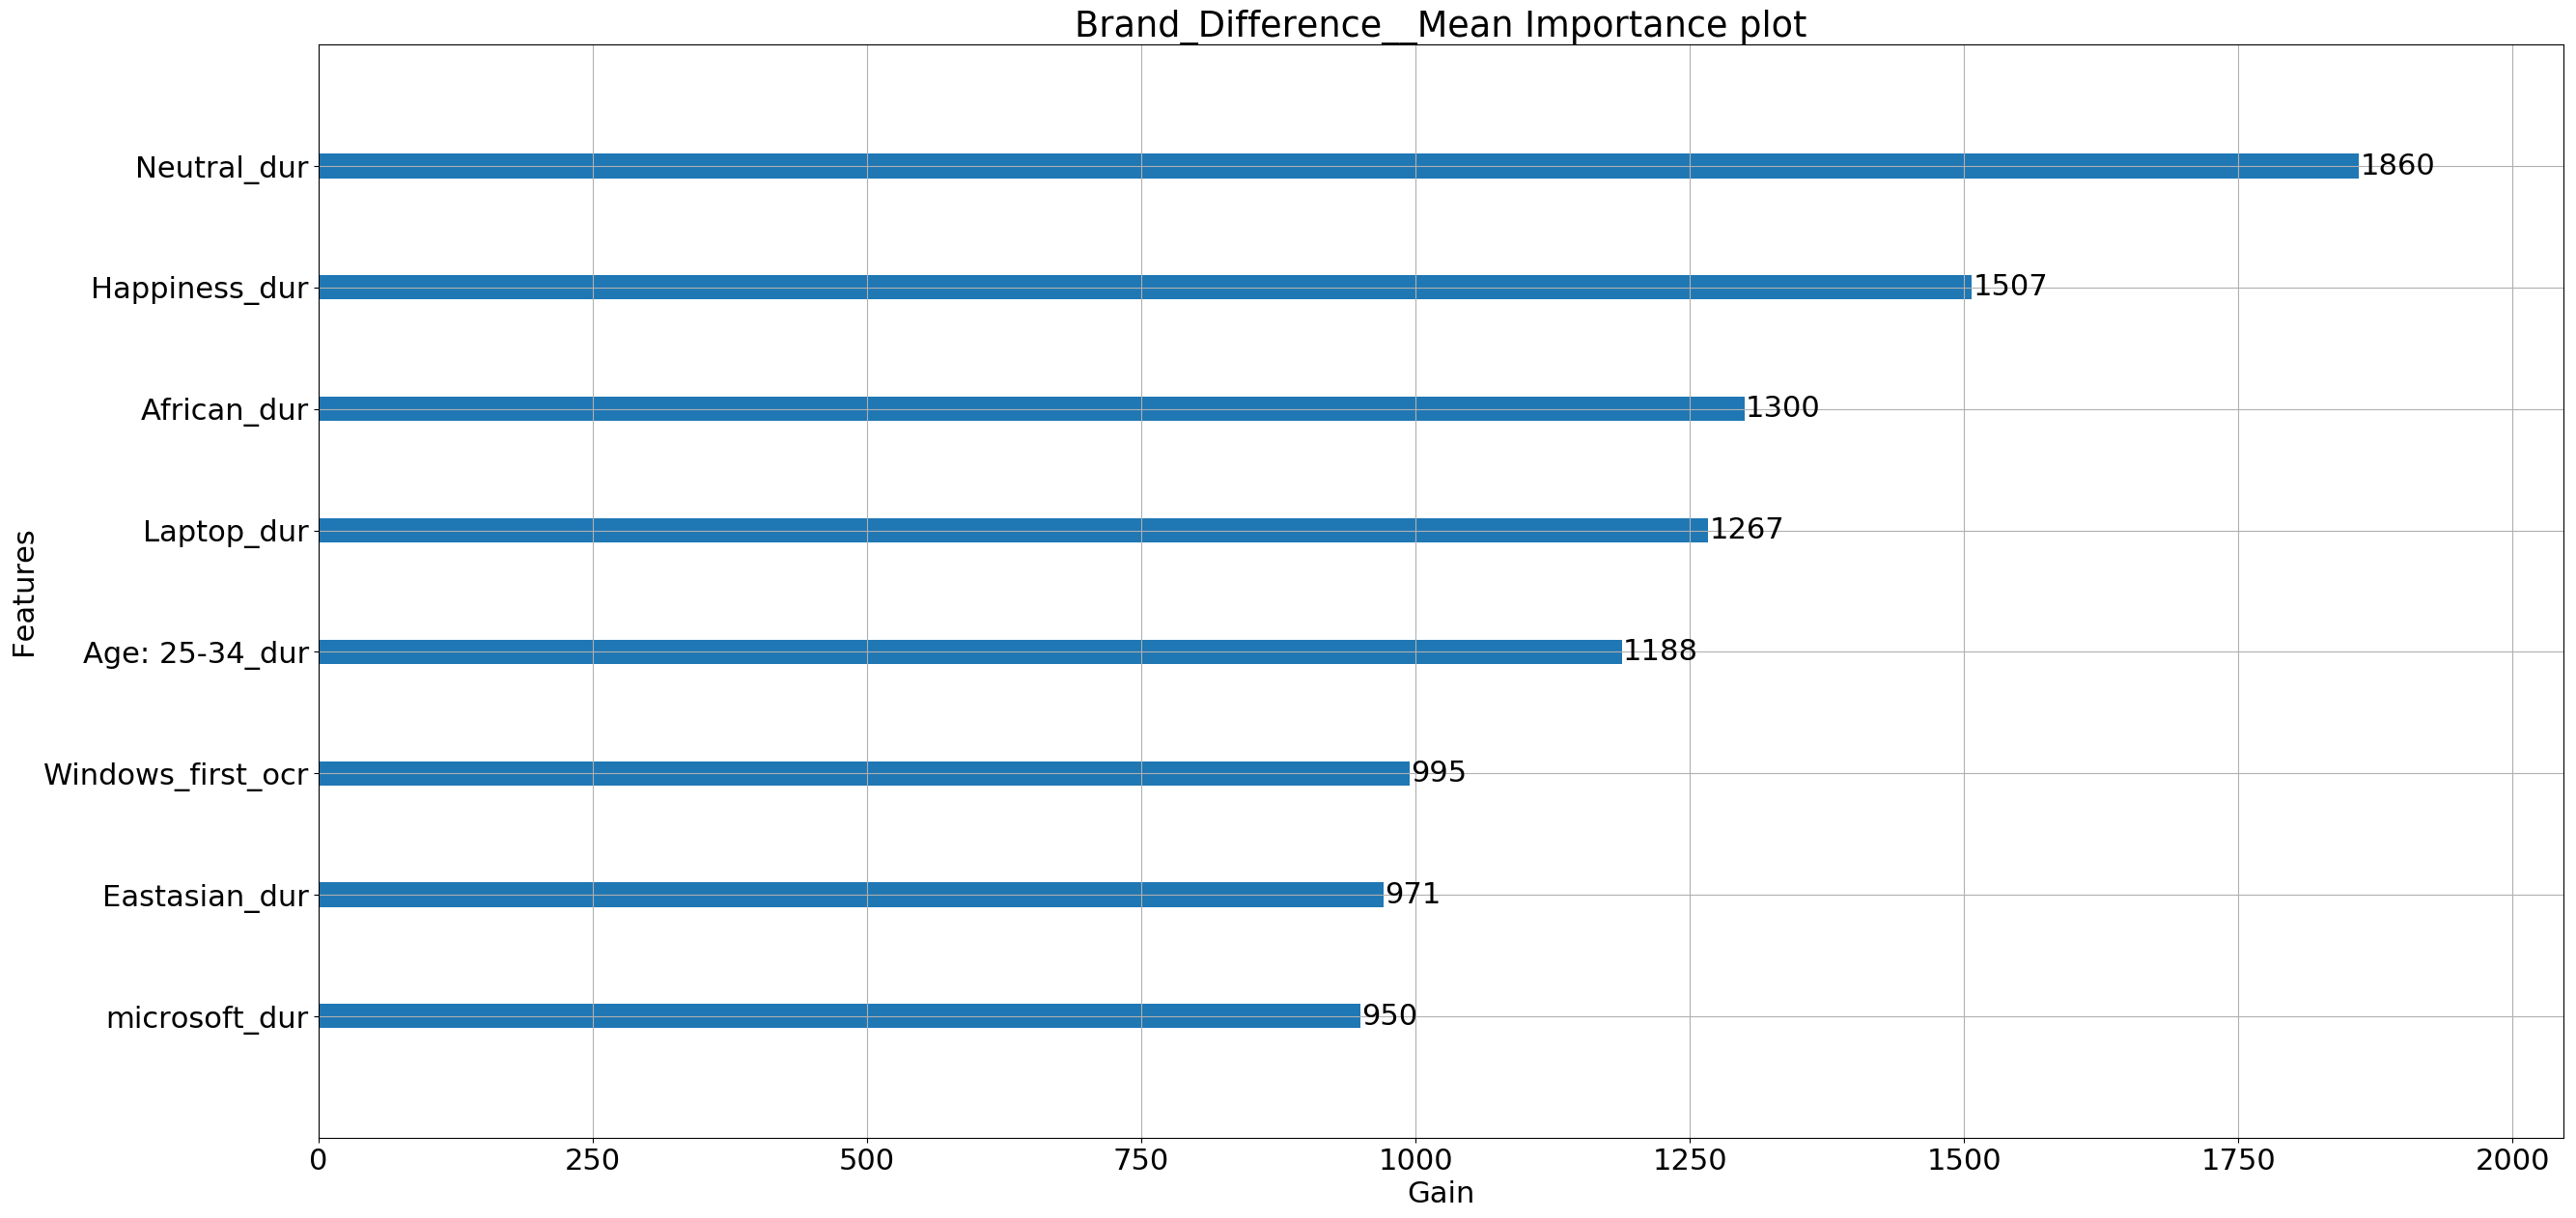

Interest_peak
Dell_text_dur
touring
length_of_ad_15
semi-enclosed area
training
Dell_dur
railing
shrubbery
moist
Windows_first_ocr
pavement
gaming
snow
trees
rugged scene
grass
Windows_last_ocr
soothing
sunny
wood
shopping
tiles
sports
microsoft_first_ocr
swimming
symmetrical
research
sterile
studying
conducting business
glossy
matte
cold
Asus_text_dur
foliage
scary
socializing
microsoft_last_ocr
horizontal components
Laptop_total_ocr
transporting
vertical components
Laptop_first_ocr
Tablet_first_ocr
using tools
flowers
waiting in line
Laptop_last_ocr
Tablet_last_ocr
paper
Laptop_dur
Age: 15-24_dur
microsoft_dur
Tablet_total_ocr
Male_dur
clouds
biking
playing
plastic
exercise
carpet
metal
sand
driving
asphalt
eating
ocean
Female_dur
climbing
Windows_dur
Hp_text_first_ocr
aged
stressful
Hp_text_total_ocr
Asus_dur
Happiness_dur
natural light
Lenovo_group_dur
African_dur
Surface_group_dur
Hp_first_ocr
Yoga_dur
Neutral_dur
Hp_text_dur
glass
ASUS T102_dur
Hp_last_ocr
Lenovo_text_dur
reading

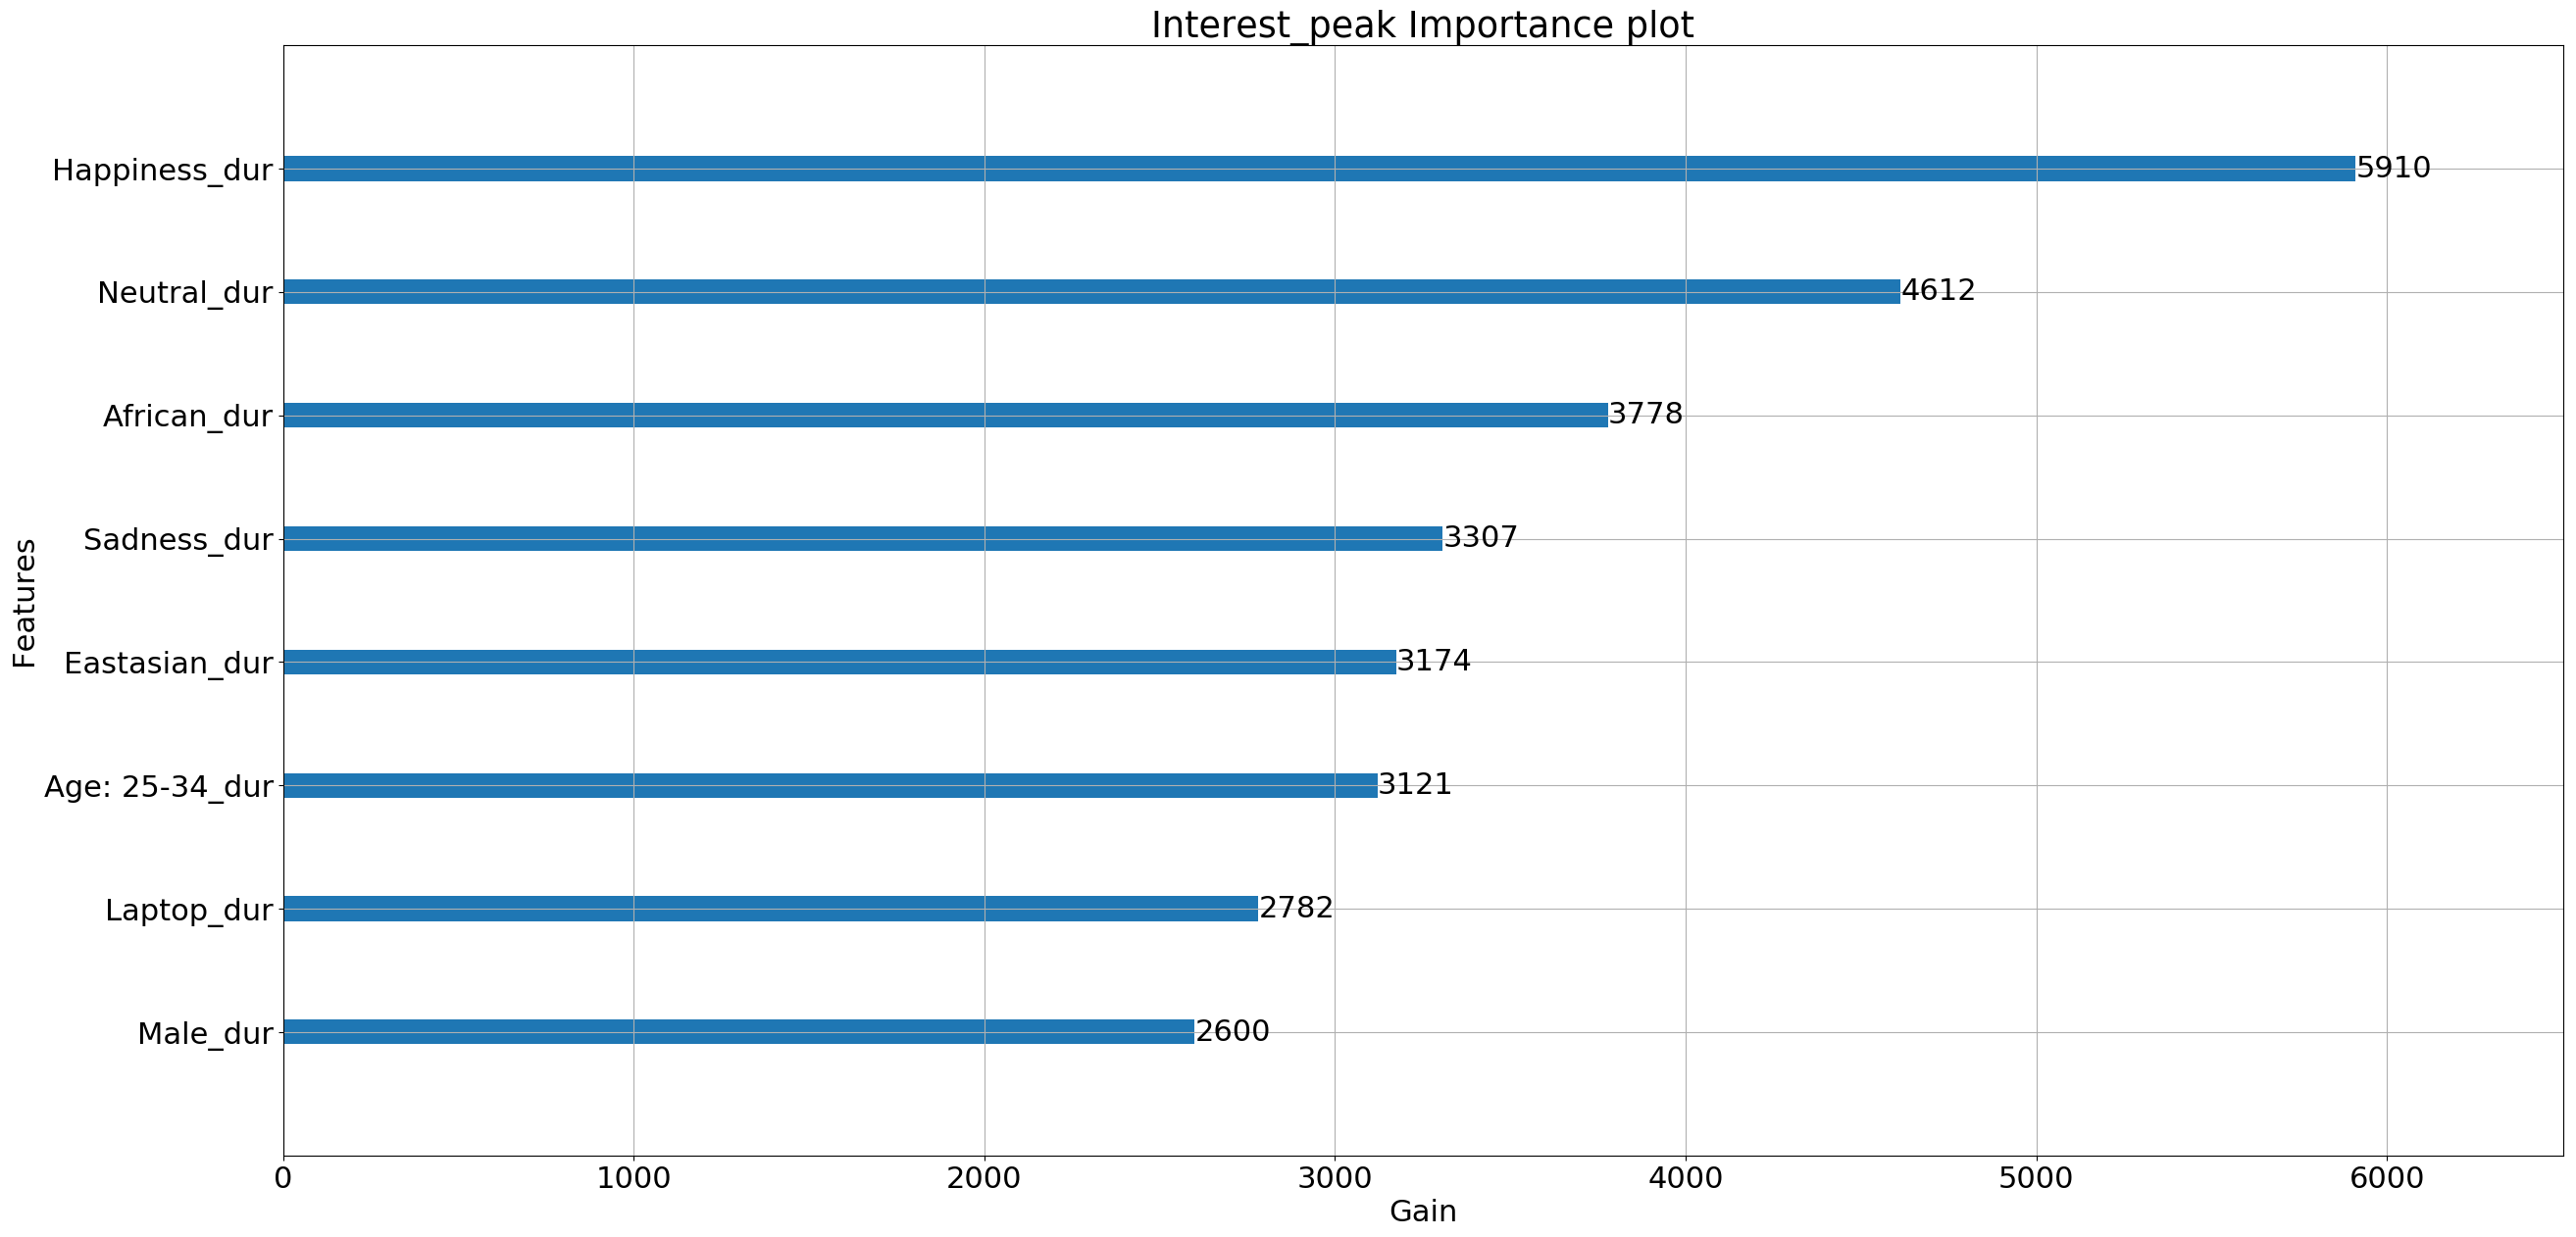

Interest_mean_score
length_of_ad_15
waiting in line
shrubbery
Windows_last_ocr
Windows_first_ocr
carpet
sunny
vertical components
using tools
microsoft_last_ocr
Laptop_last_ocr
sterile
natural light
microsoft_first_ocr
Hp_text_dur
gaming
semi-enclosed area
Laptop_total_ocr
Windows_dur
congregating
Dell_text_dur
shopping
stressful
glossy
clouds
asphalt
Hp_text_first_ocr
touring
symmetrical
Hp_text_total_ocr
pavement
Laptop_first_ocr
far-away horizon
natural
Laptop_dur
warm
exercise
rugged scene
wood
training
plastic
studying
flowers
spectating
microsoft_dur
driving
Hp_dur
playing
eating
socializing
sand
cold
glass
railing
foliage
sports
ocean
Lenovo_text_dur
research
trees
biking
metal
transporting
Female_dur
swimming
brick
Hp_total_ocr
grass
microsoft_total_ocr
boating
Hp_first_ocr
Hp_text_last_ocr
moist
leaves
Lenovo_group_dur
aged
Male_dur
Yoga_dur
Hp_last_ocr
ASUS T102_dur
Surface_group_dur
scary
Happiness_dur
Tablet_last_ocr
vegetation
Eastasian_dur
Asus_text_dur
Windows_total_ocr


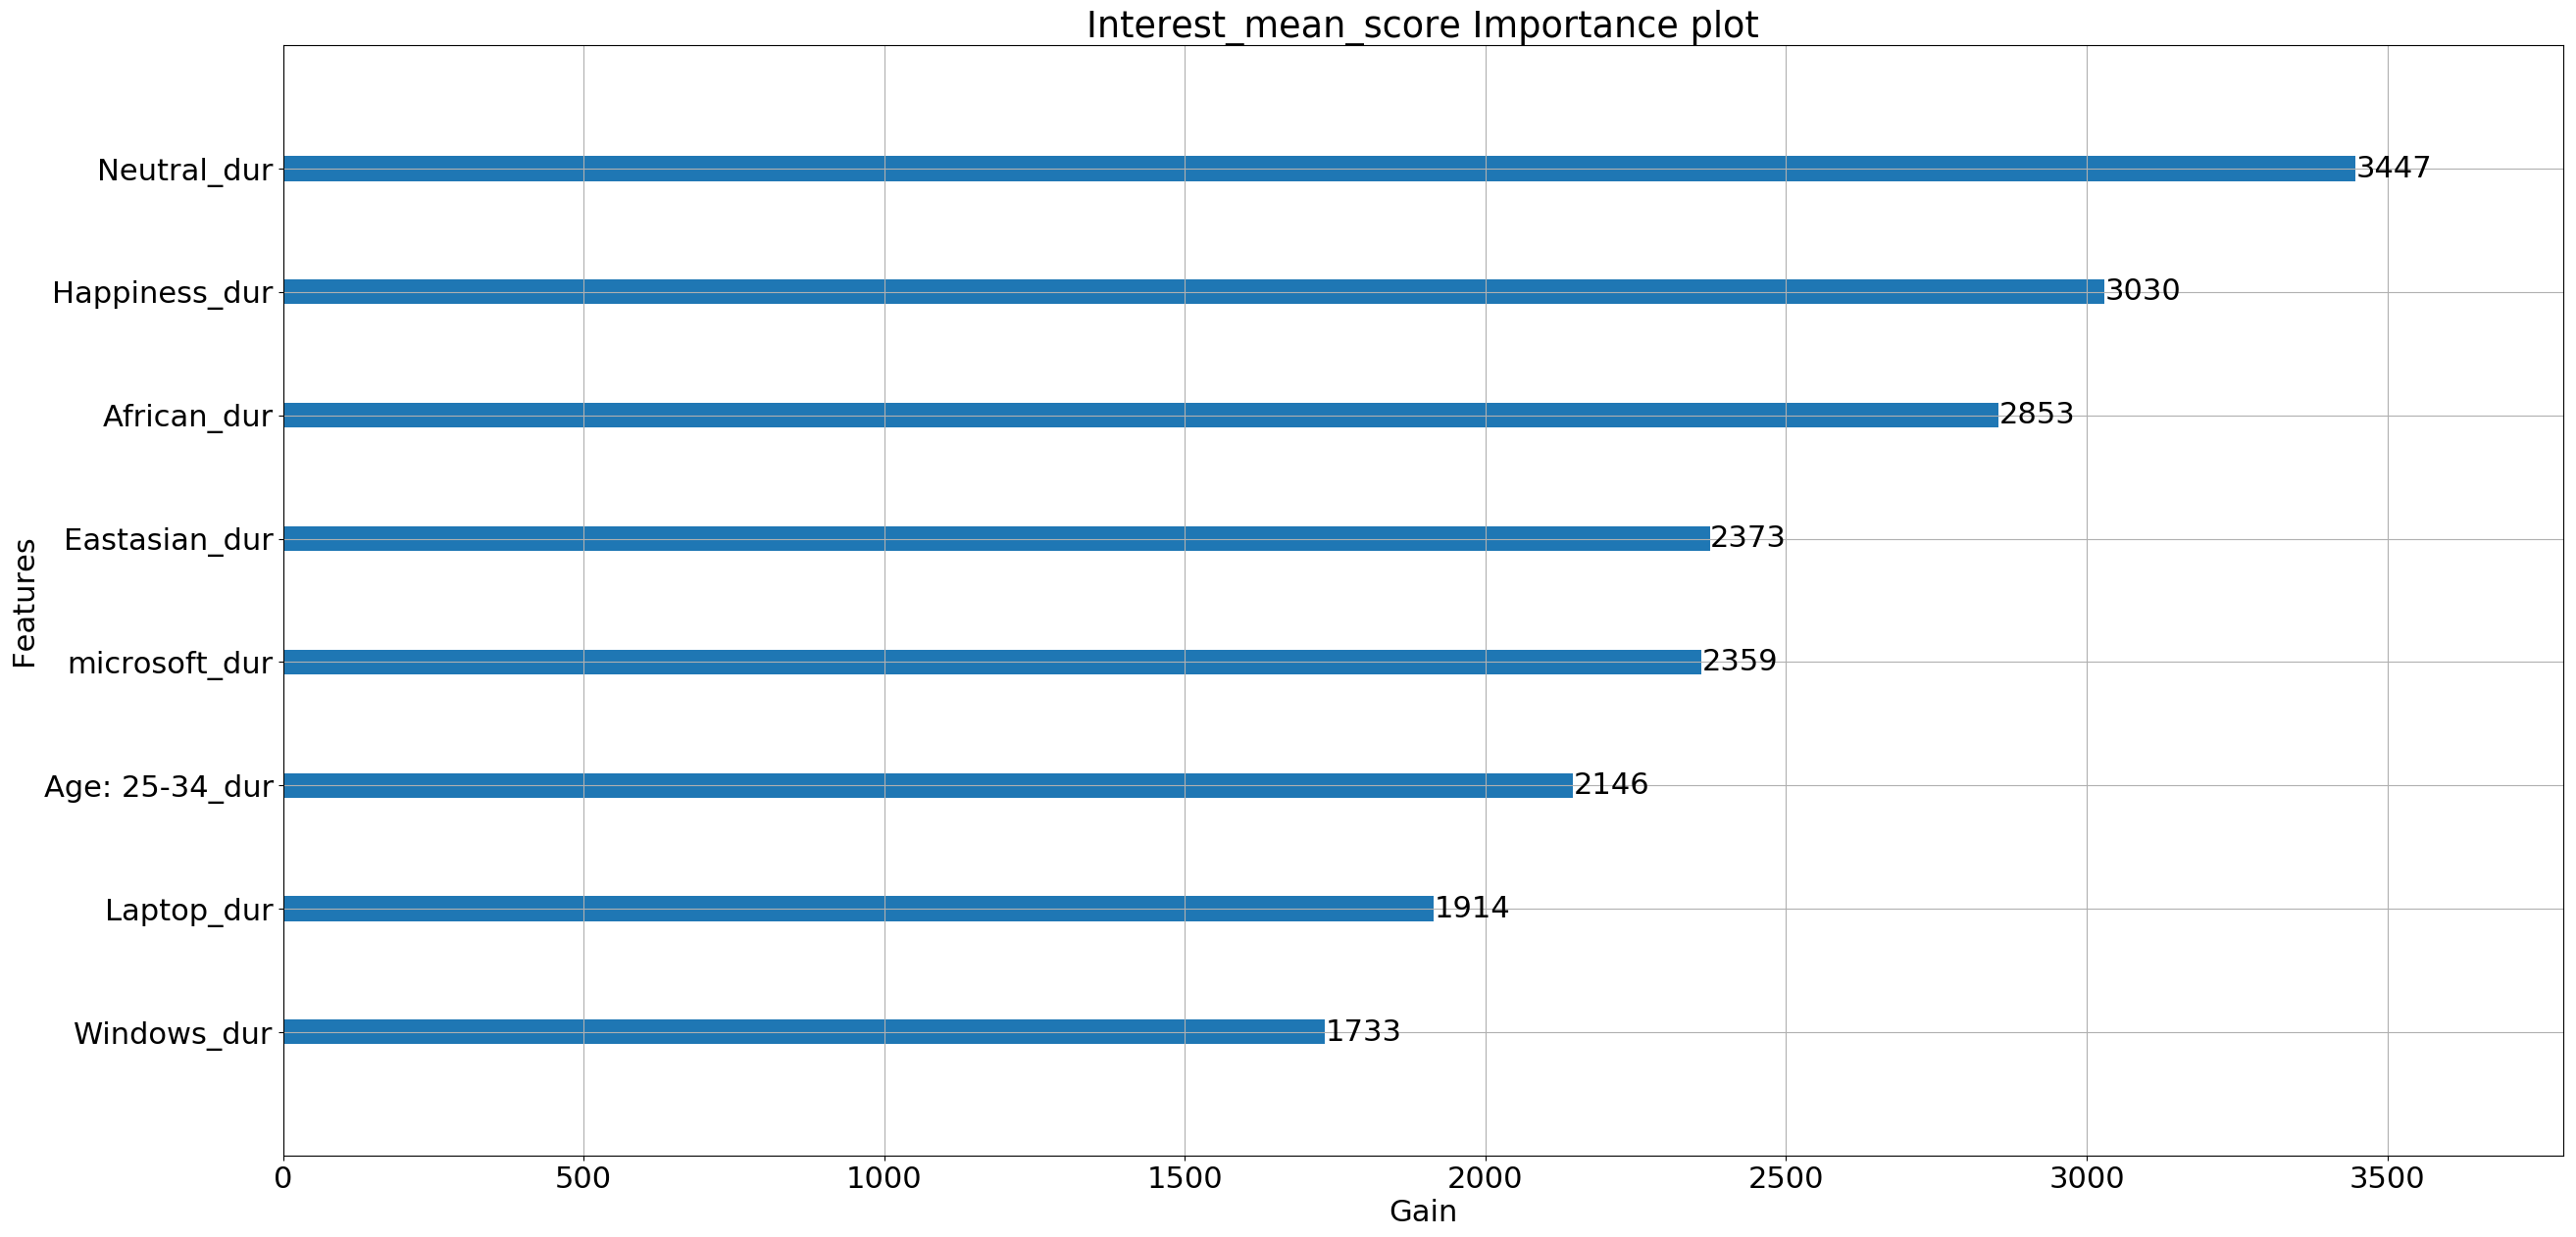

Purchase_intent
Dell_text_dur
gaming
hiking
touring
Dell_sub_brand_group_dur
using tools
sterile
sunny
Dell_dur
studying
asphalt
rugged scene
training
waiting in line
eating
clouds
soothing
conducting business
Windows_last_ocr
Hp_text_first_ocr
shopping
length_of_ad_15
congregating
Hp_text_last_ocr
microsoft_last_ocr
climbing
vertical components
exercise
cold
camping
ocean
socializing
Laptop_last_ocr
aged
sports
tiles
brick
glass
scary
glossy
Hp_first_ocr
Laptop_first_ocr
snow
Windows_first_ocr
moist
symmetrical
swimming
transporting
metal
Laptop_total_ocr
Laptop_dur
microsoft_dur
Windows_total_ocr
matte
microsoft_total_ocr
carpet
semi-enclosed area
microsoft_first_ocr
Hp_last_ocr
paper
running water
warm
wood
reading
dry
driving
Tablet_dur
horizontal components
Tablet_last_ocr
Lenovo_group_dur
ice
medical activity
research
sand
Happiness_dur
leaves
dirt
playing
flowers
Tablet_first_ocr
Lenovo_text_dur
trees
Hp_text_dur
foliage
Asus_text_dur
stressful
Sadness_dur
Female_dur
Male_dur
pa

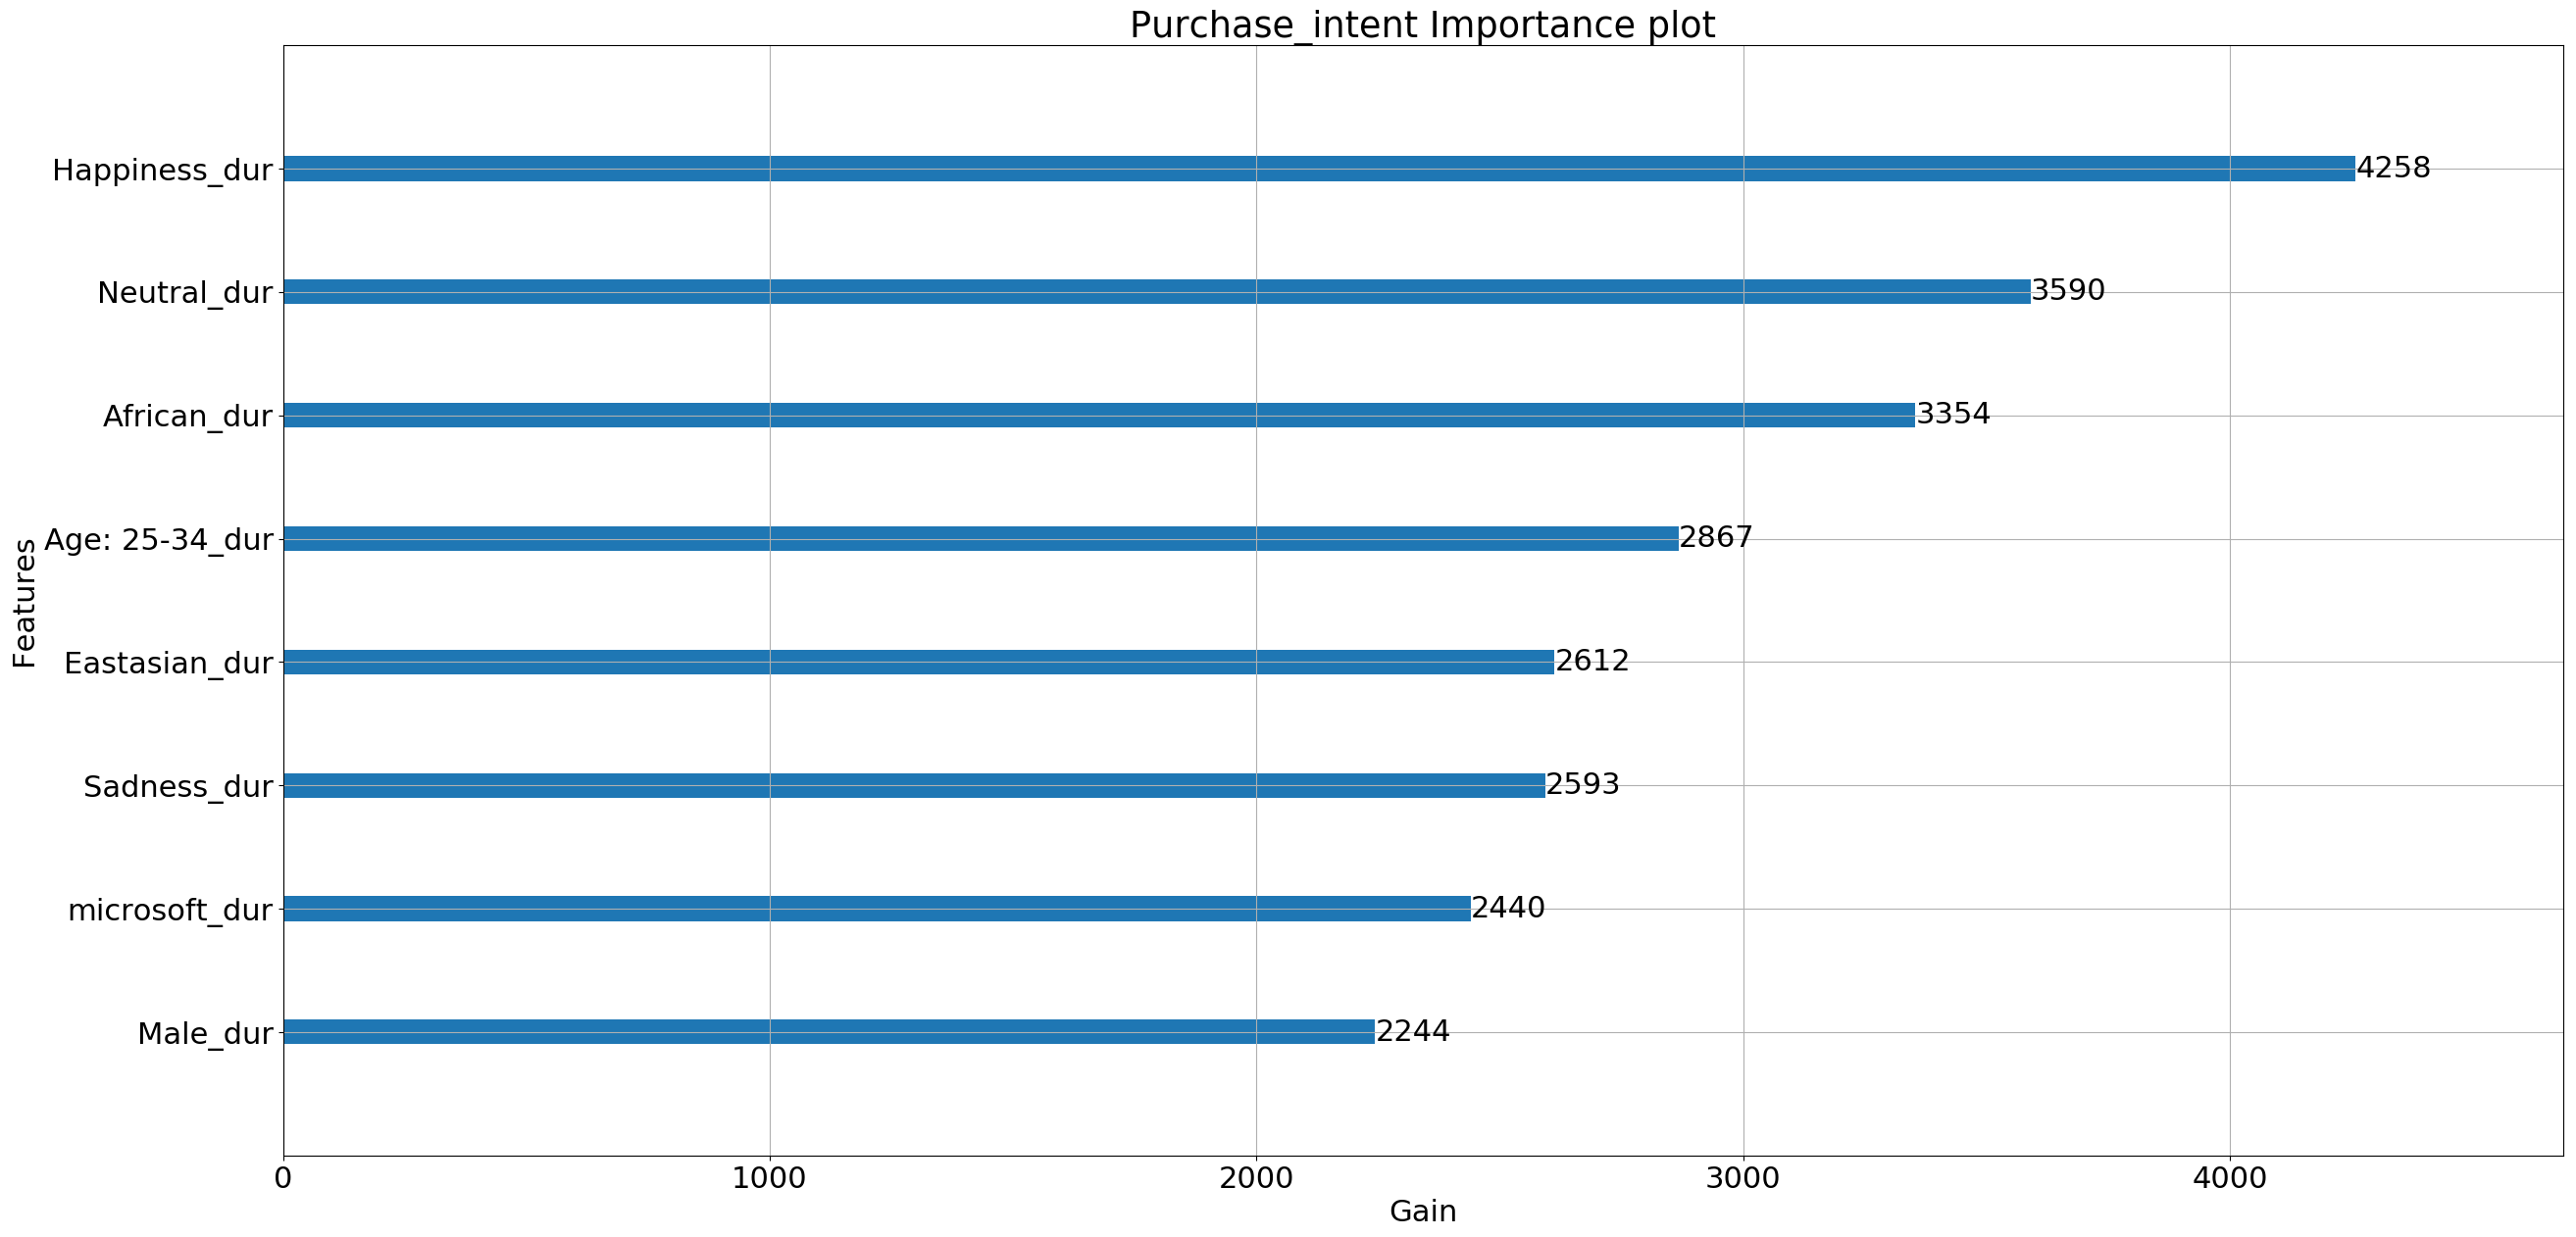

Persuasion_mean
touring
Dell_text_dur
shopping
length_of_ad_15
training
conducting business
Dell_dur
sports
microsoft_first_ocr
cold
Windows_last_ocr
Happiness_dur
Laptop_last_ocr
Age: 25-34_dur
Eastasian_dur
Neutral_dur
warm
Lenovo_group_dur
Sadness_dur
sunny
Hp_last_ocr
Laptop_first_ocr
socializing
carpet
African_dur
HP_group_dur
Hp_first_ocr
microsoft_dur
Female_dur
natural light
microsoft_last_ocr
moist
Laptop_total_ocr
metal
symmetrical
waiting in line
flowers
Male_dur
Windows_first_ocr
microsoft_total_ocr
transporting
Asus_dur
hiking
exercise
ASUS T102_dur
Laptop_dur
soothing
scary
Age: 35-44_dur
ocean
research
medical activity
Windows_dur
Asus_text_dur
Yoga_dur
horizontal components
Age: 15-24_dur
cluttered space
Dell_sub_brand_group_dur
asphalt
tiles
grass
Lenovo_text_dur
sterile
Hp_total_ocr
Tablet_dur
dry
far-away horizon
clouds
reading
Hp_dur
gaming
eating
natural
congregating
aged
using tools
driving
Hp_text_dur
playing
snow
paper
climbing
leaves
plastic
sand
dirt
glass
spe

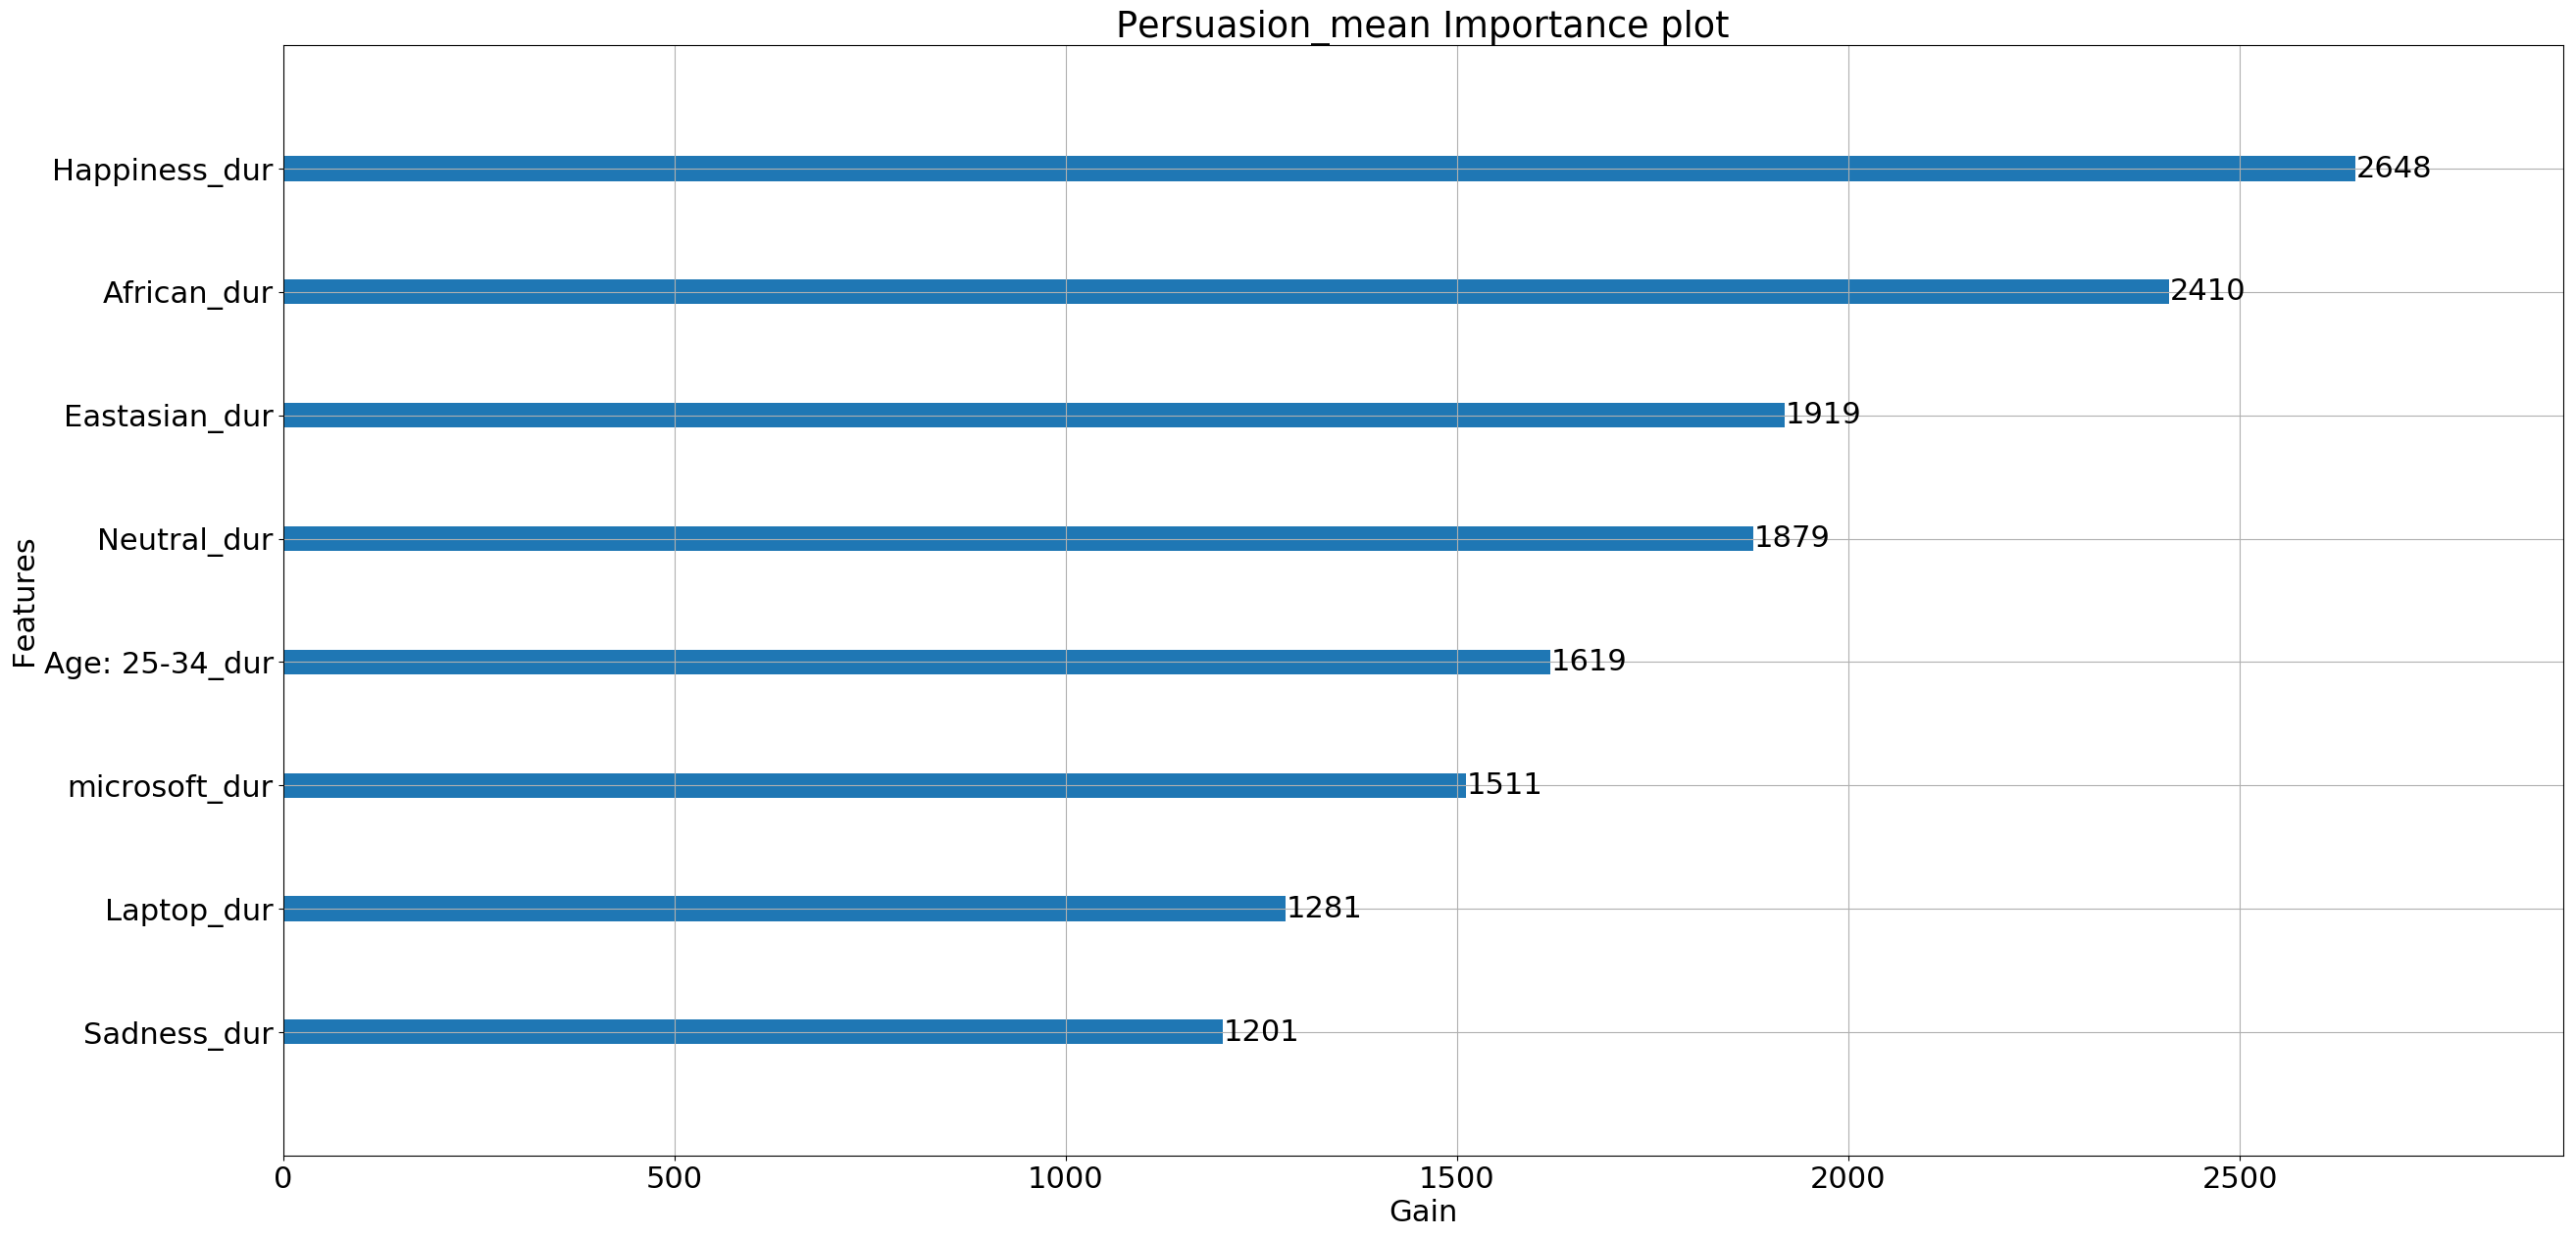

Persuasion_very_likely
touring
Dell_text_dur
moist
shopping
conducting business
reading
Dell_dur
Laptop_last_ocr
training
Hp_text_total_ocr
waiting in line
sunny
sports
vertical components
climbing
sterile
Age: 35-44_dur
Lenovo_group_dur
spectating
Happiness_dur
natural
Windows_last_ocr
Neutral_dur
cold
microsoft_first_ocr
railing
snow
still water
Dell_sub_brand_group_dur
length_of_ad_15
using tools
driving
glass
soothing
metal
Female_dur
Eastasian_dur
Hp_text_dur
exercise
horizontal components
Windows_first_ocr
playing
leaves
glossy
asphalt
Laptop_first_ocr
brick
Male_dur
Hp_text_last_ocr
research
Hp_text_first_ocr
dry
Age: 25-34_dur
Sadness_dur
diving
warm
microsoft_last_ocr
ice
running water
Laptop_dur
scary
foliage
dirt
Windows_dur
trees
congregating
grass
swimming
boating
aged
Tablet_first_ocr
natural light
microsoft_dur
transporting
African_dur
clouds
Tablet_dur
microsoft_total_ocr
studying
ocean
eating
cluttered space
Windows_total_ocr
Age: 15-24_dur
carpet
Lenovo_text_dur
semi-

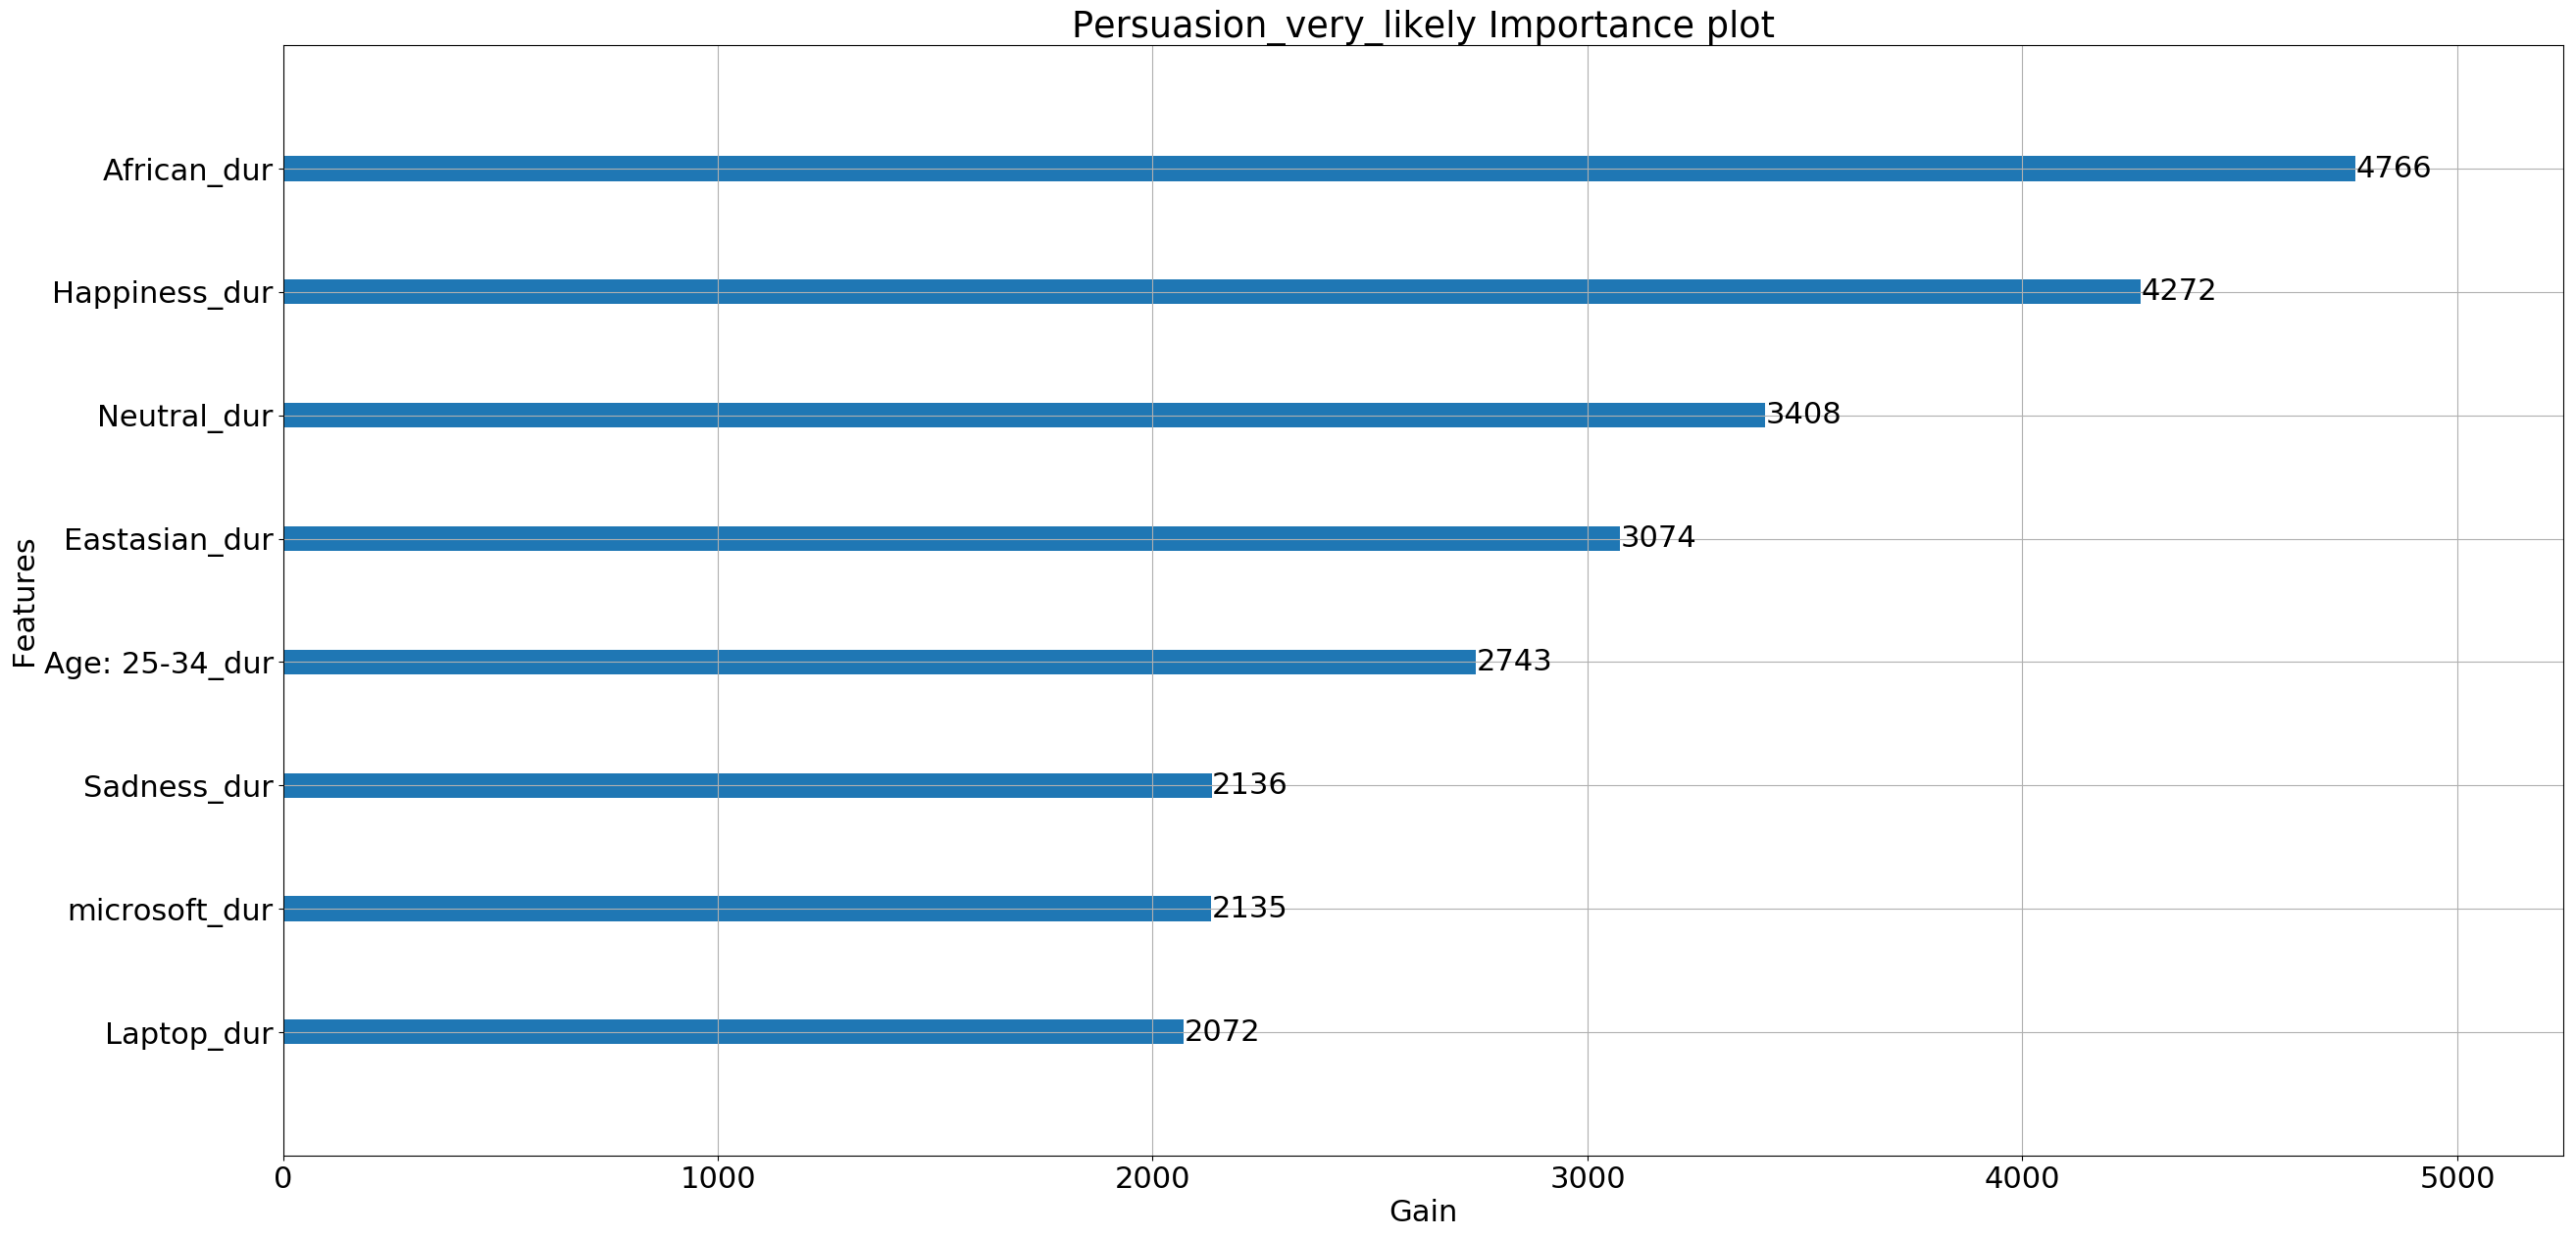

Interest_peak_frames
Dell_text_dur
touring
length_of_ad_15
semi-enclosed area
pavement
shopping
gaming
training
Windows_last_ocr
wood
Windows_first_ocr
conducting business
microsoft_first_ocr
sports
socializing
snow
Dell_dur
matte
soothing
swimming
biking
Laptop_total_ocr
Laptop_first_ocr
playing
natural light
trees
transporting
clouds
moist
railing
Female_dur
microsoft_last_ocr
research
paper
tiles
sunny
flowers
Age: 15-24_dur
microsoft_dur
far-away horizon
Laptop_dur
Asus_text_dur
Laptop_last_ocr
ASUS T102_dur
sand
studying
sterile
driving
Windows_dur
exercise
using tools
Hp_total_ocr
Surface_group_dur
Male_dur
Asus_dur
asphalt
glossy
microsoft_total_ocr
Neutral_dur
metal
Hp_text_last_ocr
Eastasian_dur
cluttered space
Happiness_dur
Tablet_total_ocr
aged
African_dur
carpet
eating
ocean
Hp_text_first_ocr
plastic
spectating
grass
dry
scary
waiting in line
medical activity
Windows_total_ocr
Sadness_dur
HP_group_dur
vertical components
Age: 35-44_dur
horizontal components
Dell_sub_brand_g

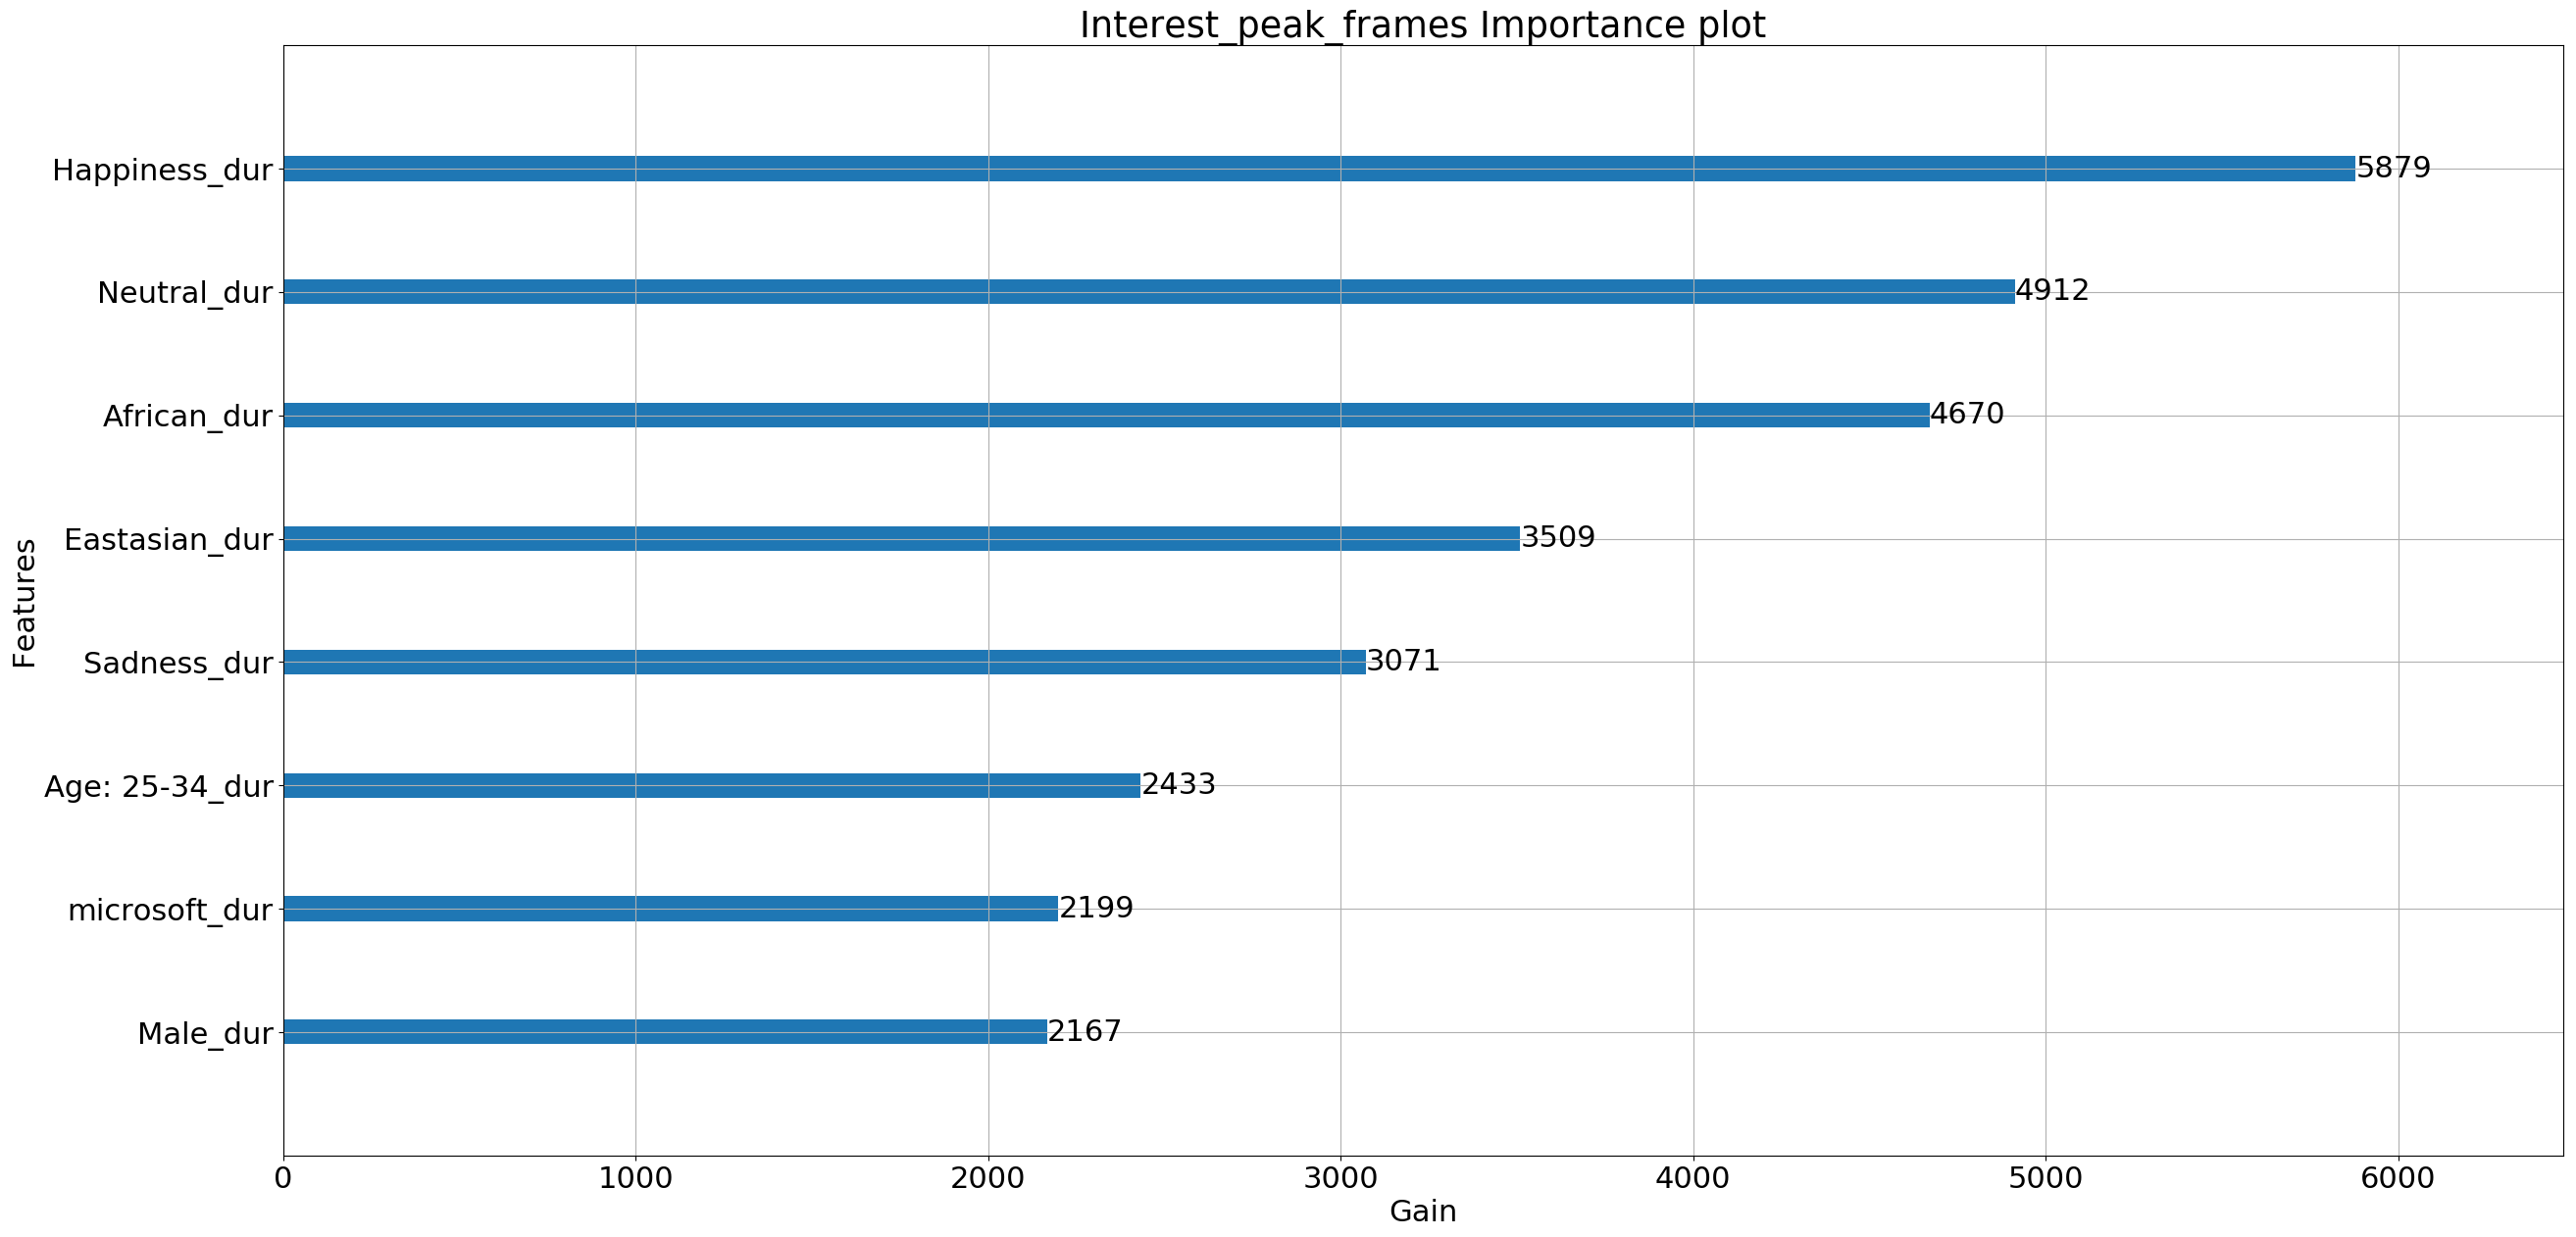

Enjoyment_vey_much
length_of_ad_15
Windows_last_ocr
rugged scene
training
microsoft_last_ocr
natural light
Windows_first_ocr
flowers
sunny
semi-enclosed area
medical activity
Laptop_last_ocr
reading
carpet
microsoft_first_ocr
swimming
Lenovo_text_dur
Laptop_dur
driving
sterile
soothing
Yoga_dur
shopping
fire
cluttered space
warm
dirty
Dell_text_dur
matte
moist
exercise
dry
railing
sand
waiting in line
using tools
microsoft_total_ocr
ice
running water
Hp_last_ocr
biking
shrubbery
Laptop_total_ocr
Tablet_dur
Lenovo_group_dur
Hp_text_dur
wood
clouds
Hp_first_ocr
Tablet_total_ocr
sports
studying
pavement
gaming
cold
touring
microsoft_dur
aged
Age: 25-34_dur
ocean
Hp_text_last_ocr
Asus_dur
Male_dur
Age: 35-44_dur
Age: 15-24_dur
eating
HP_group_dur
Windows_total_ocr
Hp_text_total_ocr
Tablet_first_ocr
Windows_dur
symmetrical
scary
snow
asphalt
far-away horizon
transporting
Hp_text_first_ocr
congregating
horizontal components
Tablet_last_ocr
Happiness_dur
Neutral_dur
glass
Dell_dur
dirt
Sadnes

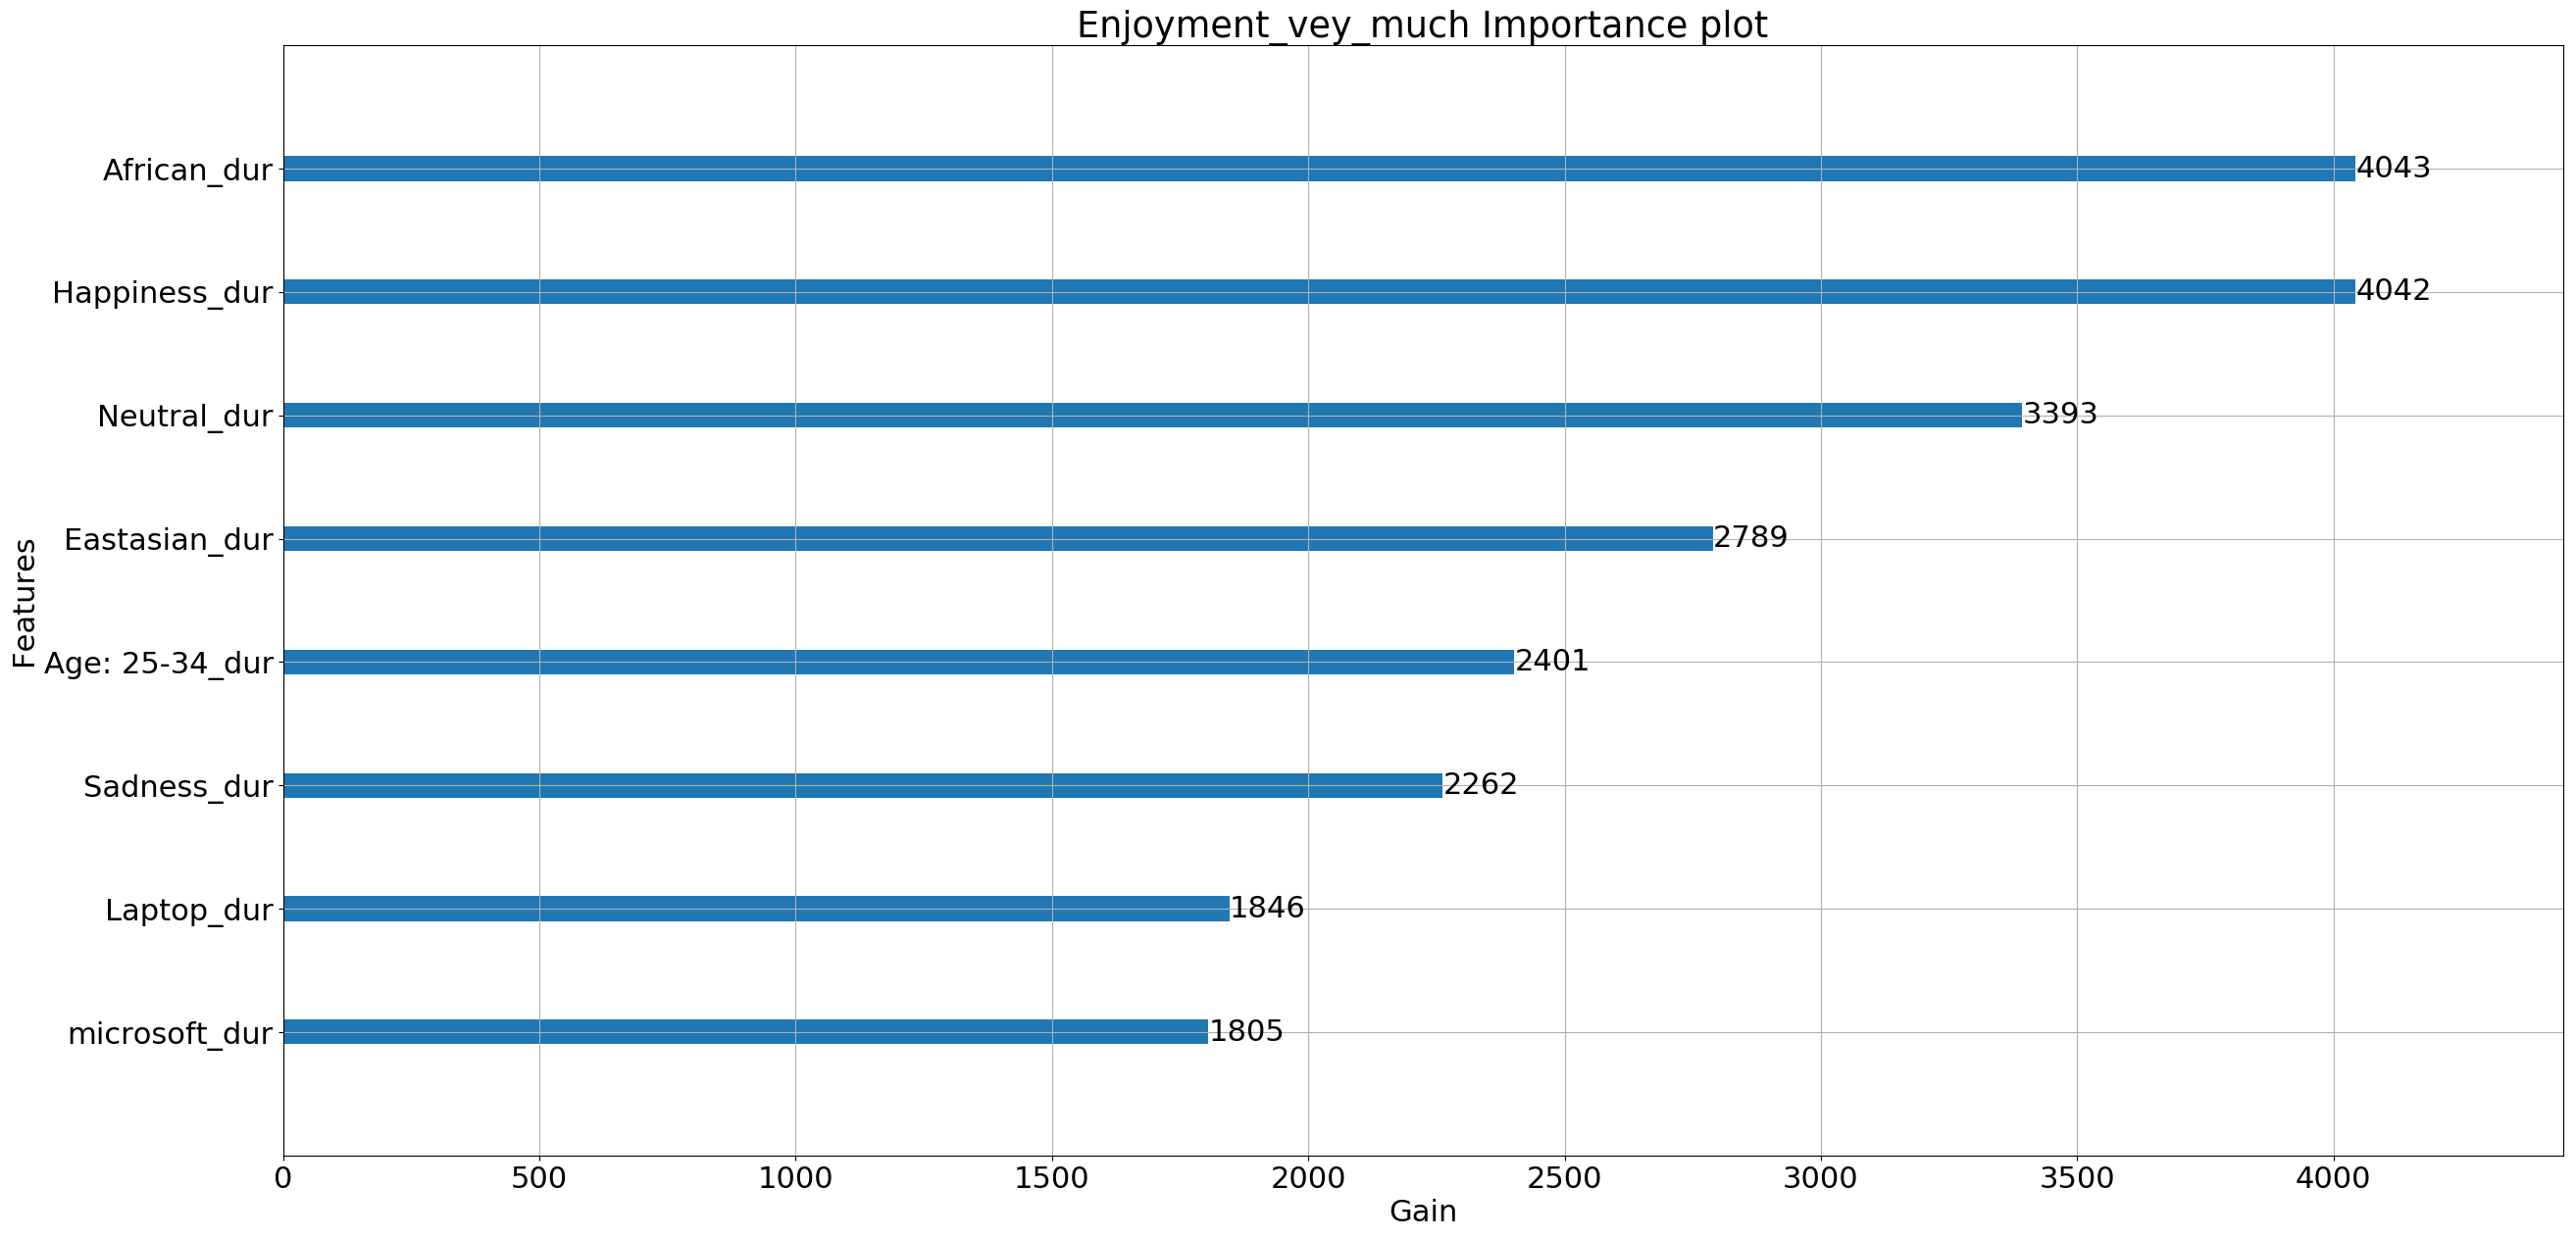

Aided_Branding_almost_anything
horizontal components
natural light
flowers
trees
sunny
medical activity
wood
swimming
glass
gaming
carpet
touring
snow
scary
ocean
leaves
clouds
eating
dirt
dry
soothing
waiting in line
vegetation
Age: 25-34_dur
Laptop_total_ocr
Windows_total_ocr
microsoft_dur
far-away horizon
Laptop_first_ocr
matte
hiking
Surface_group_dur
exercise
congregating
Male_dur
symmetrical
Hp_text_first_ocr
Windows_first_ocr
Tablet_first_ocr
training
Dell_dur
driving
research
semi-enclosed area
metal
Neutral_dur
reading
Asus_dur
microsoft_total_ocr
shrubbery
spectating
Hp_text_last_ocr
Hp_text_dur
transporting
natural
pavement
ASUS T102_dur
Hp_text_total_ocr
stressful
Laptop_dur
Happiness_dur
asphalt
warm
Windows_dur
microsoft_last_ocr
Laptop_last_ocr
diving
Windows_last_ocr
sand
brick
grass
Tablet_last_ocr
railing
sports
plastic
Tablet_dur
foliage
playing
Age: 15-24_dur
Asus_text_dur
Sadness_dur
Dell_text_dur
Hp_total_ocr
sterile
Hp_first_ocr
cluttered space
still water
Tablet

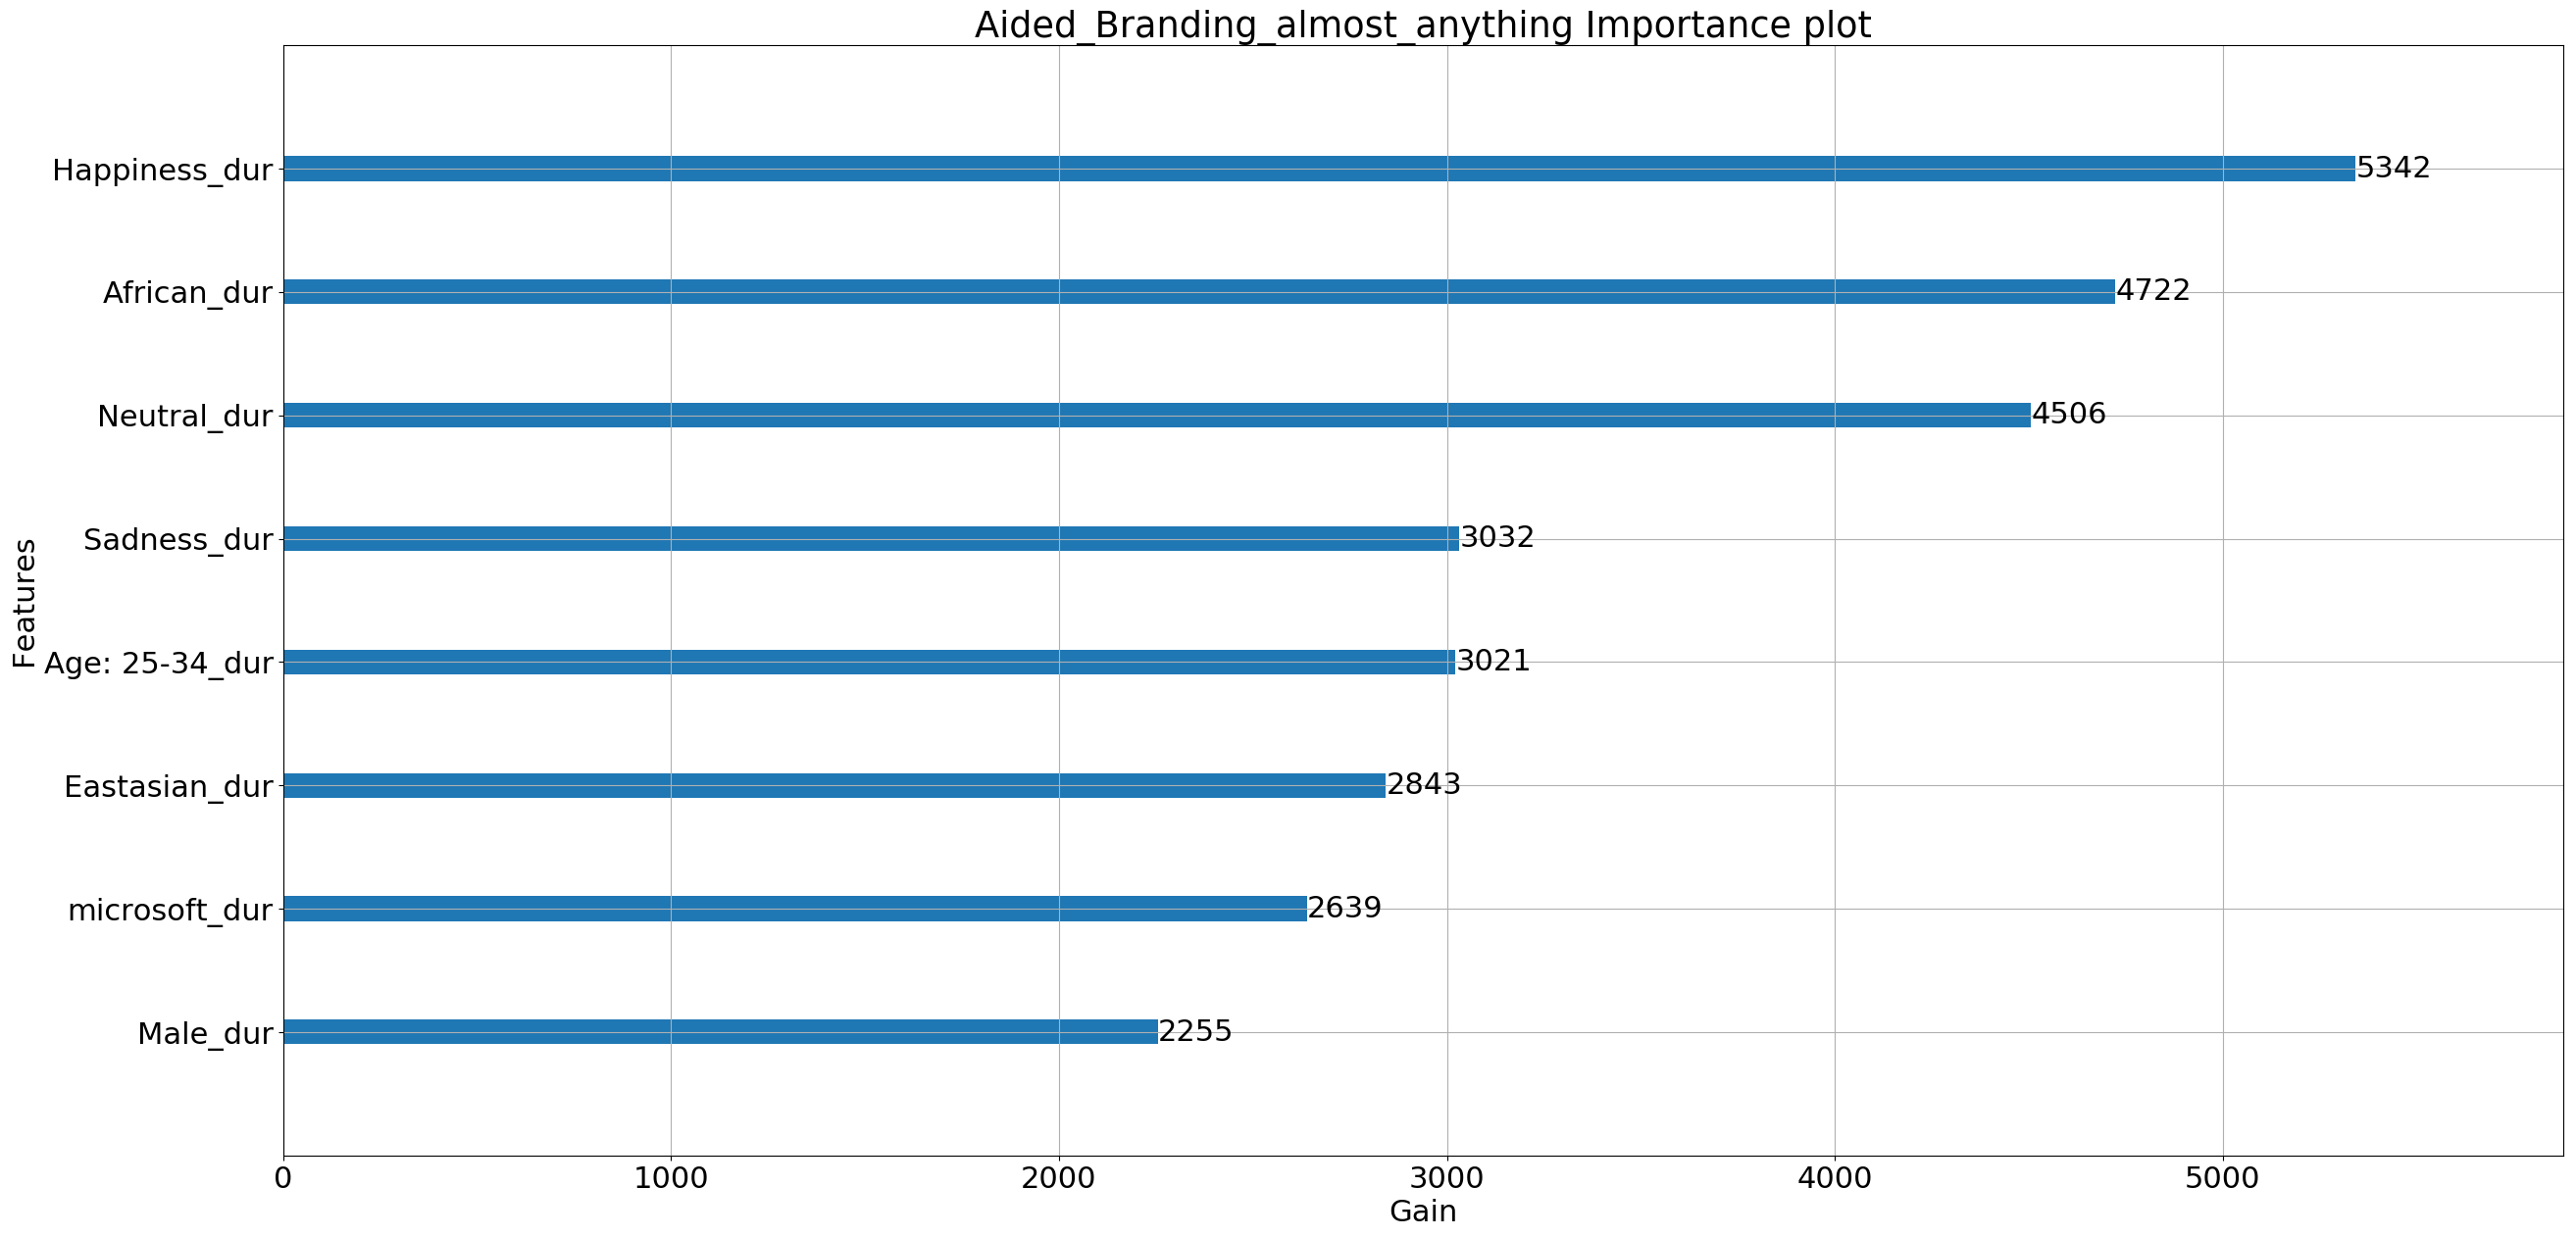

Brand_Cues_very_easily
rugged scene
glossy
soothing
Windows_last_ocr
natural light
reading
training
flowers
shopping
trees
glass
Laptop_total_ocr
vegetation
length_of_ad_15
medical activity
sunny
Yoga_dur
Laptop_last_ocr
fire
clouds
using tools
asphalt
carpet
plastic
warm
sports
sterile
microsoft_last_ocr
exercise
Dell_text_dur
vertical components
scary
studying
Age: 25-34_dur
sand
Laptop_first_ocr
transporting
Lenovo_group_dur
ocean
snow
ASUS T102_dur
Asus_text_dur
Hp_text_first_ocr
Windows_first_ocr
horizontal components
Tablet_total_ocr
waiting in line
conducting business
still water
metal
congregating
Asus_dur
moist
stressful
leaves
aged
Tablet_first_ocr
Hp_text_dur
Dell_dur
Age: 15-24_dur
socializing
semi-enclosed area
boating
Lenovo_text_dur
Hp_first_ocr
driving
touring
dry
brick
Hp_total_ocr
Male_dur
Tablet_last_ocr
Hp_last_ocr
matte
microsoft_first_ocr
Dell_sub_brand_group_dur
microsoft_dur
Laptop_dur
Hp_text_total_ocr
natural
playing
Sadness_dur
tiles
African_dur
Happiness_dur

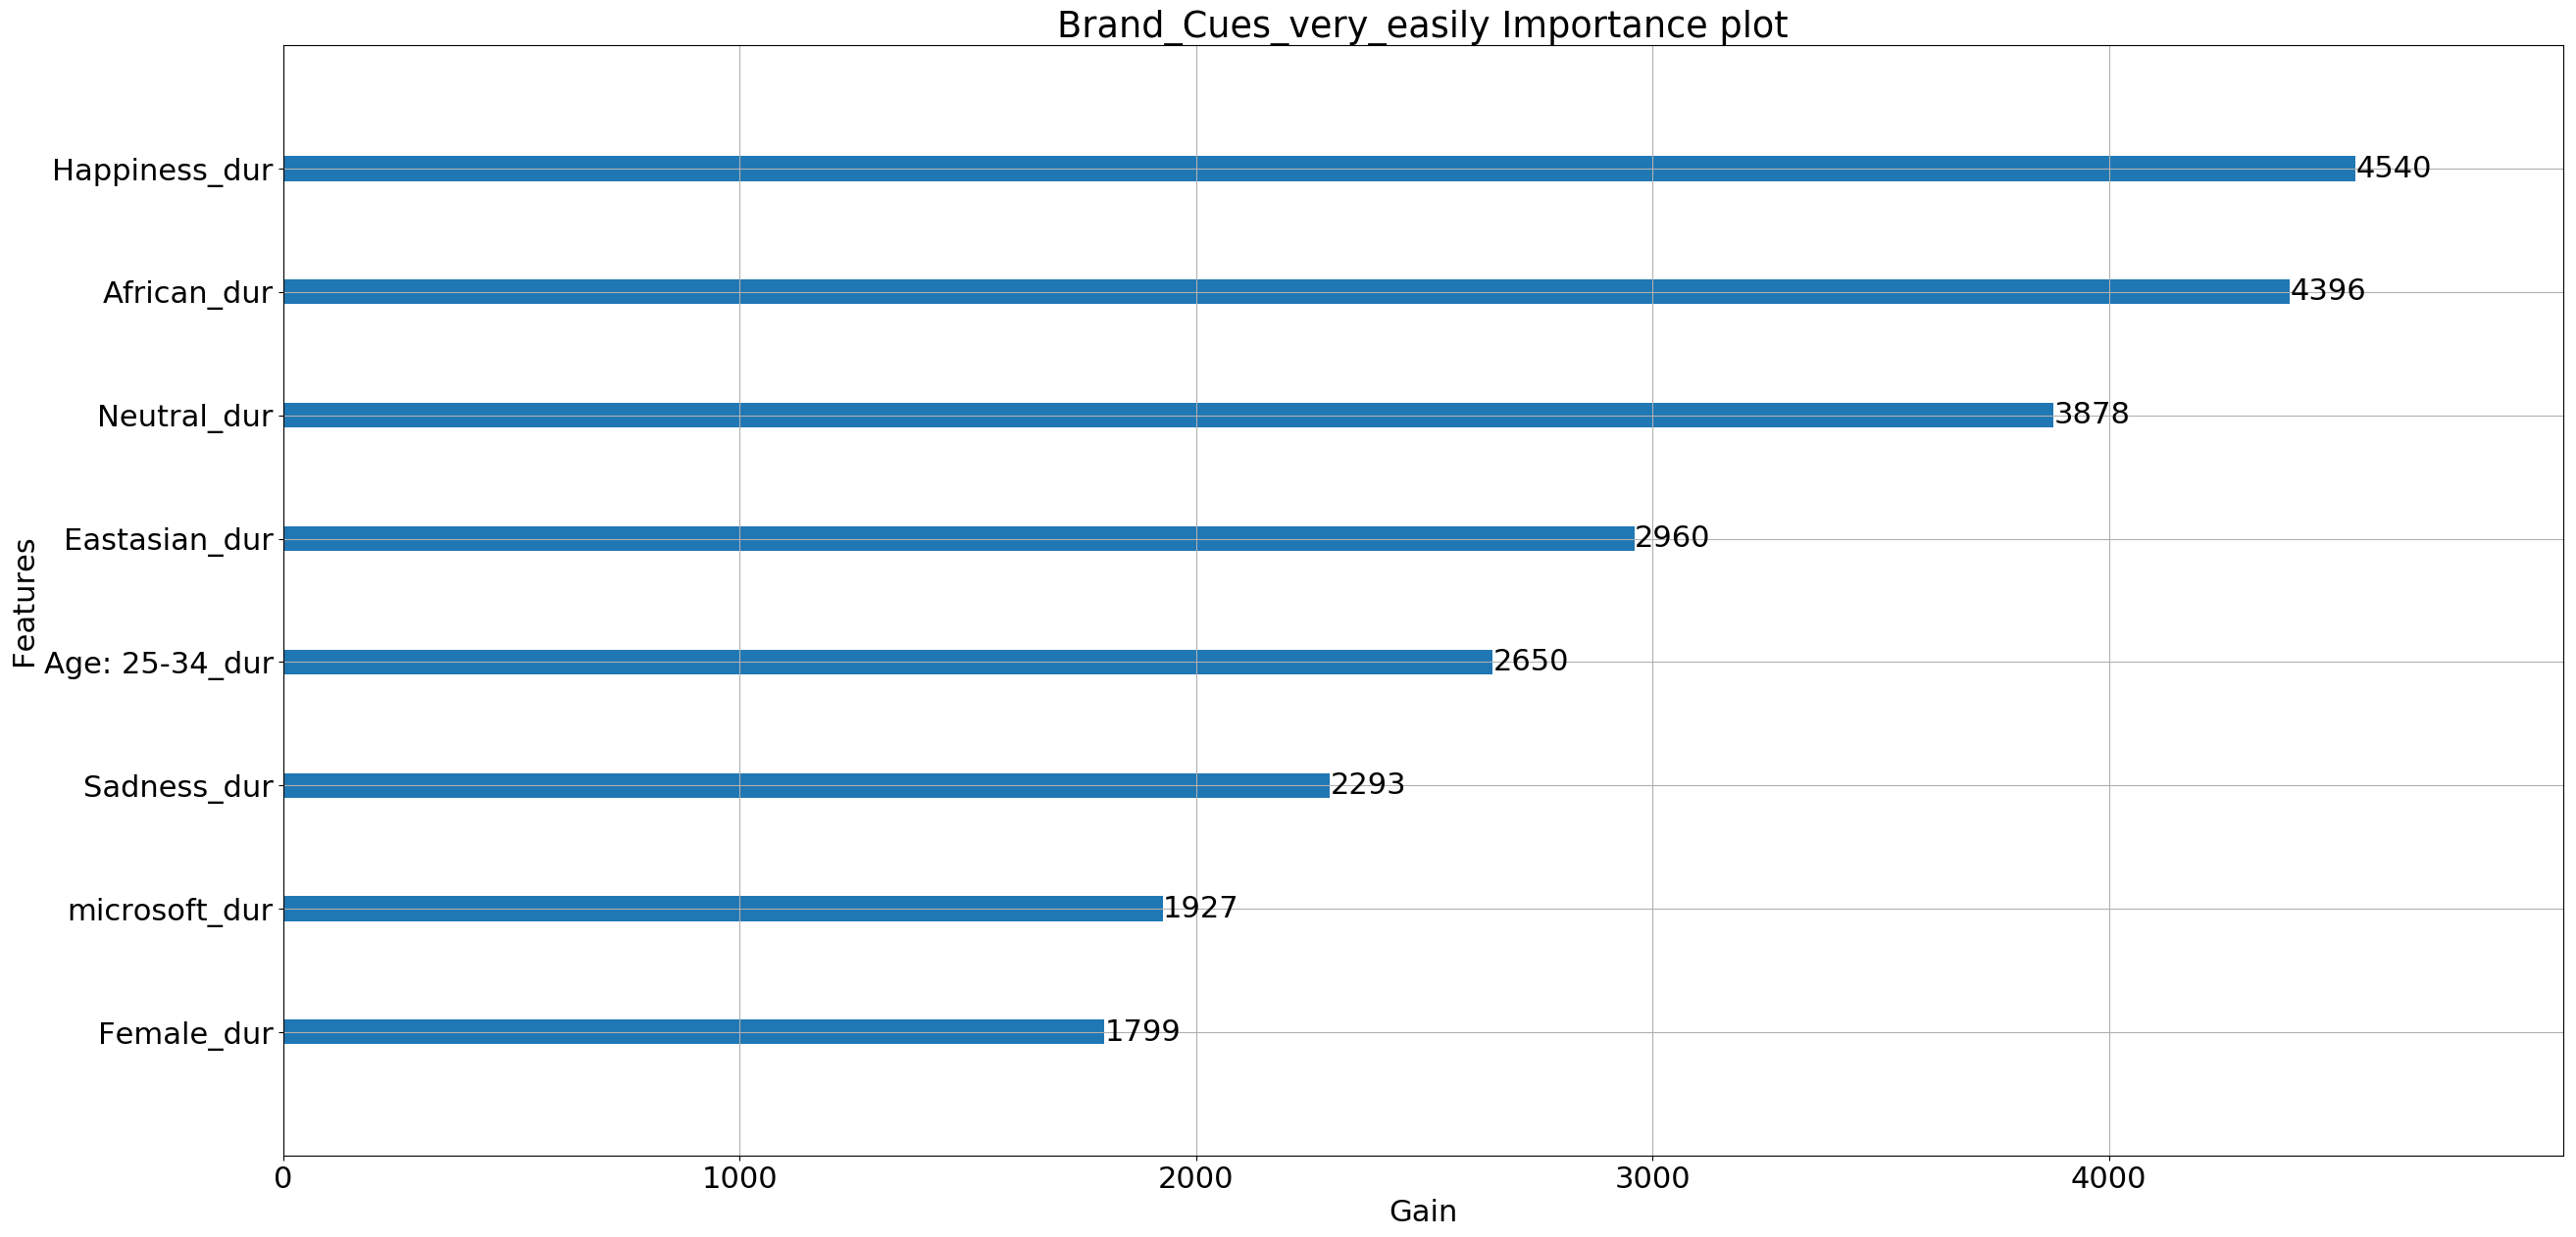

Brand_Appeal_more_appealing
length_of_ad_15
Windows_last_ocr
training
fire
metal
microsoft_last_ocr
Yoga_dur
sand
flowers
soothing
medical activity
microsoft_first_ocr
Windows_first_ocr
waiting in line
Laptop_last_ocr
sunny
Lenovo_text_dur
natural light
carpet
cold
still water
rugged scene
warm
clouds
exercise
conducting business
aged
wood
Laptop_total_ocr
sports
Asus_dur
ASUS T102_dur
socializing
transporting
touring
biking
sterile
vertical components
Lenovo_group_dur
Asus_text_dur
Age: 35-44_dur
Windows_total_ocr
stressful
far-away horizon
Hp_dur
semi-enclosed area
Hp_total_ocr
driving
studying
Hp_last_ocr
reading
Hp_text_total_ocr
Tablet_dur
brick
using tools
microsoft_total_ocr
research
dry
glass
Age: 15-24_dur
Dell_dur
congregating
Hp_text_first_ocr
Hp_text_dur
trees
moist
eating
Hp_first_ocr
Tablet_total_ocr
Windows_dur
Hp_text_last_ocr
matte
shopping
microsoft_dur
paper
ocean
Neutral_dur
natural
glossy
symmetrical
leaves
Laptop_dur
playing
cluttered space
boating
Tablet_first_oc

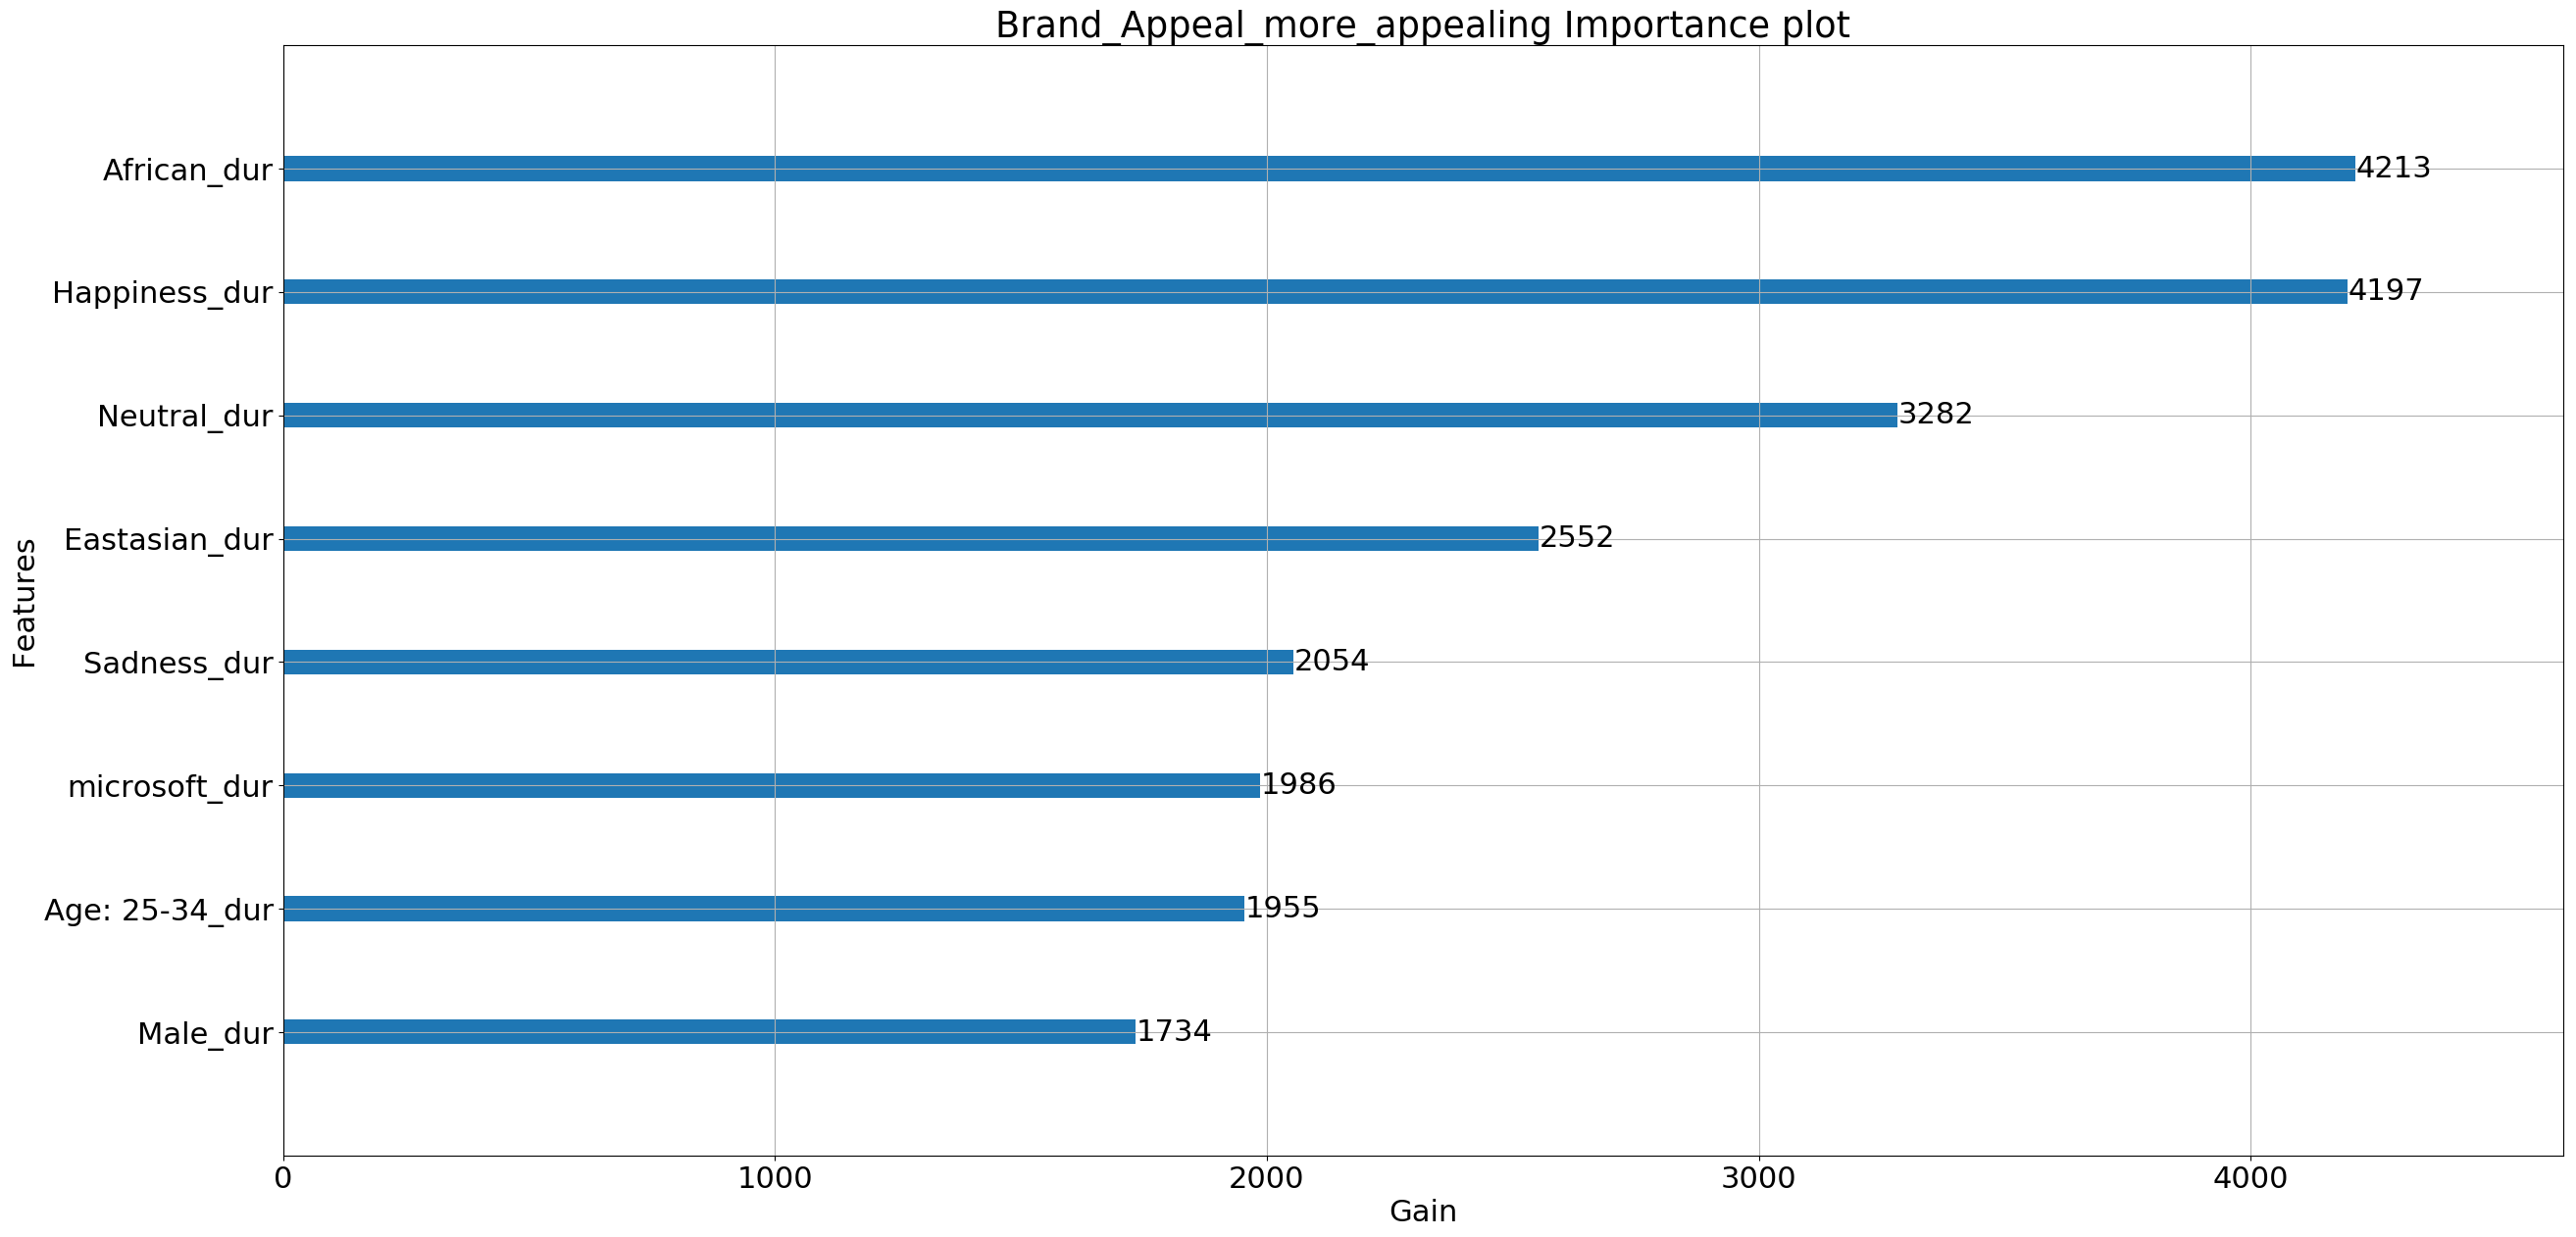

Understanding_very_easily
soothing
waiting in line
vertical components
congregating
stressful
sunny
studying
grass
rugged scene
microsoft_last_ocr
metal
shopping
trees
Male_dur
glass
conducting business
touring
shrubbery
matte
microsoft_dur
Windows_last_ocr
Lenovo_text_dur
dry
Hp_text_dur
glossy
clouds
Female_dur
Hp_first_ocr
medical activity
carpet
length_of_ad_15
Dell_text_dur
sterile
using tools
microsoft_first_ocr
Hp_text_total_ocr
moist
Hp_total_ocr
Tablet_total_ocr
semi-enclosed area
Hp_last_ocr
microsoft_total_ocr
horizontal components
Laptop_dur
foliage
Tablet_last_ocr
Neutral_dur
Dell_dur
leaves
Hp_text_first_ocr
Laptop_total_ocr
transporting
Age: 15-24_dur
gaming
cluttered space
still water
flowers
reading
playing
Windows_first_ocr
exercise
natural light
Tablet_first_ocr
Tablet_dur
paper
Sadness_dur
ASUS T102_dur
plastic
Age: 25-34_dur
cold
Hp_text_last_ocr
sand
spectating
asphalt
training
sports
Hp_dur
biking
Asus_dur
Asus_text_dur
symmetrical
research
aged
boating
Windows_t

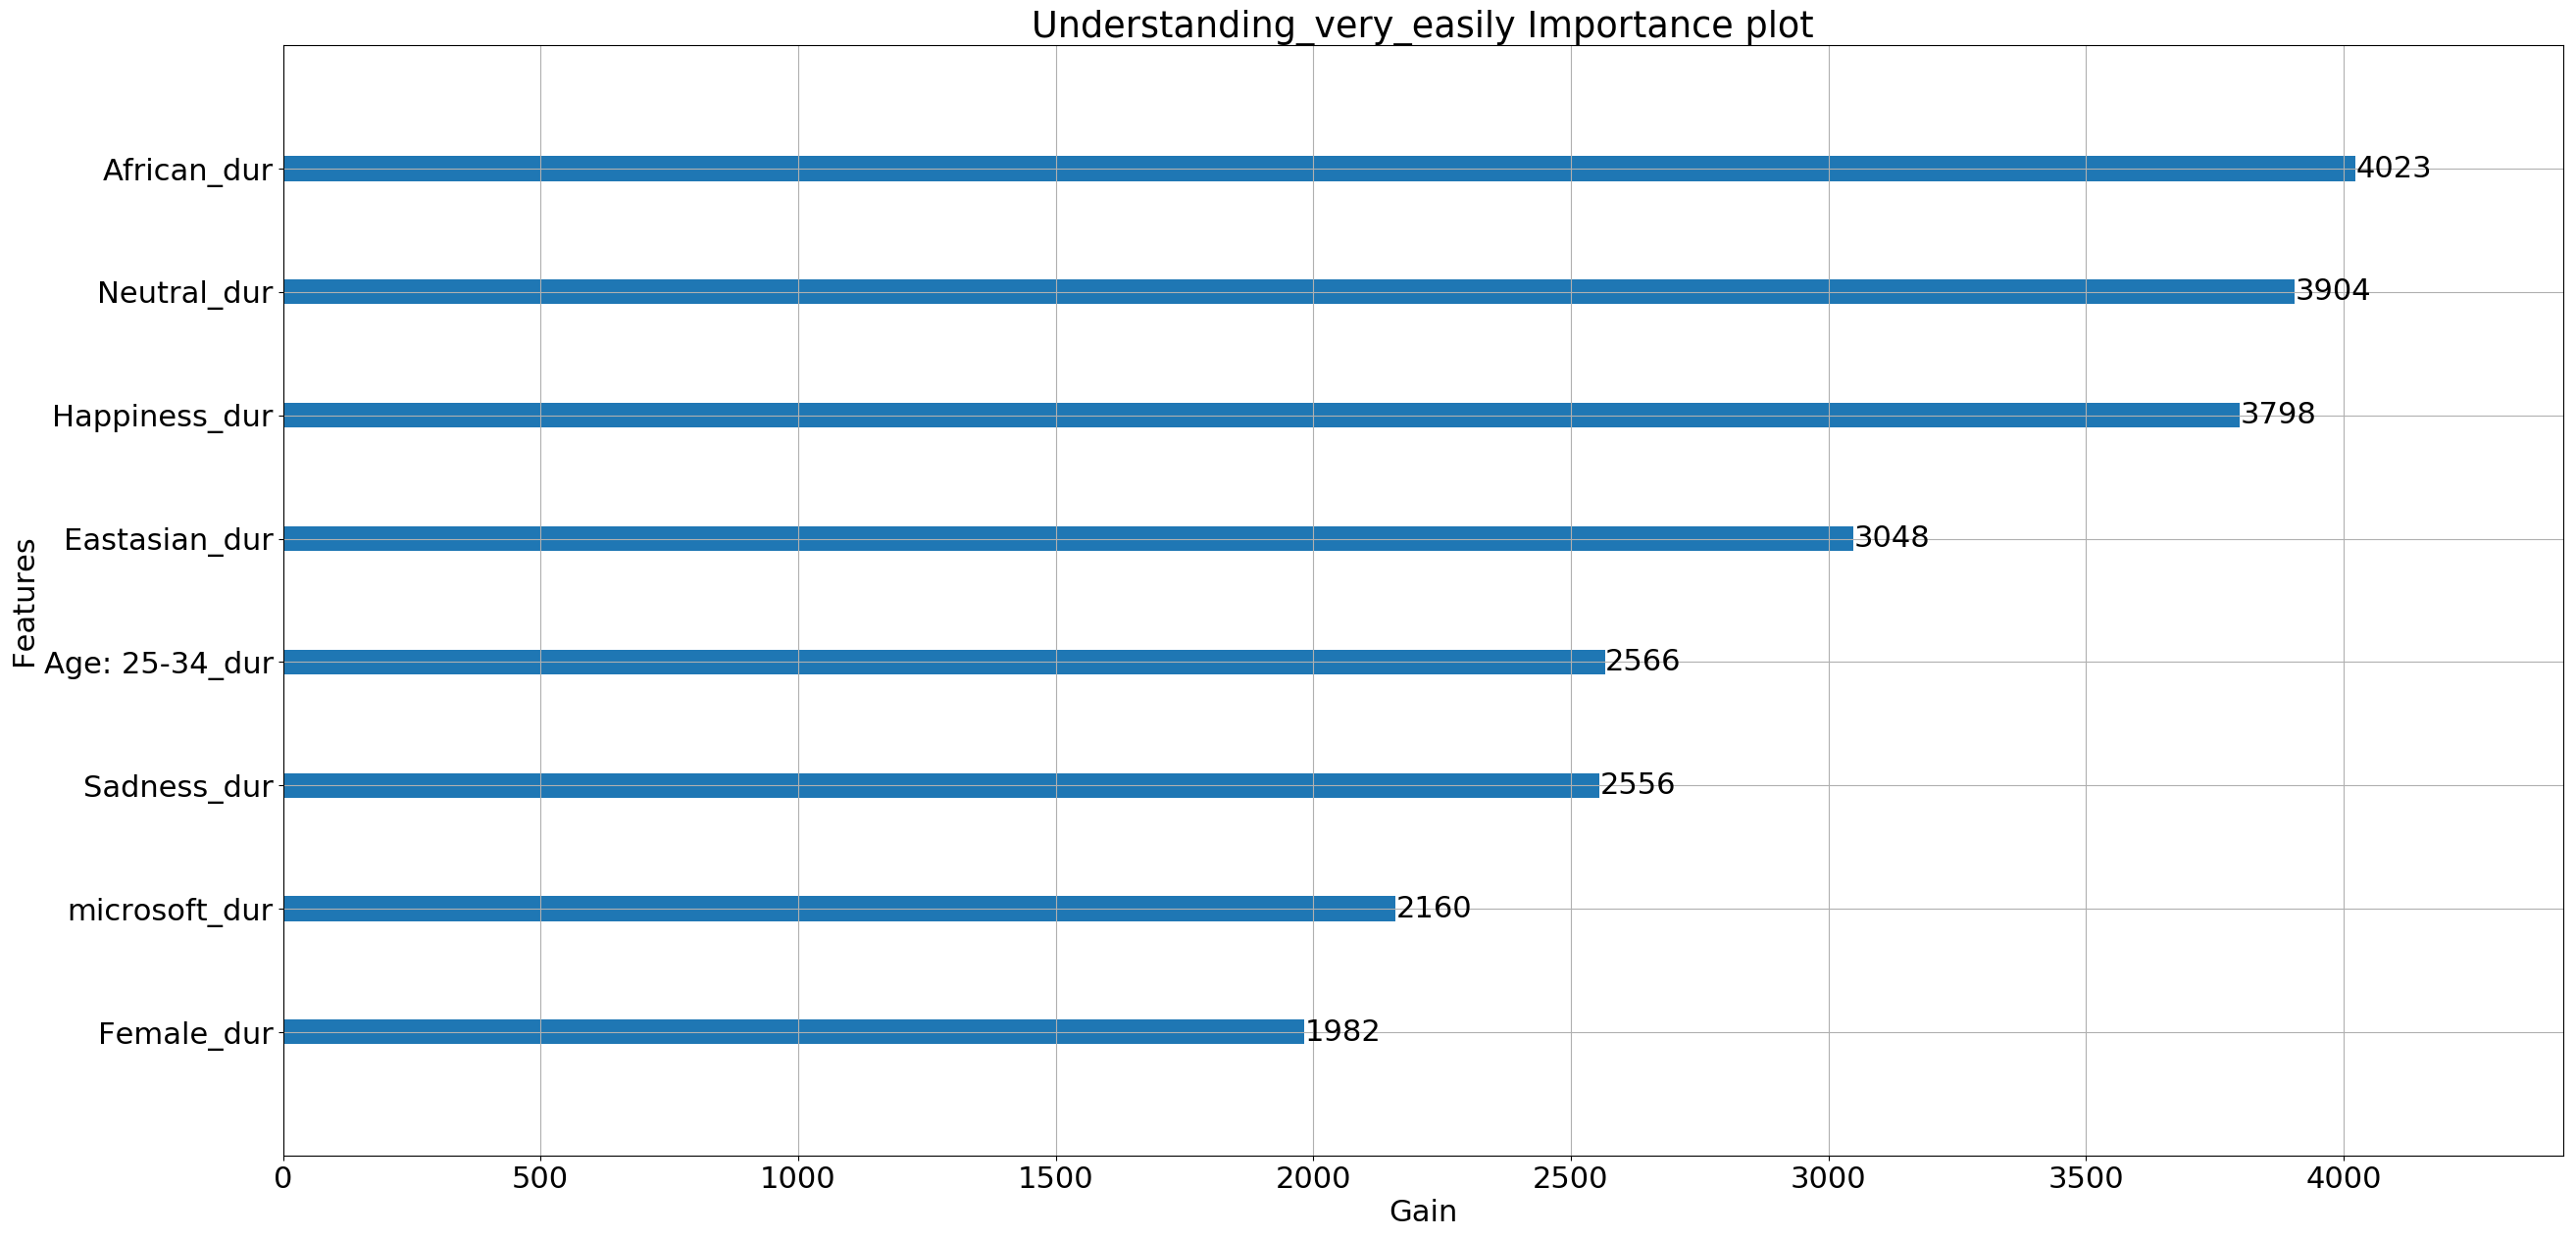

Relevance_Information_very_relevant
soothing
microsoft_last_ocr
carpet
medical activity
natural light
length_of_ad_15
Asus_text_dur
Windows_last_ocr
ASUS T102_dur
flowers
waiting in line
clouds
microsoft_first_ocr
studying
congregating
matte
training
exercise
Age: 35-44_dur
Asus_dur
metal
railing
aged
gaming
dry
conducting business
stressful
sand
Laptop_first_ocr
boating
fire
socializing
Hp_text_total_ocr
Laptop_last_ocr
eating
driving
Windows_first_ocr
cluttered space
touring
symmetrical
Hp_text_dur
Age: 25-34_dur
Surface_group_dur
Lenovo_group_dur
Age: 15-24_dur
microsoft_dur
warm
scary
Laptop_total_ocr
still water
Hp_text_last_ocr
Yoga_dur
dirty
horizontal components
Tablet_first_ocr
Laptop_dur
wood
glossy
Tablet_last_ocr
running water
reading
Happiness_dur
Hp_text_first_ocr
playing
Tablet_total_ocr
Neutral_dur
research
Windows_total_ocr
spectating
sunny
snow
sports
vertical components
HP_group_dur
grass
sterile
swimming
microsoft_total_ocr
ocean
asphalt
shopping
Dell_text_dur
glass

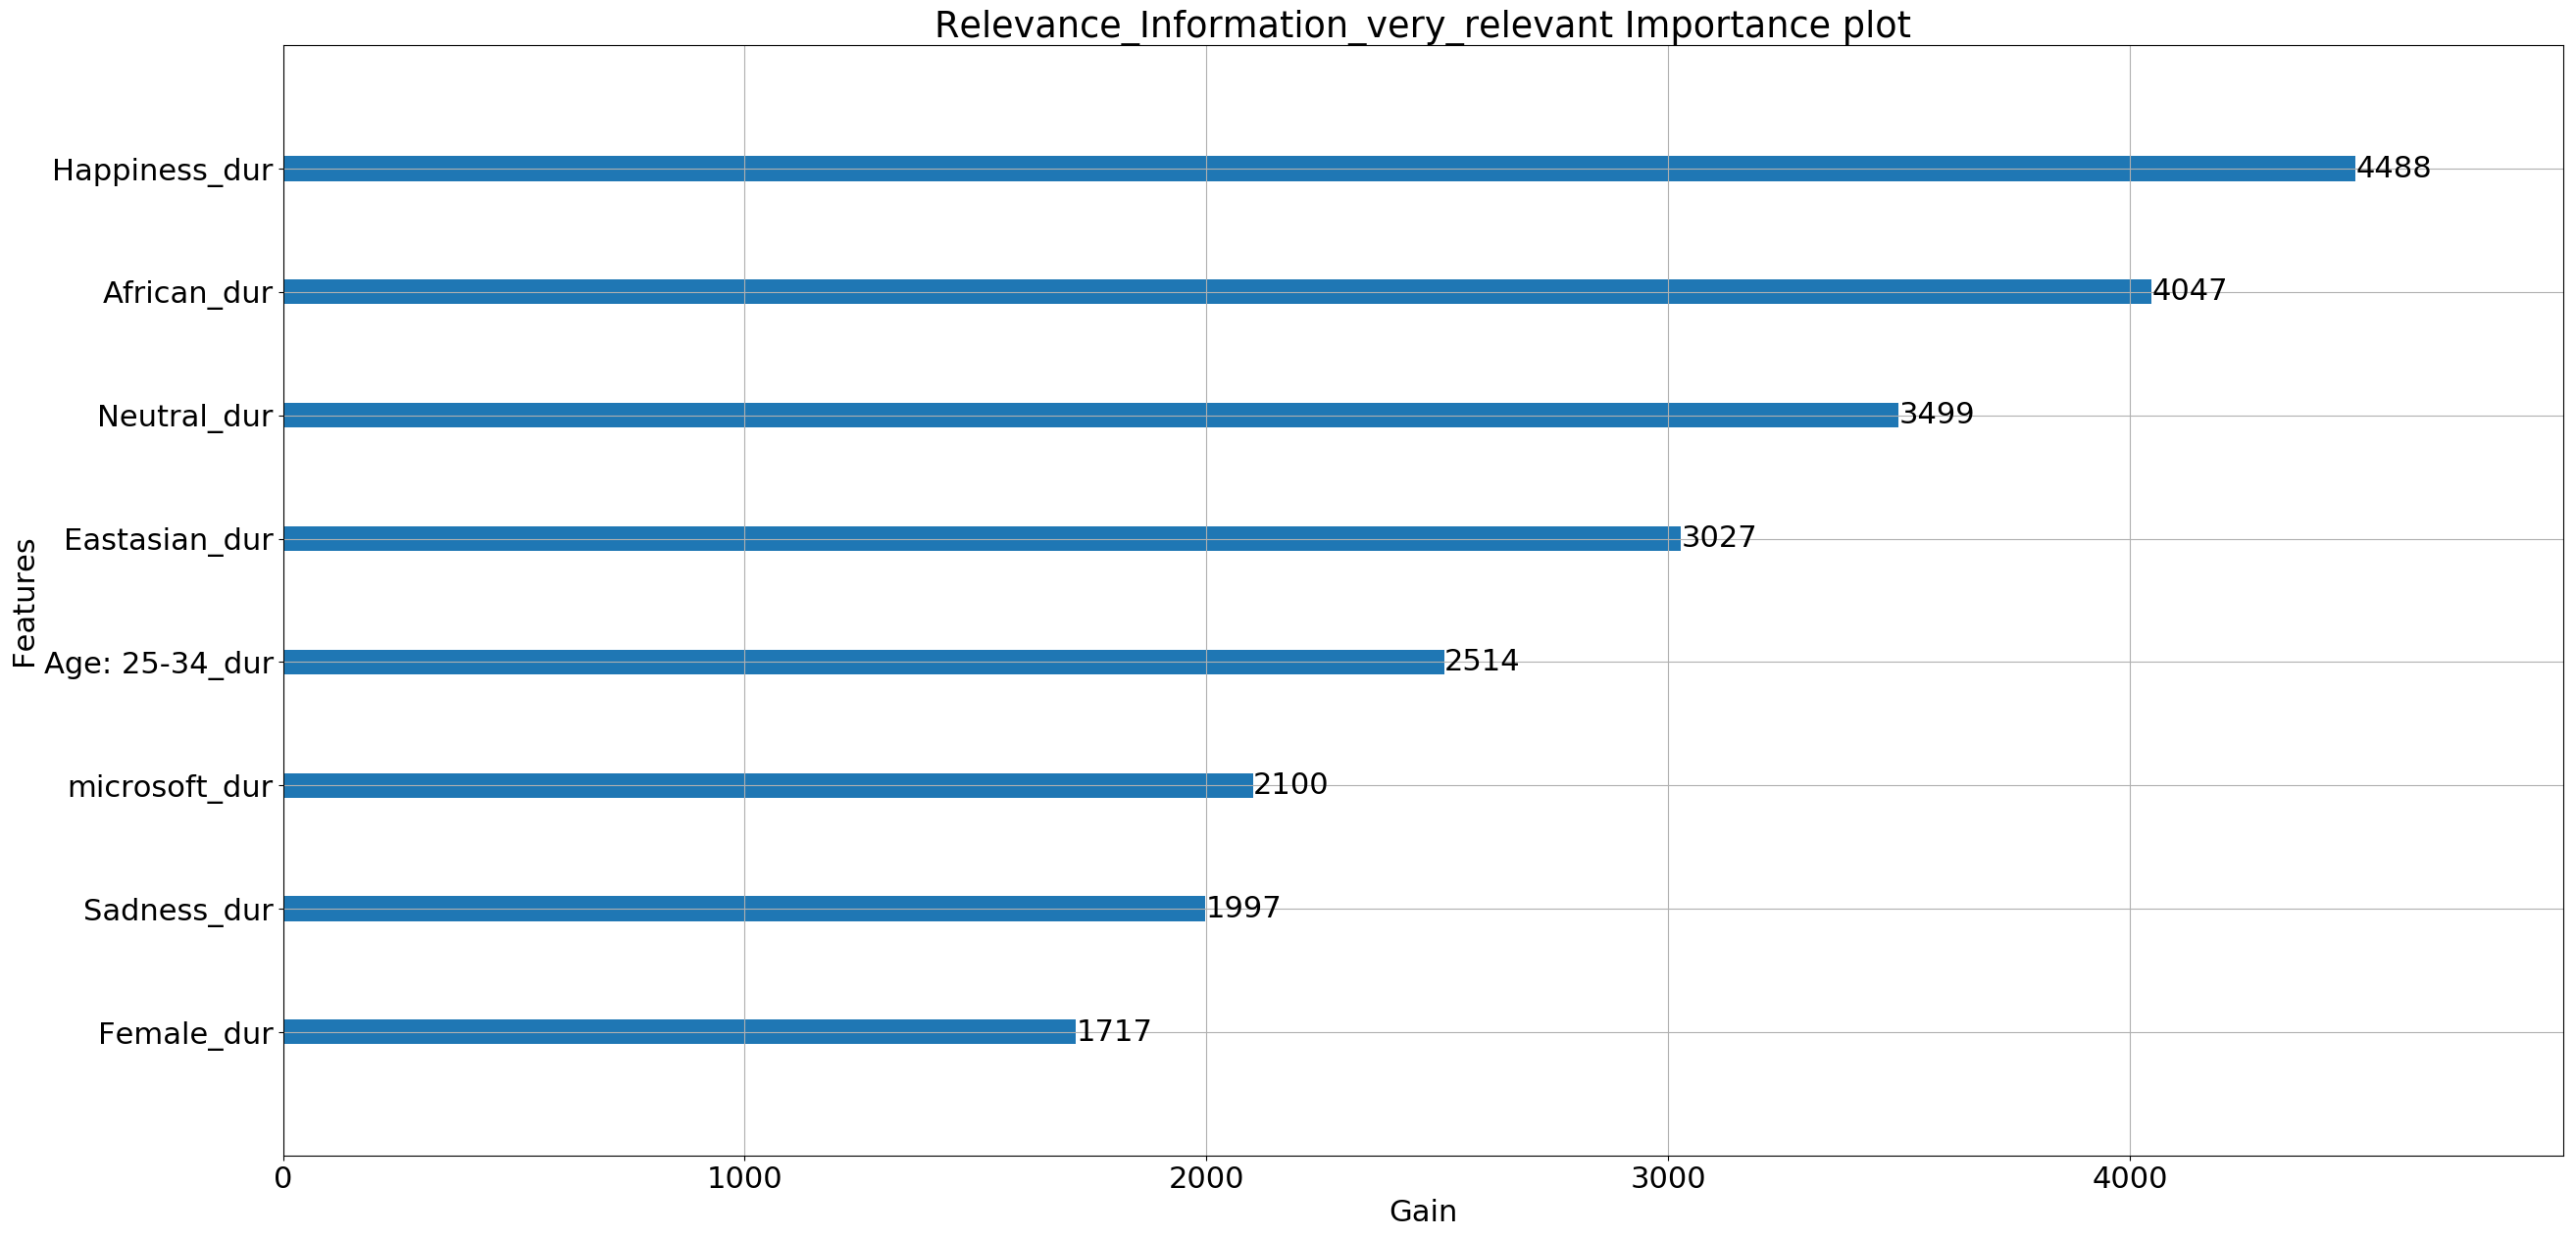

Credibility_Information_agree_strongly
waiting in line
trees
soothing
training
carpet
microsoft_last_ocr
vertical components
touring
sunny
Laptop_last_ocr
transporting
Tablet_total_ocr
rugged scene
Tablet_dur
microsoft_dur
foliage
clouds
reading
warm
Laptop_total_ocr
flowers
conducting business
Hp_text_dur
metal
vegetation
Tablet_last_ocr
socializing
Laptop_dur
Tablet_first_ocr
natural light
Lenovo_text_dur
microsoft_first_ocr
driving
still water
congregating
scary
plastic
Yoga_dur
diving
dry
Lenovo_group_dur
studying
Hp_total_ocr
Neutral_dur
sand
railing
ocean
horizontal components
Dell_dur
Age: 15-24_dur
Surface_group_dur
Hp_first_ocr
exercise
playing
Dell_sub_brand_group_dur
medical activity
sterile
brick
glass
boating
microsoft_total_ocr
eating
shopping
Age: 25-34_dur
Windows_dur
far-away horizon
cluttered space
using tools
asphalt
research
Hp_dur
Windows_total_ocr
Windows_first_ocr
Hp_last_ocr
stressful
length_of_ad_15
symmetrical
Laptop_first_ocr
ASUS T102_dur
Hp_text_first_ocr
g

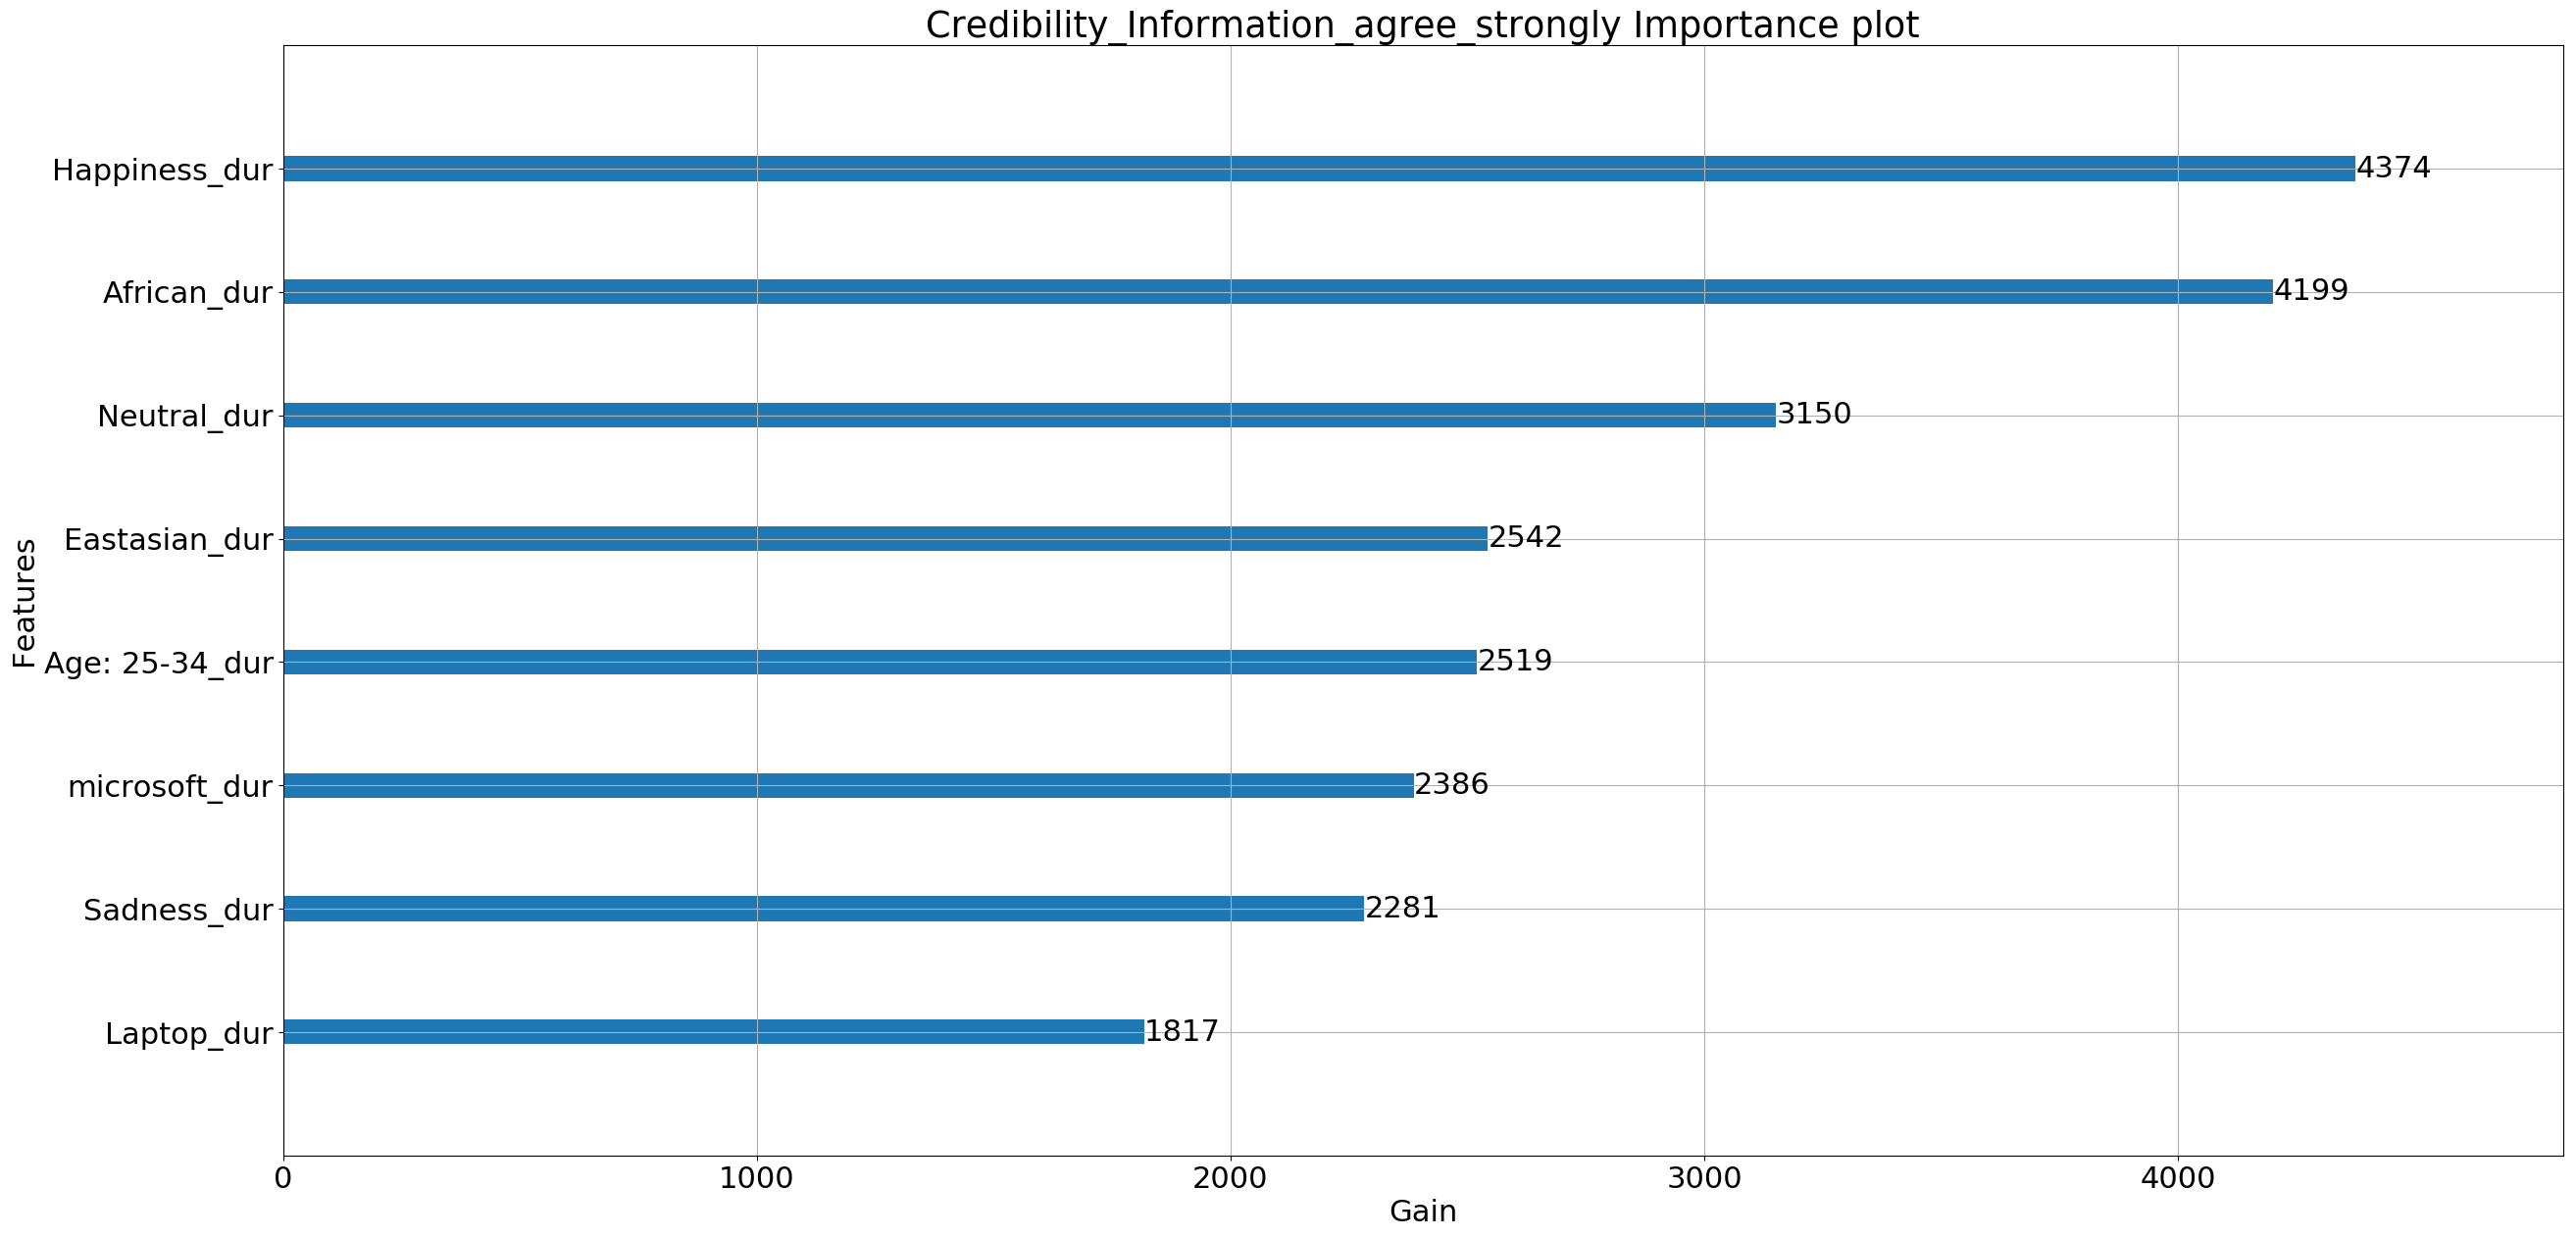

New_Information_alot
rugged scene
length_of_ad_15
soothing
Laptop_last_ocr
microsoft_last_ocr
Yoga_dur
Lenovo_text_dur
fire
Windows_last_ocr
clouds
training
biking
driving
sunny
reading
swimming
Tablet_total_ocr
sand
carpet
metal
asphalt
natural light
Laptop_total_ocr
waiting in line
Windows_first_ocr
pavement
using tools
exercise
sterile
medical activity
cold
glass
shopping
Dell_text_dur
Lenovo_group_dur
microsoft_first_ocr
dry
Laptop_dur
aged
studying
Tablet_dur
Age: 25-34_dur
matte
Happiness_dur
Hp_text_dur
vegetation
flowers
Age: 35-44_dur
microsoft_total_ocr
tiles
touring
Hp_text_total_ocr
brick
moist
Age: 15-24_dur
Hp_total_ocr
Hp_dur
Laptop_first_ocr
socializing
stressful
Asus_dur
spectating
boating
wood
snow
Windows_total_ocr
Tablet_last_ocr
Windows_dur
grass
Hp_last_ocr
foliage
horizontal components
diving
sports
Dell_dur
congregating
still water
railing
ocean
climbing
research
Sadness_dur
vertical components
conducting business
warm
African_dur
Tablet_first_ocr
gaming
paper
H

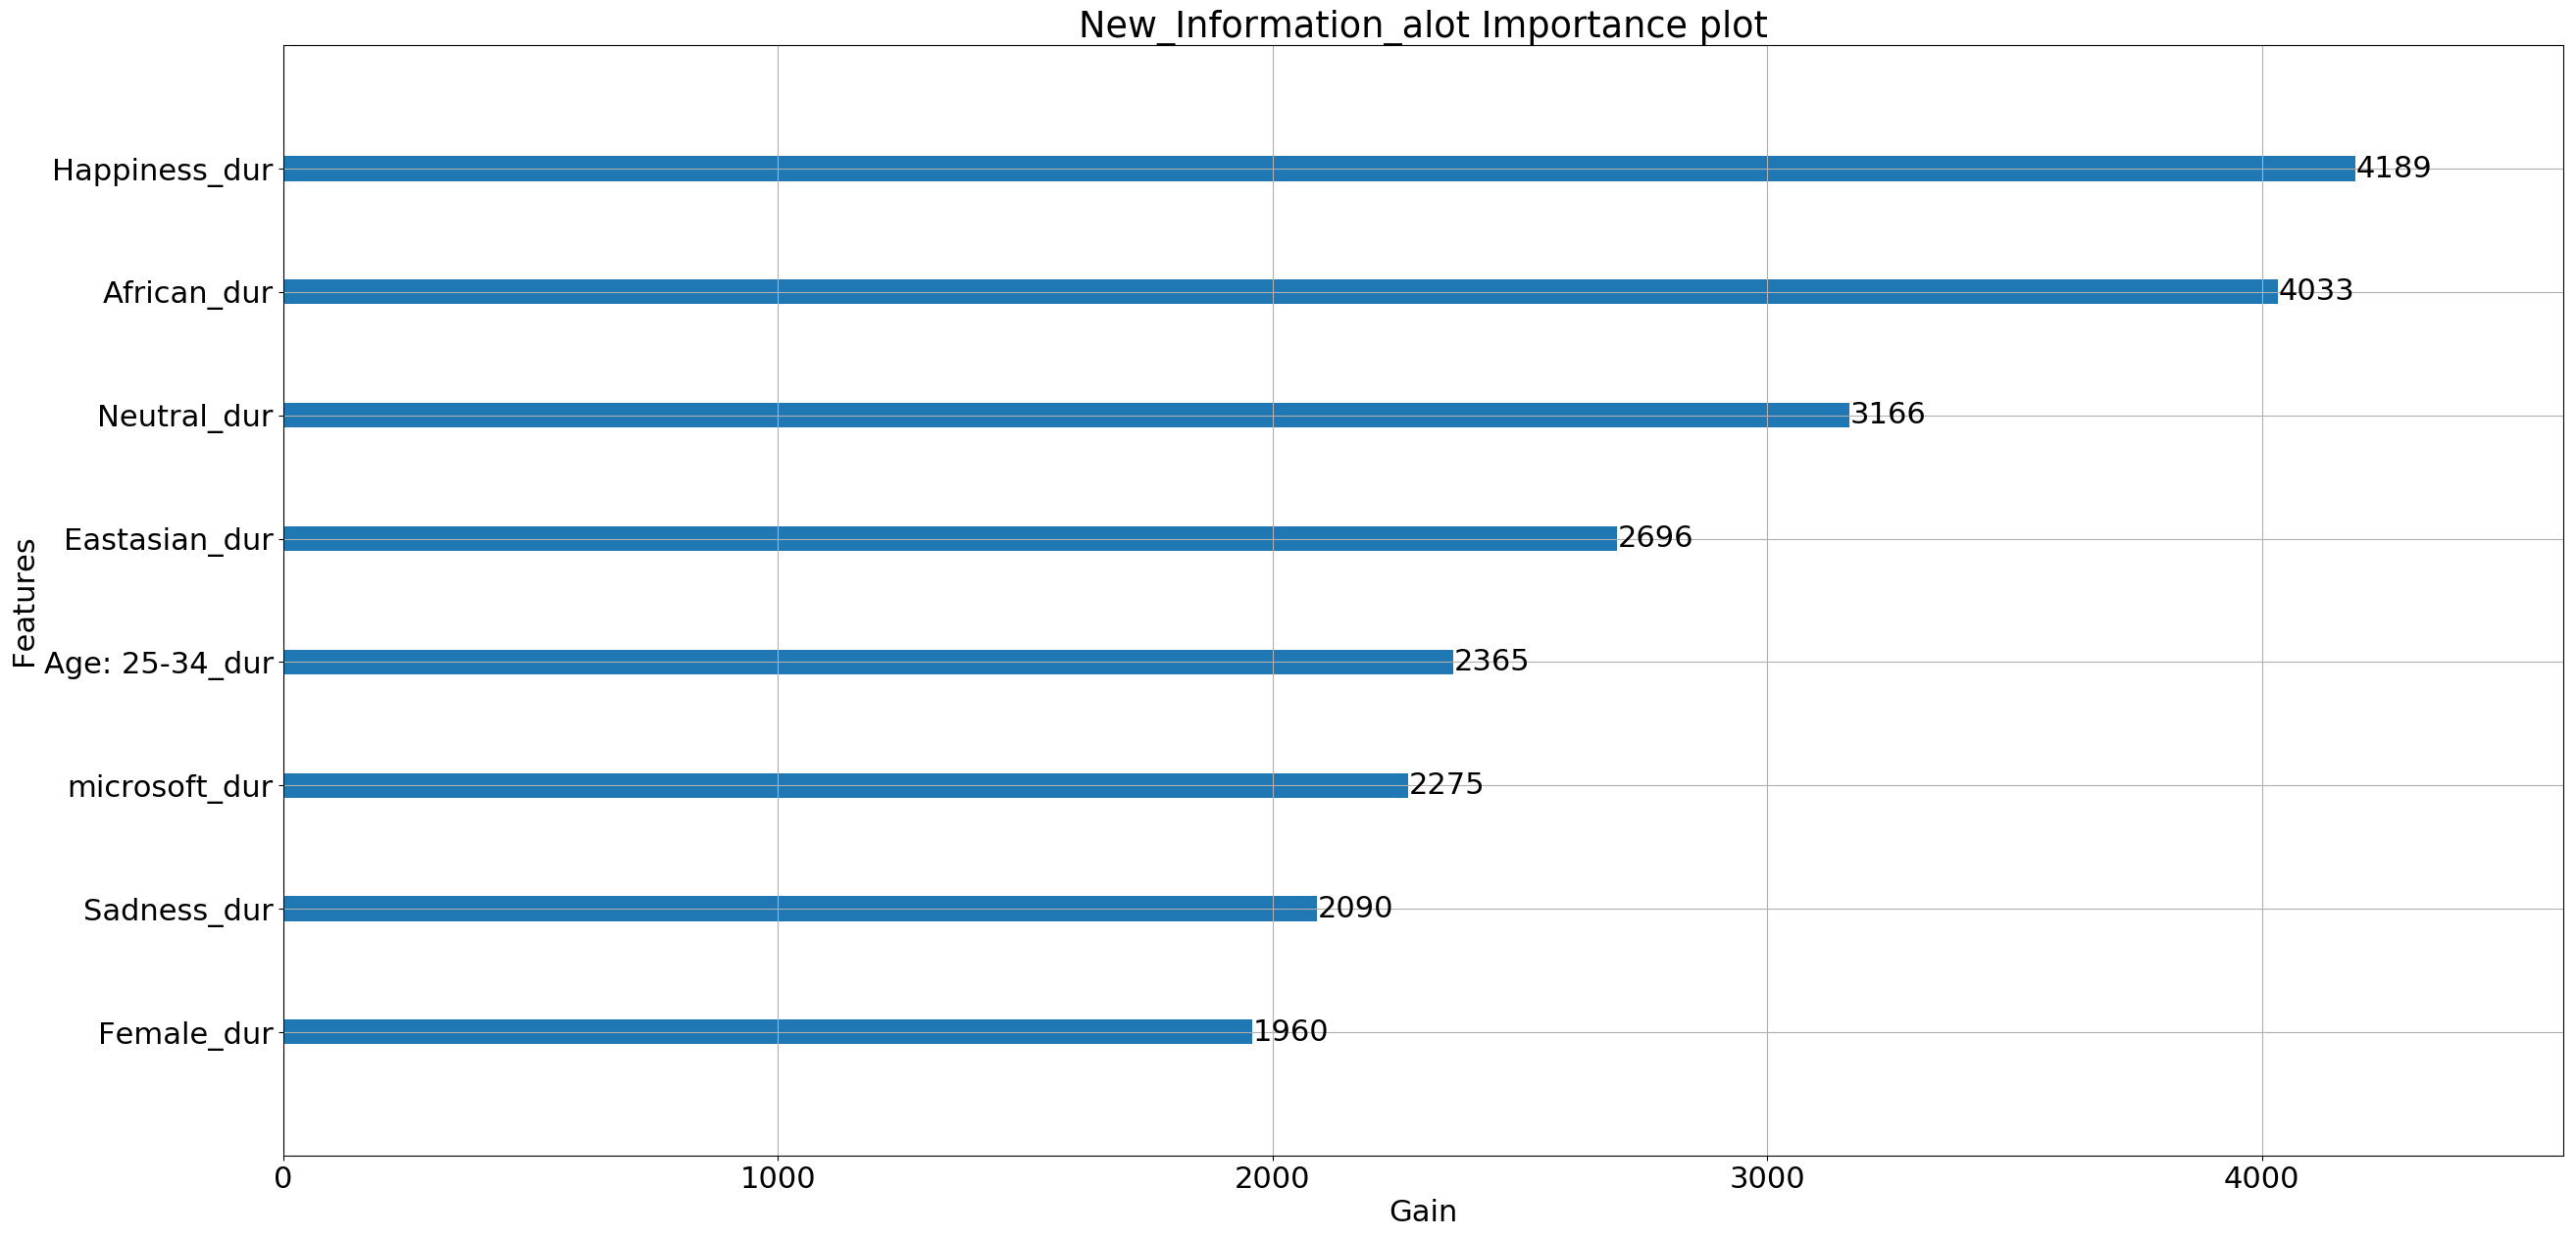

Brand_Difference_strongly
running water
rugged scene
touring
Laptop_last_ocr
waiting in line
microsoft_last_ocr
glossy
training
metal
dirty
cold
length_of_ad_15
Dell_text_dur
Windows_last_ocr
dirt
carpet
asphalt
shopping
soothing
Lenovo_text_dur
microsoft_first_ocr
Age: 25-34_dur
natural light
cluttered space
driving
Hp_text_dur
boating
reading
vegetation
sunny
biking
using tools
Dell_dur
clouds
Yoga_dur
vertical components
Laptop_total_ocr
sports
Laptop_dur
Windows_first_ocr
Age: 15-24_dur
congregating
exercise
Tablet_last_ocr
Lenovo_group_dur
dry
hiking
diving
Tablet_first_ocr
conducting business
paper
semi-enclosed area
Dell_sub_brand_group_dur
flowers
fire
aged
ASUS T102_dur
glass
shrubbery
moist
Windows_total_ocr
spectating
playing
Hp_text_total_ocr
Neutral_dur
African_dur
climbing
HP_group_dur
socializing
Sadness_dur
Surface_group_dur
stressful
microsoft_total_ocr
research
Laptop_first_ocr
Tablet_total_ocr
natural
horizontal components
sterile
Hp_total_ocr
railing
Hp_last_ocr
Tab

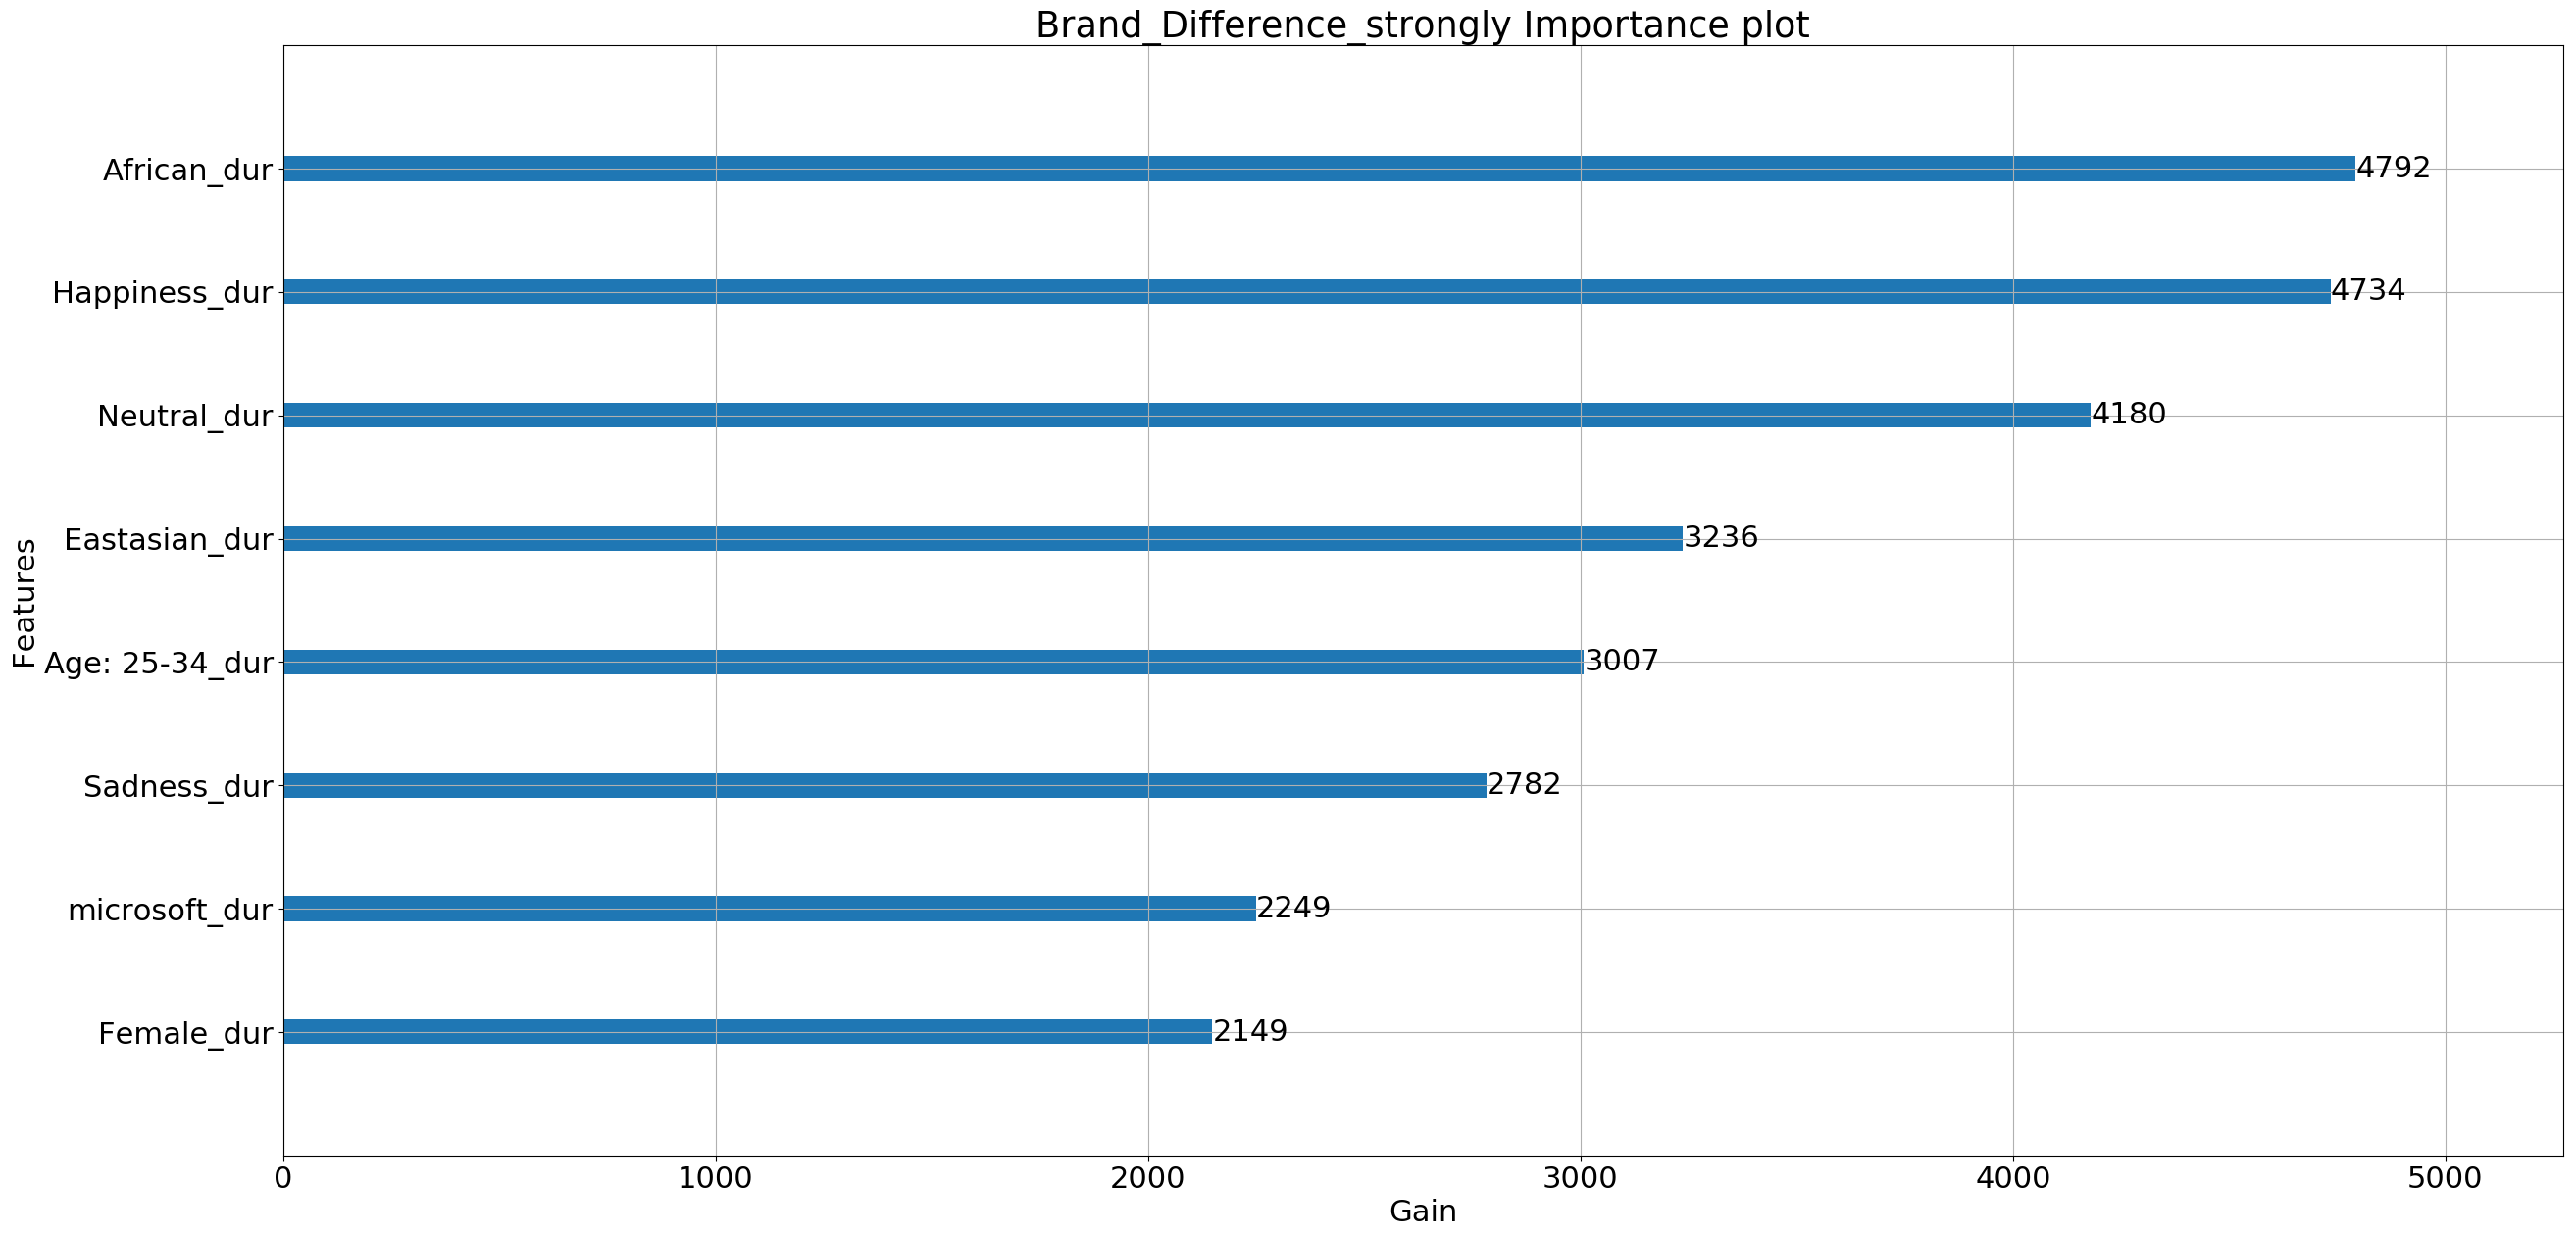

In [34]:
imp_features_xgb = model_xgb.plot_feature_importance(models_xgb_27,10,y_train_27.columns,X_train_27.columns,savefig=False)

In [35]:
for i in range(len(y_test_27.columns)):
    acc_df_xgb.iloc[2:,i]= imp_features_xgb[i,:10]

In [36]:
acc_df_xgb.to_excel('acc_df_xgb_software.xlsx')

In [37]:
explainer_xgb=[]
shap_values_xgb=[]
for i in tqdm(range(26)):
    explainer_xgb.append(shap.TreeExplainer(models_xgb_27[i]))
    shap_values_xgb.append(explainer_xgb[-1].shap_values(X_train_27))
    print(i)

  4%|▍         | 1/26 [00:28<11:55, 28.61s/it]

0


  8%|▊         | 2/26 [00:38<09:14, 23.10s/it]

1


 12%|█▏        | 3/26 [00:53<07:53, 20.57s/it]

2


 15%|█▌        | 4/26 [01:06<06:43, 18.36s/it]

3


 19%|█▉        | 5/26 [01:17<05:35, 15.98s/it]

4


 23%|██▎       | 6/26 [01:25<04:34, 13.73s/it]

5


 27%|██▋       | 7/26 [01:34<03:55, 12.37s/it]

6


 31%|███       | 8/26 [01:43<03:24, 11.37s/it]

7


 35%|███▍      | 9/26 [01:53<03:04, 10.85s/it]

8


 38%|███▊      | 10/26 [02:03<02:48, 10.56s/it]

9


 42%|████▏     | 11/26 [02:10<02:21,  9.44s/it]

10


 46%|████▌     | 12/26 [02:30<02:57, 12.65s/it]

11


 50%|█████     | 13/26 [02:44<02:51, 13.22s/it]

12


 54%|█████▍    | 14/26 [03:01<02:52, 14.38s/it]

13


 58%|█████▊    | 15/26 [03:13<02:27, 13.44s/it]

14


 62%|██████▏   | 16/26 [03:29<02:21, 14.19s/it]

15


 65%|██████▌   | 17/26 [03:48<02:21, 15.69s/it]

16


 69%|██████▉   | 18/26 [04:03<02:03, 15.50s/it]

17


 73%|███████▎  | 19/26 [04:21<01:54, 16.42s/it]

18


 77%|███████▋  | 20/26 [04:37<01:36, 16.12s/it]

19


 81%|████████  | 21/26 [04:51<01:18, 15.63s/it]

20


 85%|████████▍ | 22/26 [05:07<01:02, 15.51s/it]

21


 88%|████████▊ | 23/26 [05:22<00:46, 15.51s/it]

22


 92%|█████████▏| 24/26 [05:38<00:30, 15.48s/it]

23


 96%|█████████▌| 25/26 [05:52<00:15, 15.16s/it]

24


100%|██████████| 26/26 [06:09<00:00, 15.60s/it]

25


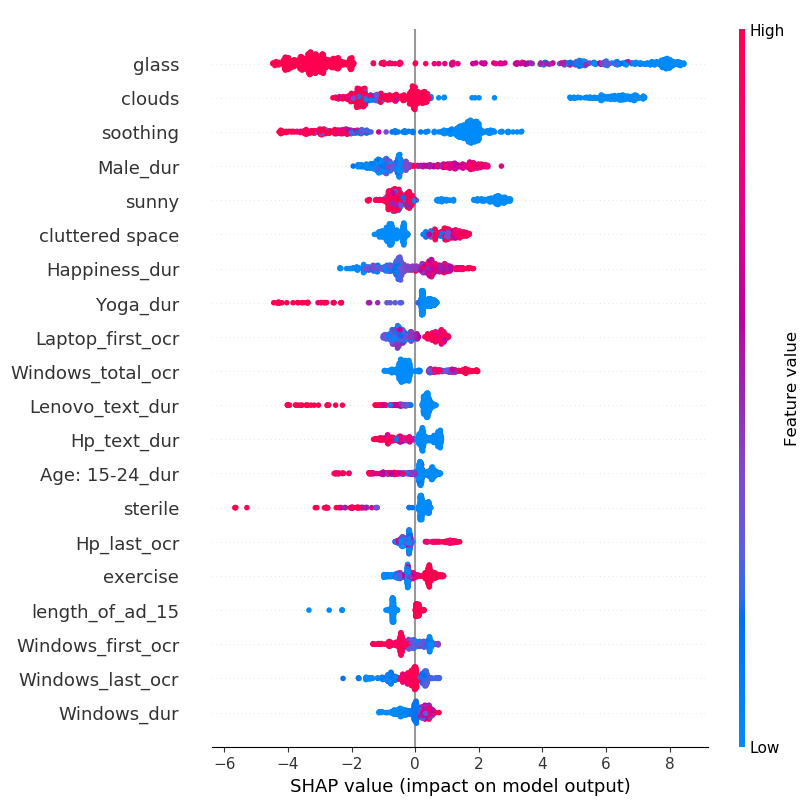

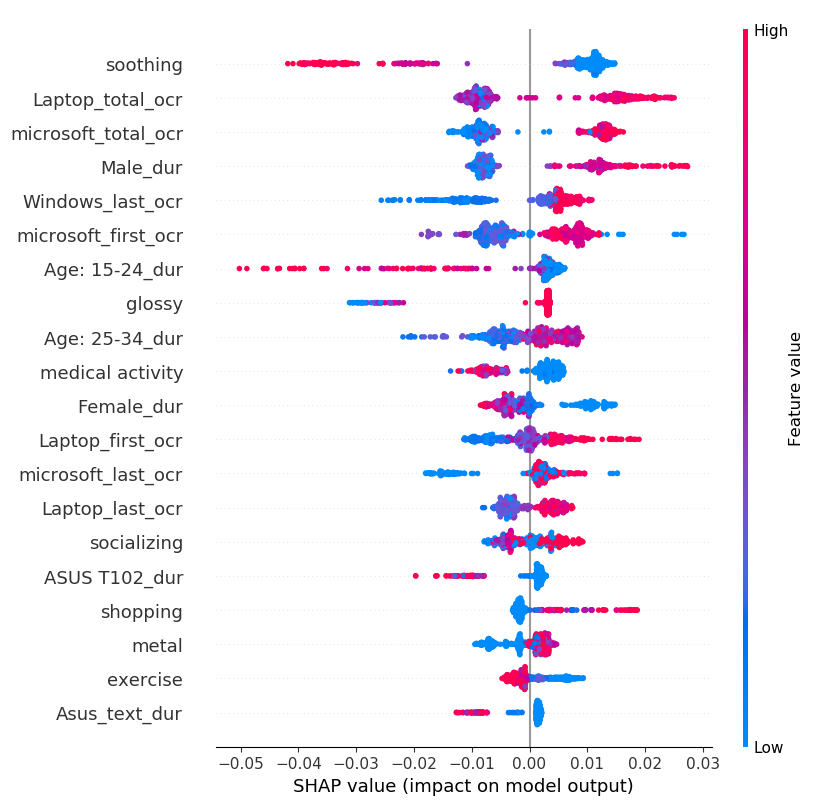

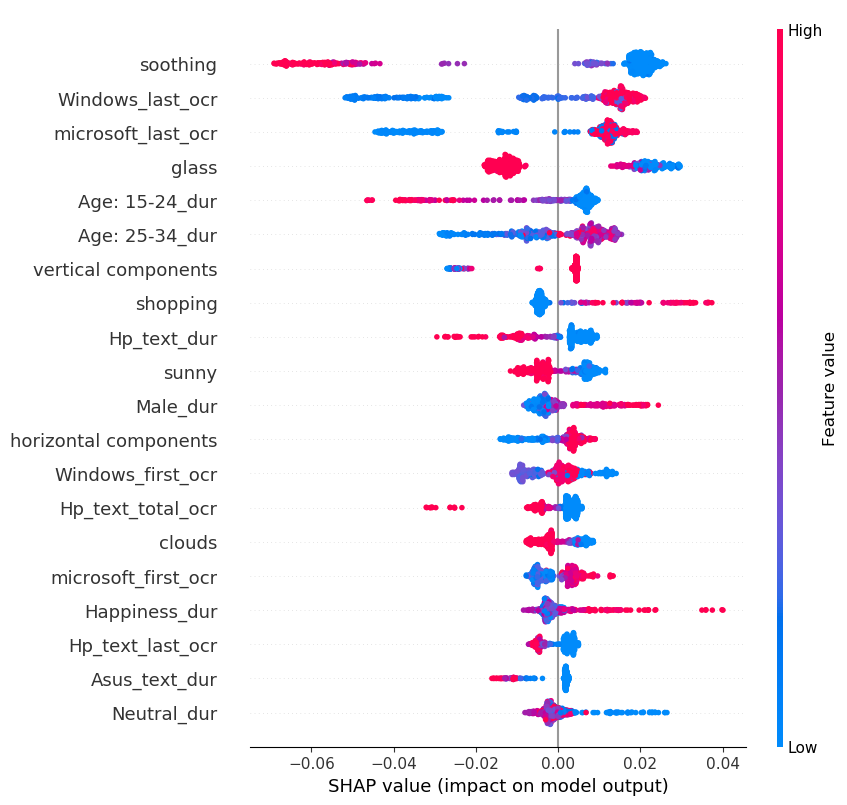

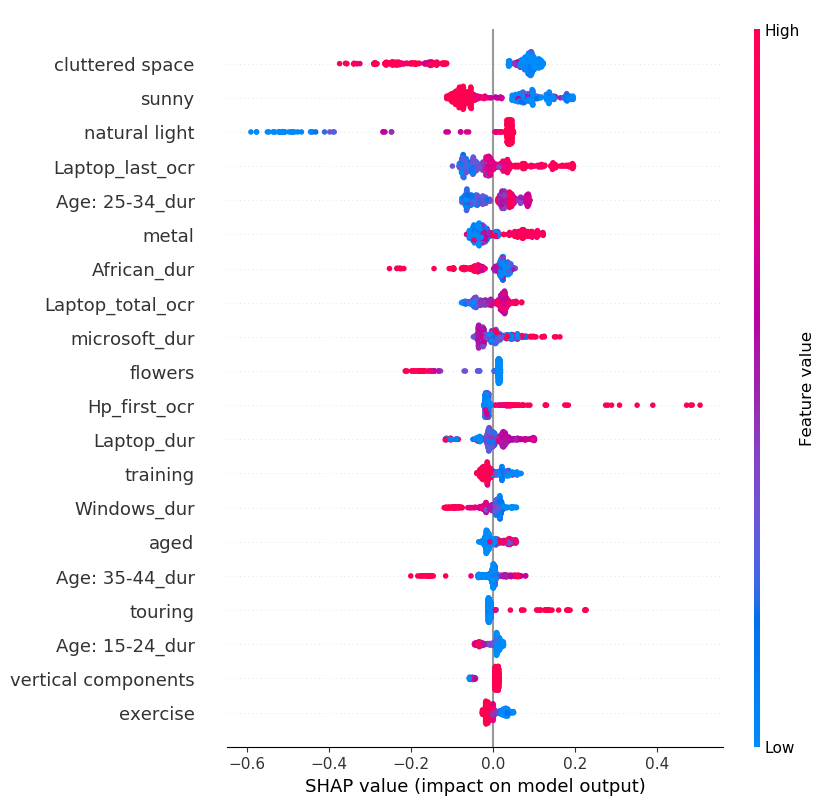

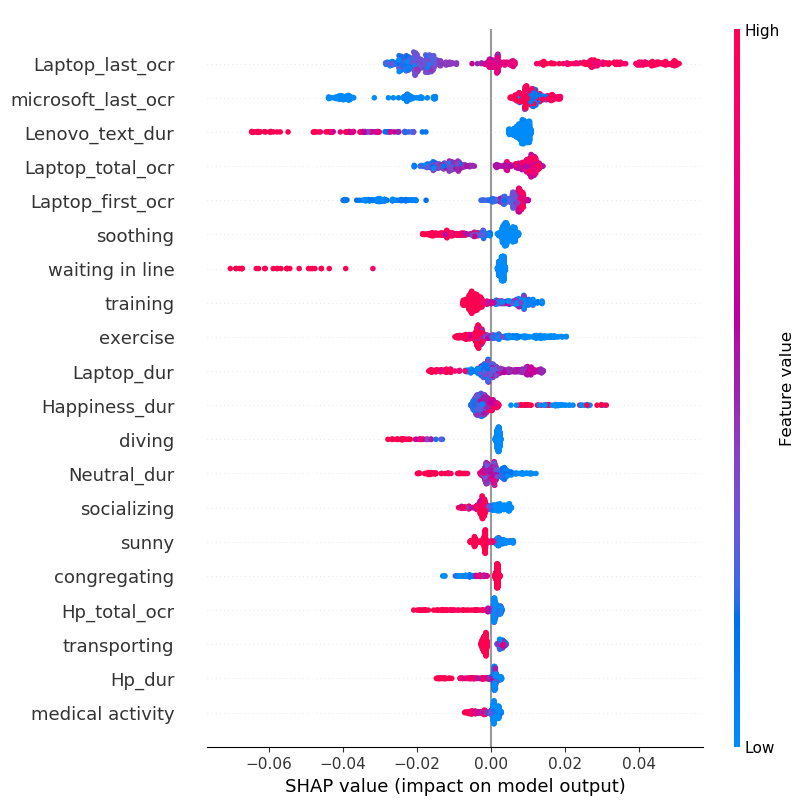

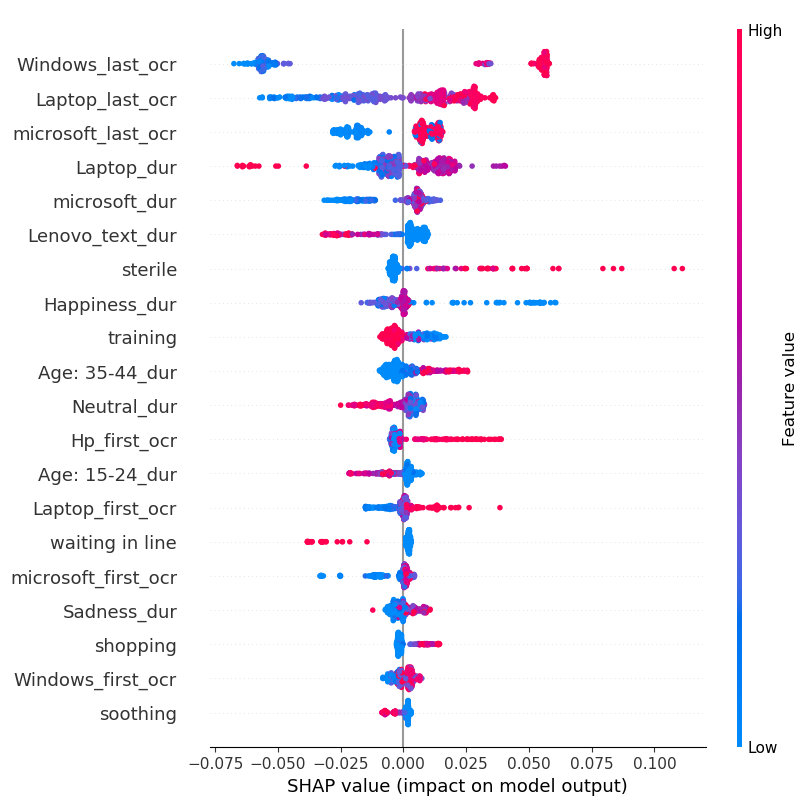

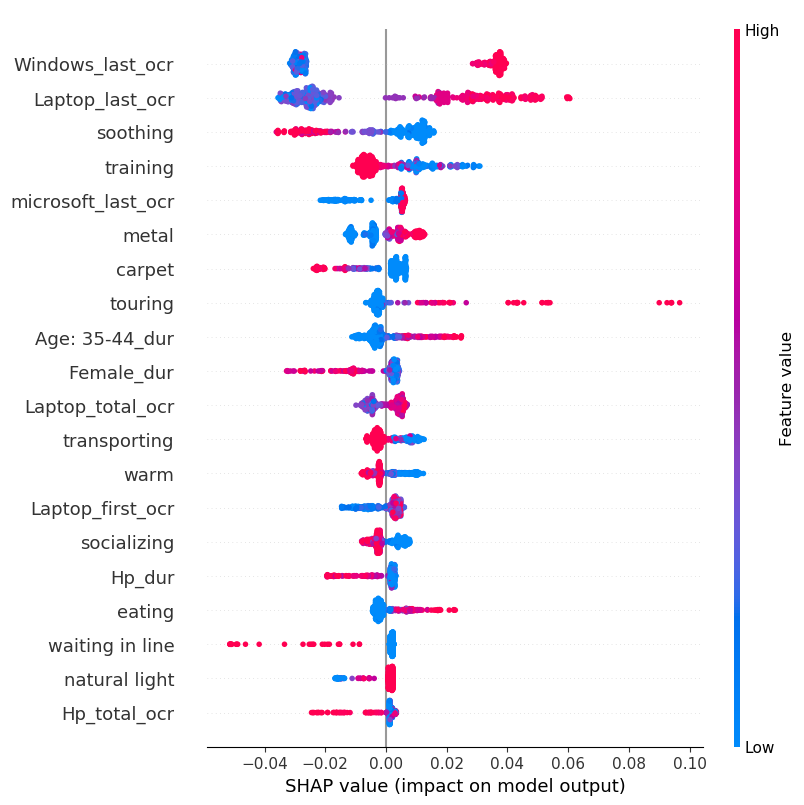

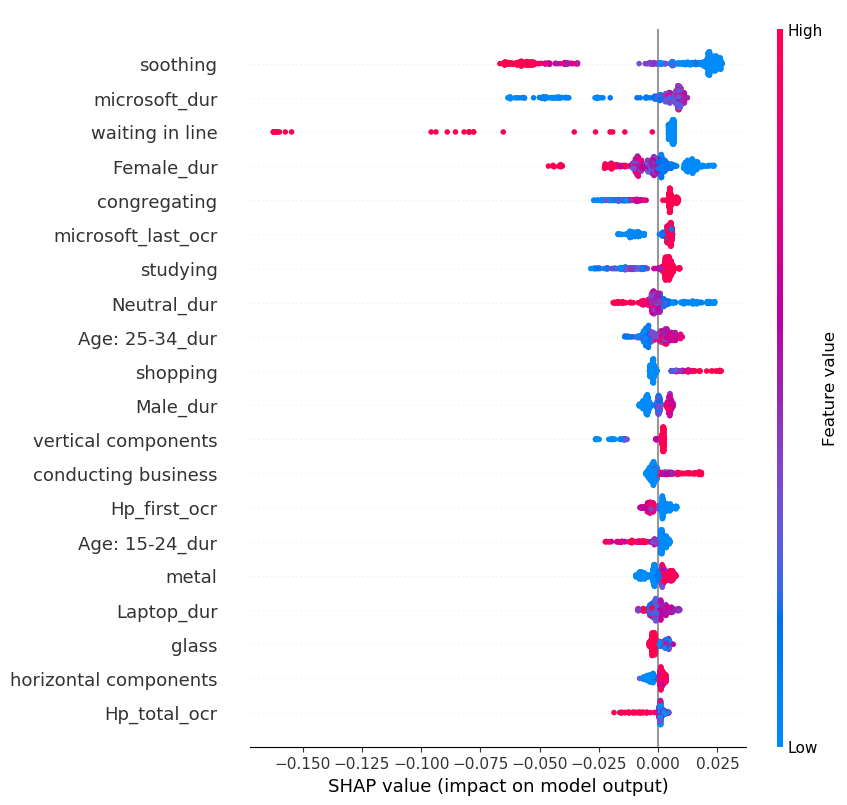

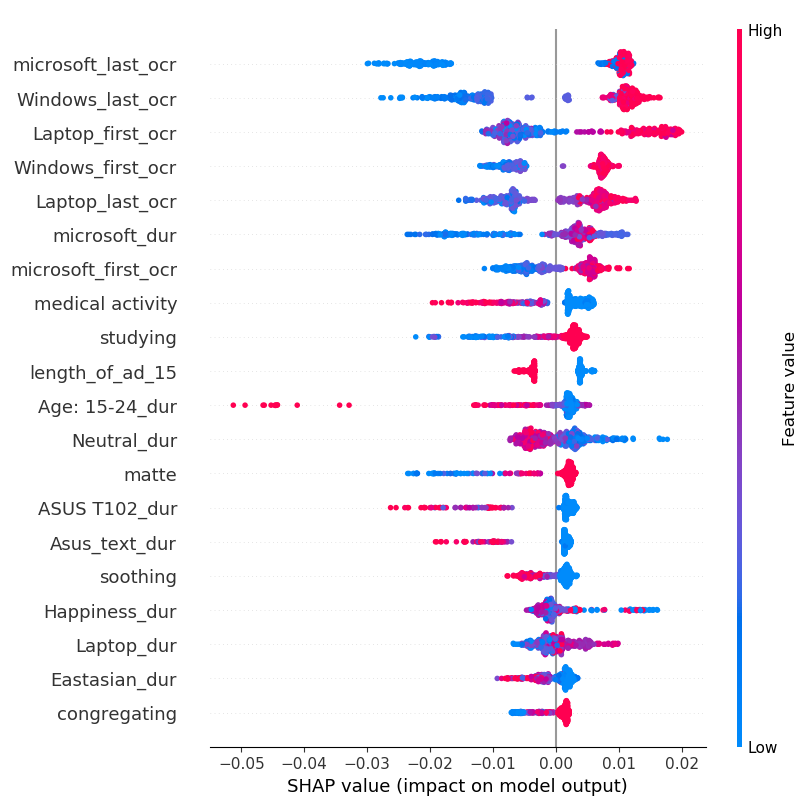

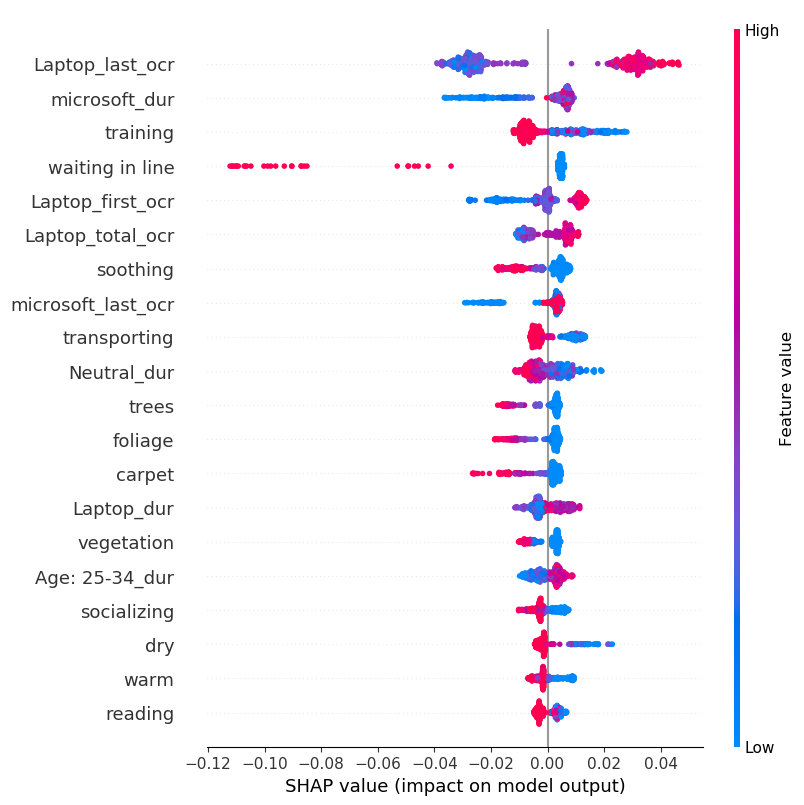

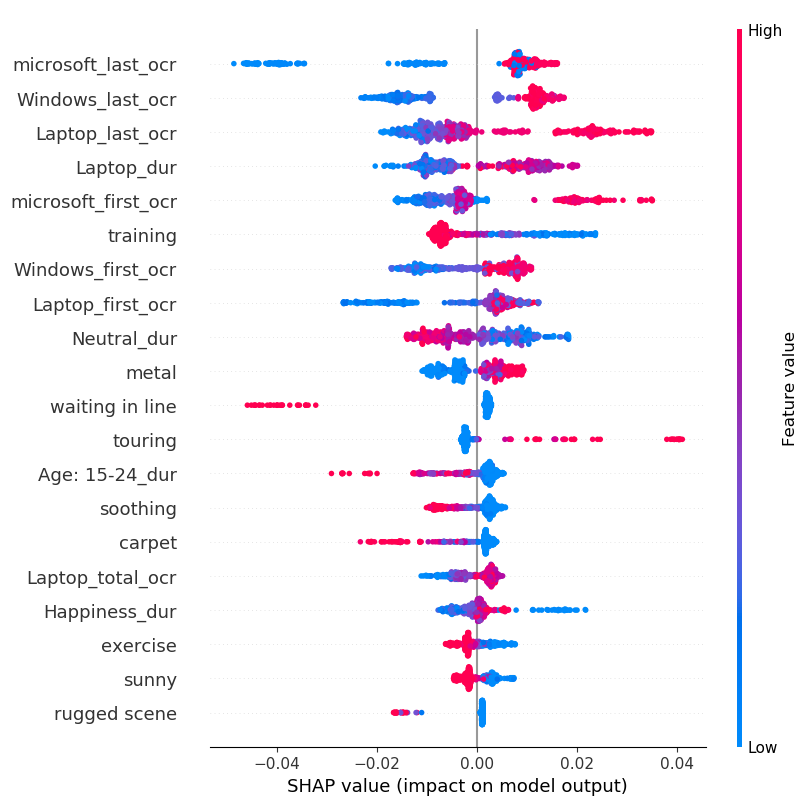

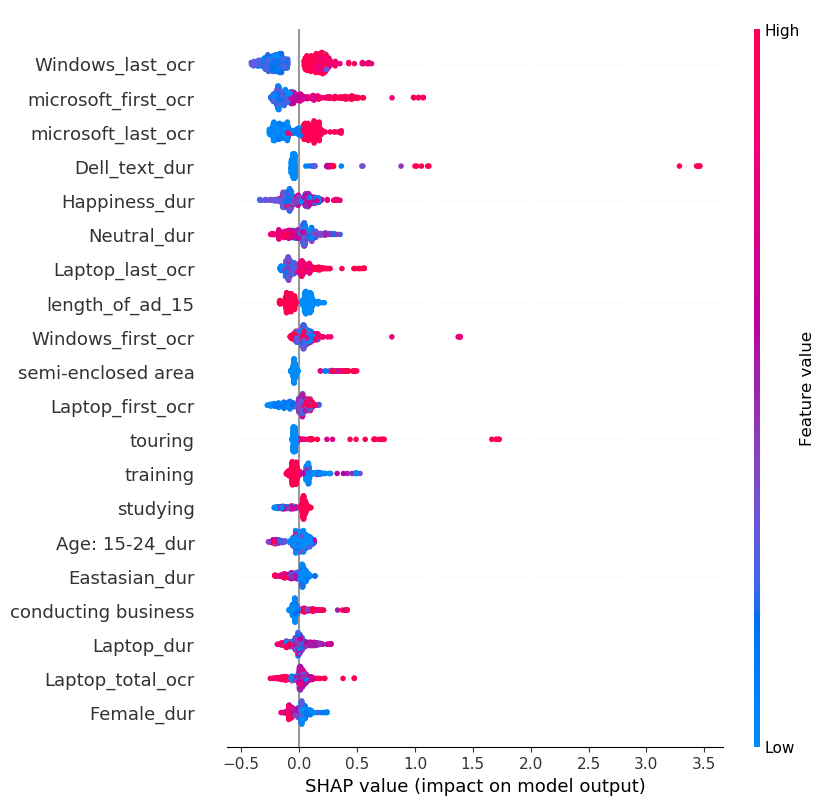

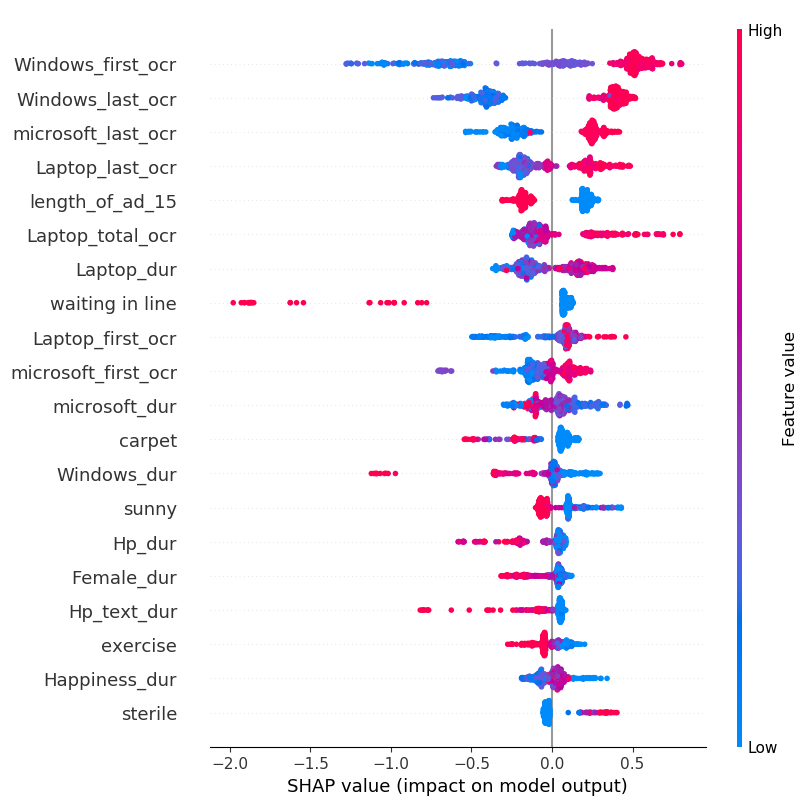

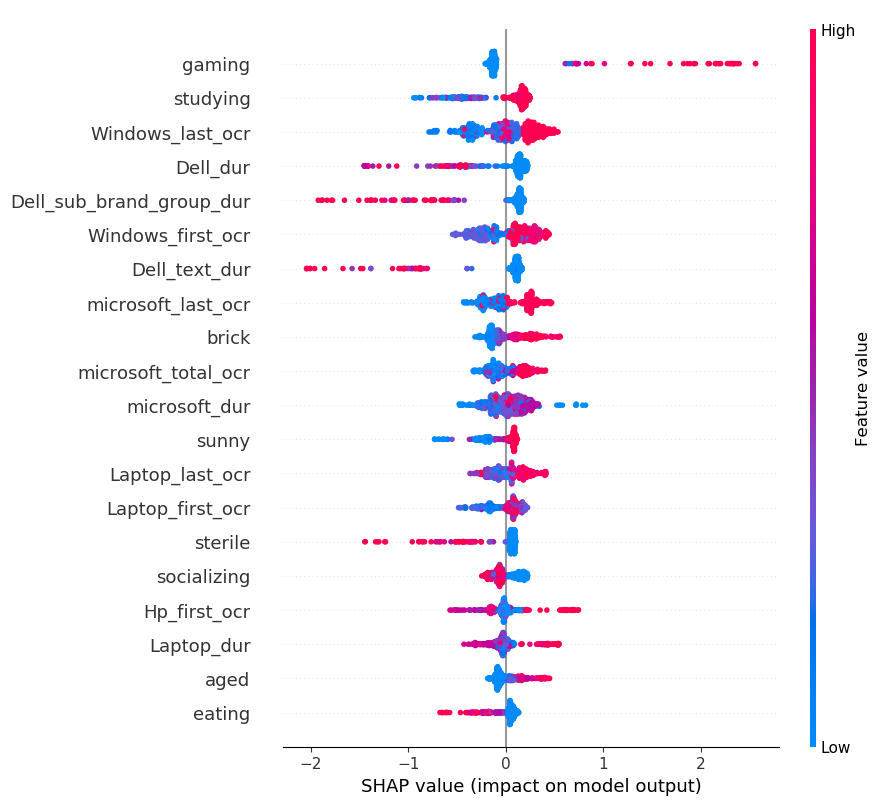

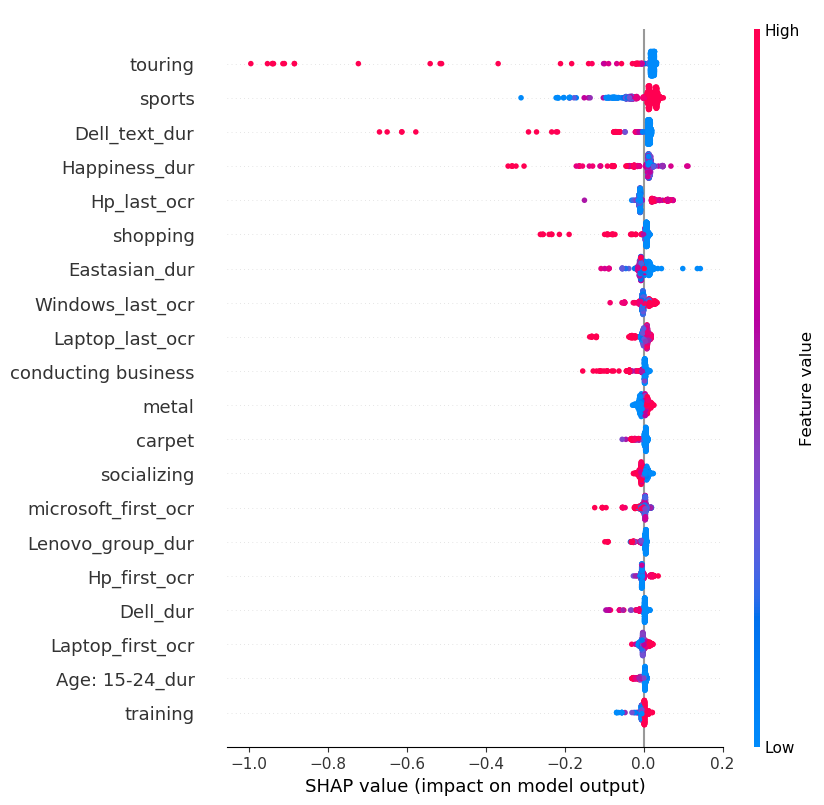

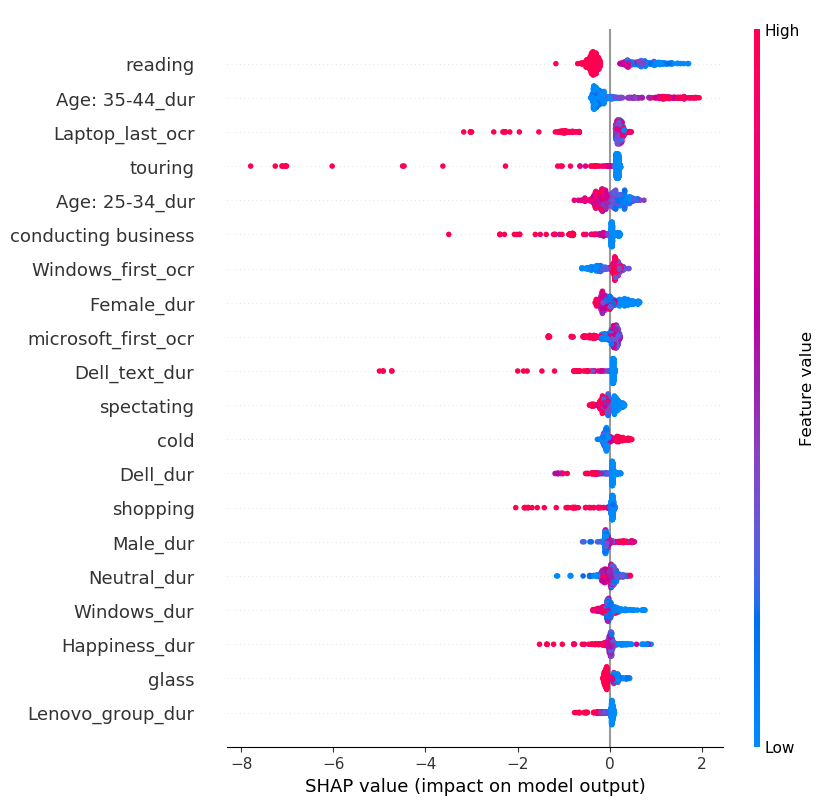

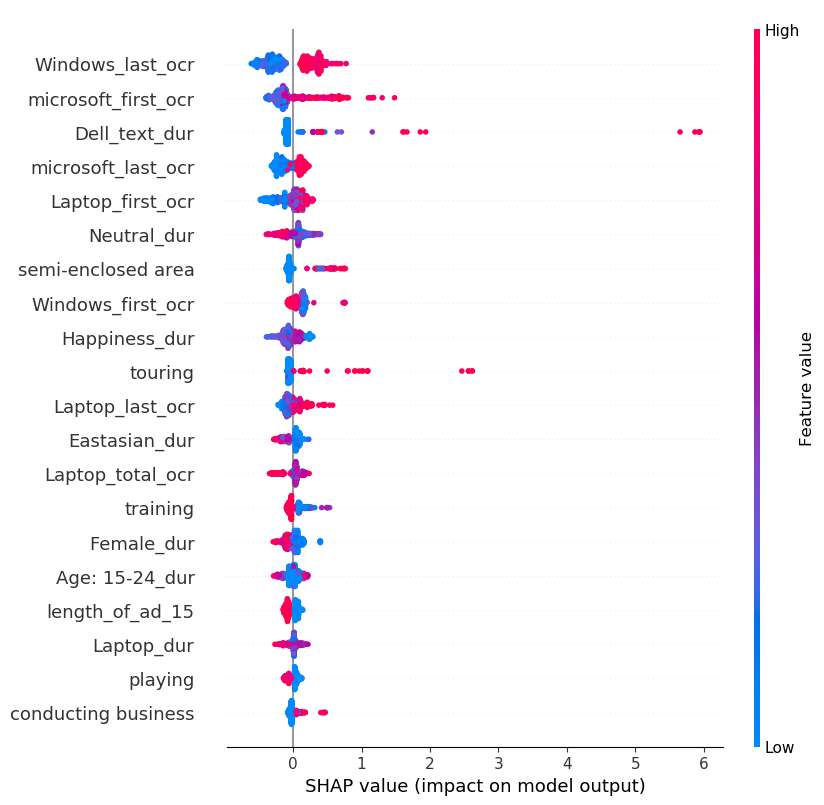

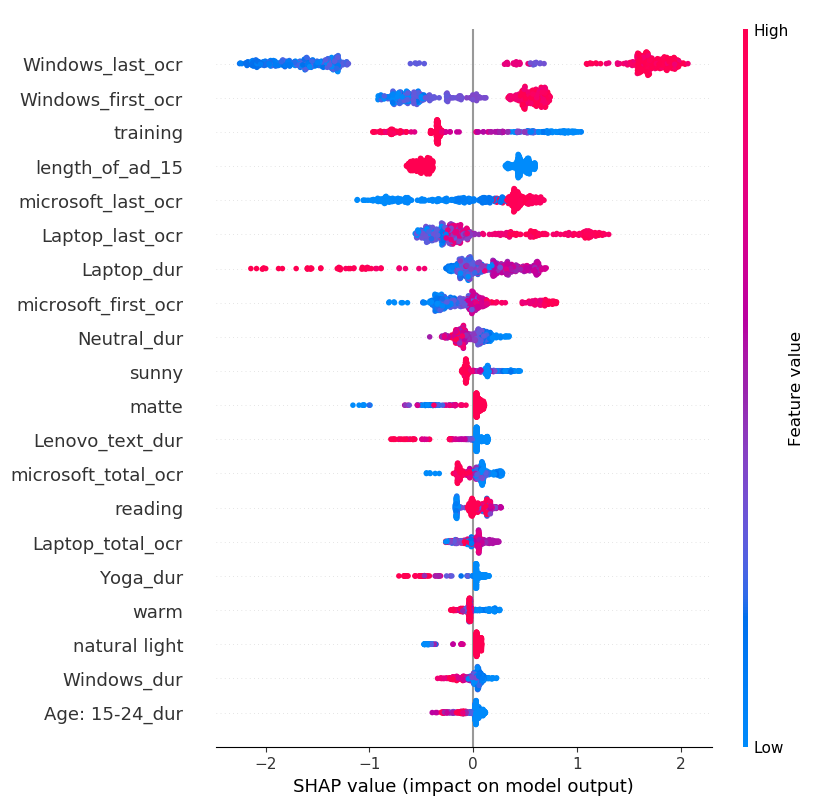

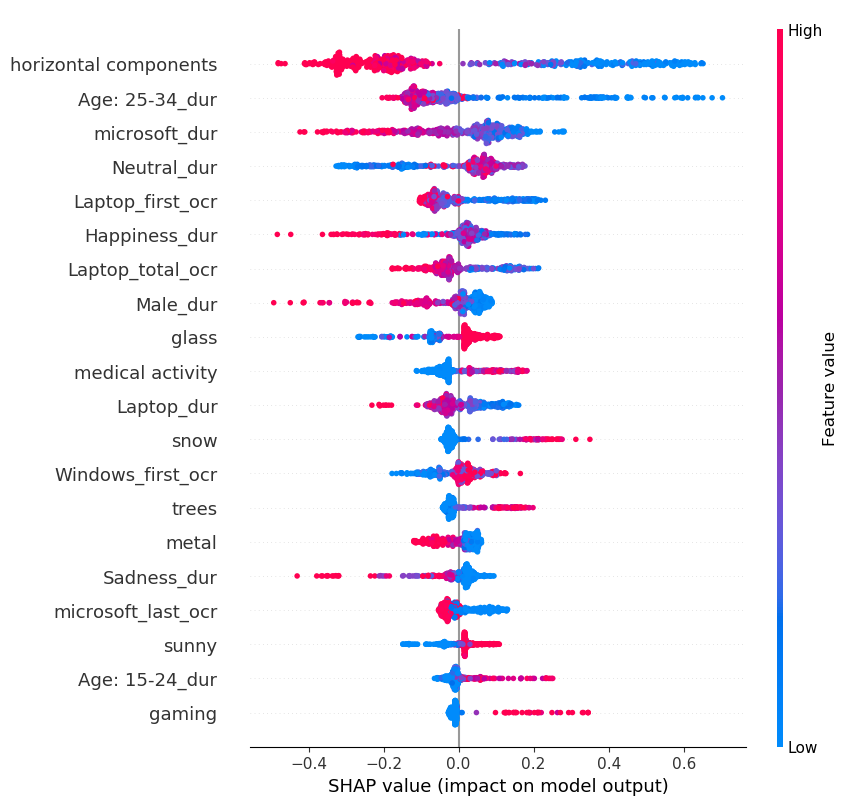

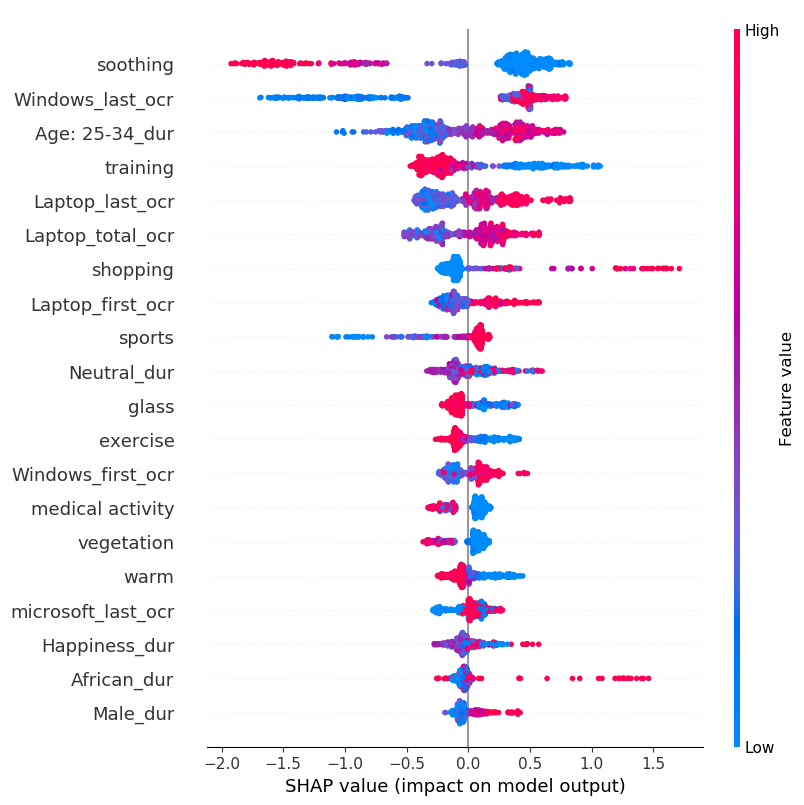

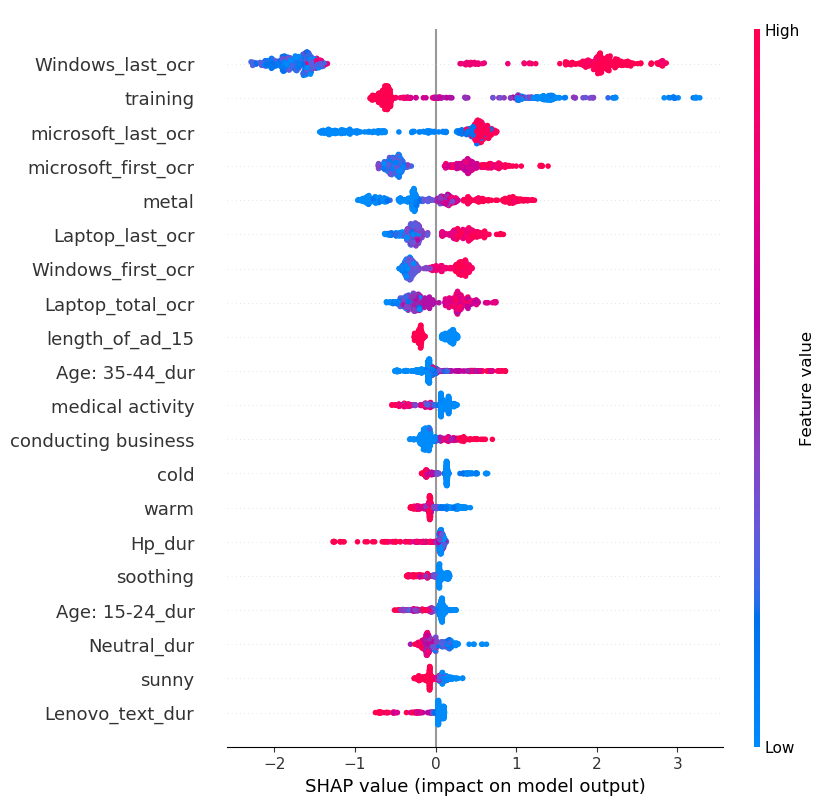

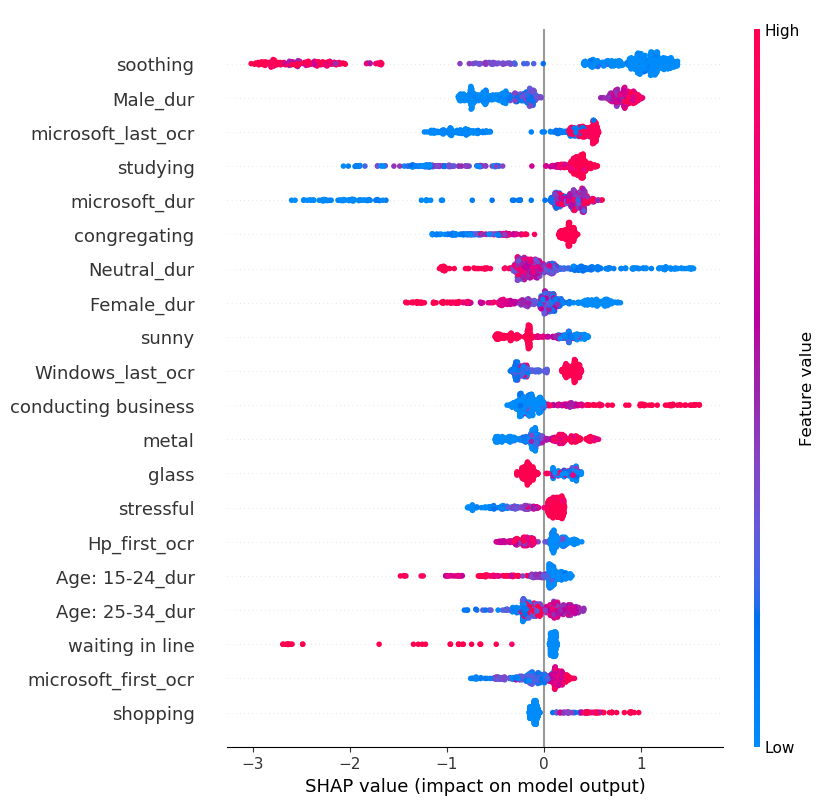

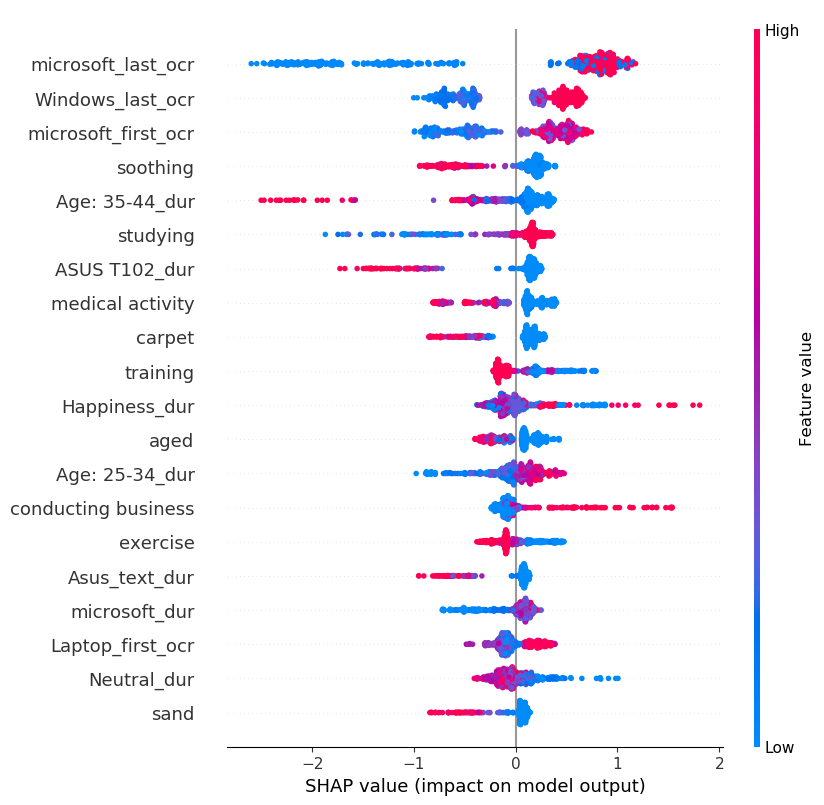

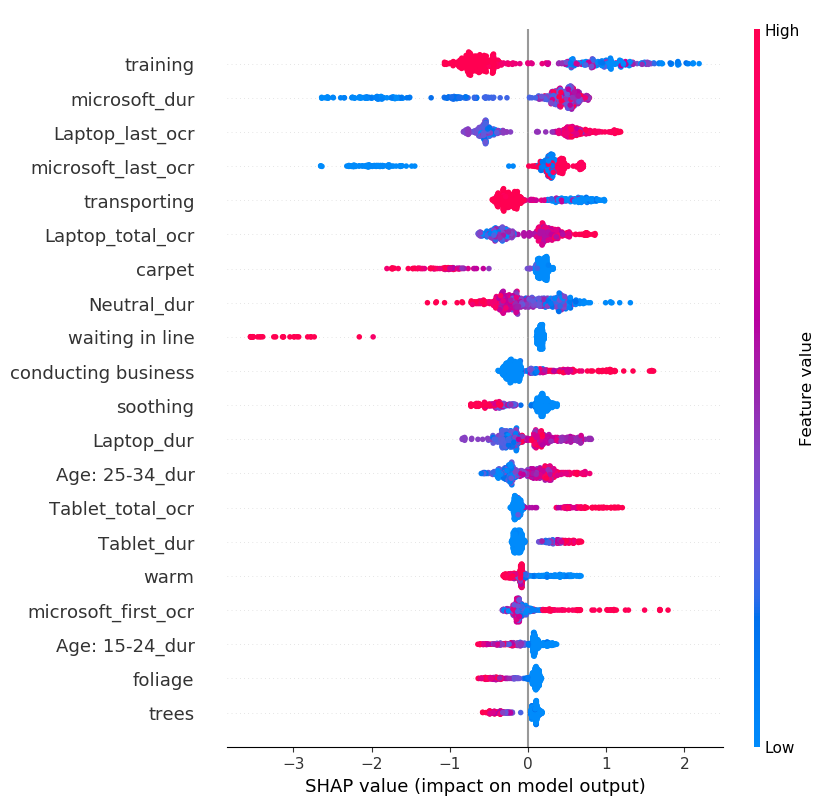

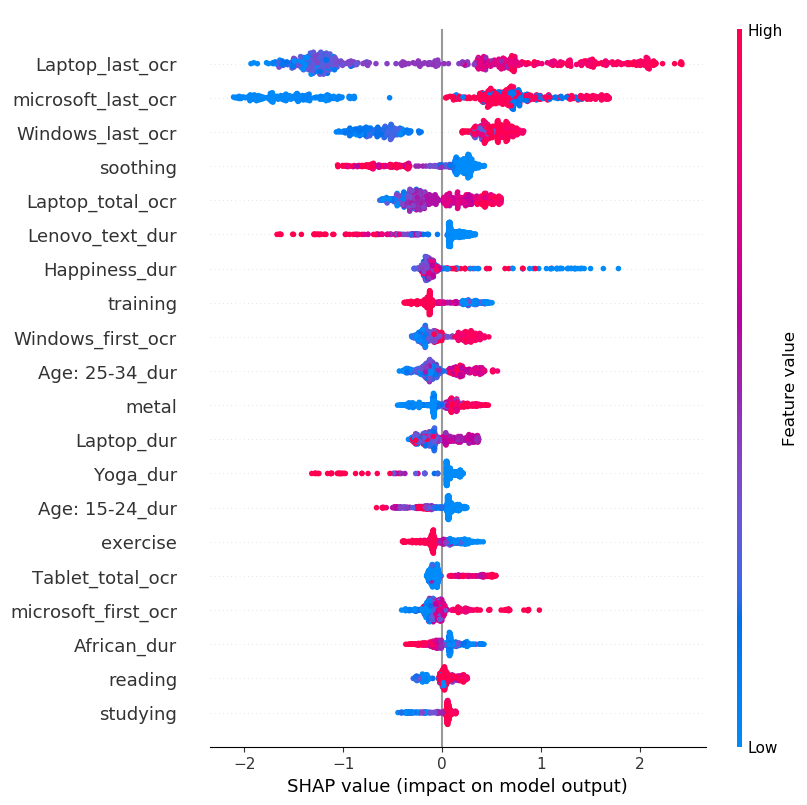

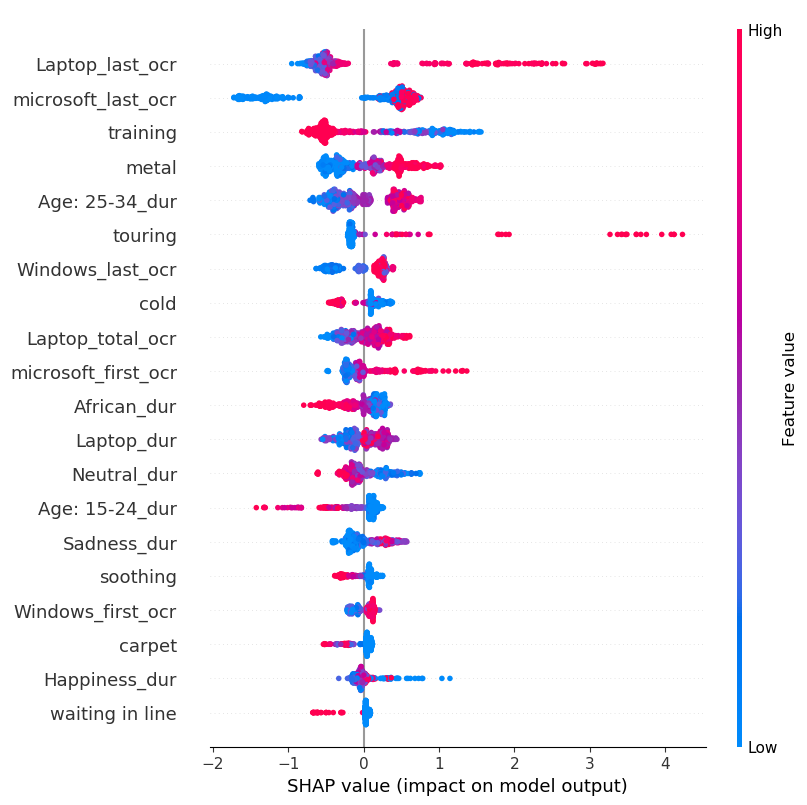

In [38]:
for i in range(26):
    plt.figure()
    shap.summary_plot(shap_values_xgb[i],X_train_27,show=False)
    plt.savefig('./Version_6/Software/shap_xgb/'+y_train_27.columns[i]+'.png',bbox_inches='tight')

## Shap Analysis

In [39]:
n_features=10

In [40]:
def shap_analysis(shap_values,imp_features):
    shap_analysis_pd = pd.DataFrame(index=[i for i in range(n_features)])
    for k,target in enumerate(y_test_27.columns):
        temp_dict = {}
        feature_impact=pd.DataFrame(columns=[target,target+'_val'],index=[i for i in range(n_features)])
        for i,col in enumerate(imp_features[k,:10]):
            for n,x_col in enumerate(X_train_27.columns):
                if col == x_col:
                    ind= n
            mean =X_train_27.iloc[:,ind].mean()
            std = X_train_27.iloc[:,ind].std()
            indices_high = [n for n in range(len(X_train_27.iloc[:,ind])) if X_train_27.iloc[n,ind] > mean]
            indices_low = [n for n in range(len(X_train_27.iloc[:,ind])) if X_train_27.iloc[n,ind] < mean]
            low_val = shap_values[k][indices_low,ind].mean() if not np.isnan(shap_values[k][indices_low,ind].mean())  else 0 
            high_val = shap_values[k][indices_high,ind].mean() if not np.isnan(shap_values[k][indices_high,ind].mean()) else 0
    #         print(low_val,high_val)
    #         break
            feature_impact.iloc[i,0] = col

            if high_val >= 0 and low_val <=0:
                feature_impact.iloc[i,1] = "postive"
            elif high_val >= 0 and low_val >=0:
                feature_impact.iloc[i,1] = "postive"
            elif high_val <= 0 and low_val >=0:
                feature_impact.iloc[i,1] = "negative"
            elif high_val <= 0 and low_val <=0:
                feature_impact.iloc[i,1] = "negative"
    #         feature_impact.iloc[i,4] = np.argmax(feature_impact.iloc[i,1:4].values)
        shap_analysis_pd = pd.concat((shap_analysis_pd,feature_impact),axis=1)  
    return shap_analysis_pd

In [41]:
shap_analysis_pd = shap_analysis(shap_values,imp_features_rf)

In [42]:
shap_analysis_pd.to_excel('shap_analysis_software_rf.xlsx')

In [44]:
shap_analysis_xgb_pd=shap_analysis(shap_values_xgb,imp_features_xgb)

In [45]:
shap_analysis_xgb_pd.to_excel('shap_analysis_software_xgb.xlsx')

## END

In [60]:
X_train_14.to_excel('../../Version_1.01/x_train_14.xlsx')

In [61]:
X_test_14.to_excel('../../Version_1.01/x_test_14.xlsx')
y_train_14.to_excel('../../Version_1.01/y_train_14.xlsx')
y_test_14.to_excel('../../Version_1.01/y_test_14.xlsx')

In [62]:
X_train_4.to_excel('../../Version_1.01/x_train_4.xlsx')
X_test_4.to_excel('../../Version_1.01/x_test_4.xlsx')
y_train_4.to_excel('../../Version_1.01/y_train_4.xlsx')
y_test_4.to_excel('../../Version_1.01/y_test_4.xlsx')